<div style="text-align: center;">
<h1>Deep Learning Course - Assignment 2</h1>
<h2>Q1-2. PAMAP2 Physical Activity Monitoring dataset </h2>
<h3>Submitted by: Itay Bouganim and Ido Rom</h3>
</div>

<h3>Problem Statement</h3>
<p>
The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer, etc.), performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. The dataset can be used for activity recognition and intensity estimation, while developing and applying algorithms of data processing, segmentation, feature extraction and classification.
</p>

<h3>Task Description</h3>
<p>
The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities, performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. Our goal is to classify timeseries window measurments from induviduall activities to type of activity the measurments were taken from.
</p>

<a href="https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring">PAMAP2 dataset link</a>

In [1]:
import os
from itertools import chain
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from os import listdir
from os.path import join
from pprint import pprint

import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set_style("ticks")
sns.color_palette("bright")
%matplotlib inline

<h4>Check for existing physical GPU</h4>

In [2]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
# Utility function to load local images as HTML in base64 encoding
def display_image(path, label=None):
    import base64, io
    from IPython.core.display import display, HTML
    from PIL import Image as PILImage

    image = PILImage.open(path)

    output = io.BytesIO()
    image.save(output, format='PNG')
    encoded_string = base64.b64encode(output.getvalue()).decode()

    html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string) if label is None else '<div style="text-align: center;">{}<img src="data:image/png;base64,{}" width="200" height="200"/></div>'.format(label, encoded_string)
    display(HTML(html))

In [6]:
data_dir = os.getcwd() + "/data/"

<h3>1.a. Exploratory Analysis</h3>

<h4>Data collection protocol</h4>
<p>
Each of the subjects had to follow a protocol, containing 12 different activities. The folder <b>'Protocol'</b>. contains these recordings by subject.<br/>
Furthermore, some of the subjects also performed a few optional activities. The folder <b>'Optional'</b>. contains these recordings by subject.
</p>

<h4>Data files</h4>
<p>
Raw sensory data can be found in space-separated text-files (.dat), 1 data file per subject per session (protocol or optional). Missing values are indicated with NaN.<br/> One line in the data files correspond to one timestamped and labeled instance of sensory data.<br/> The data files contain 54 columns: each line consists of a timestamp, an activity label (the ground truth) and 52 attributes of raw sensory data.


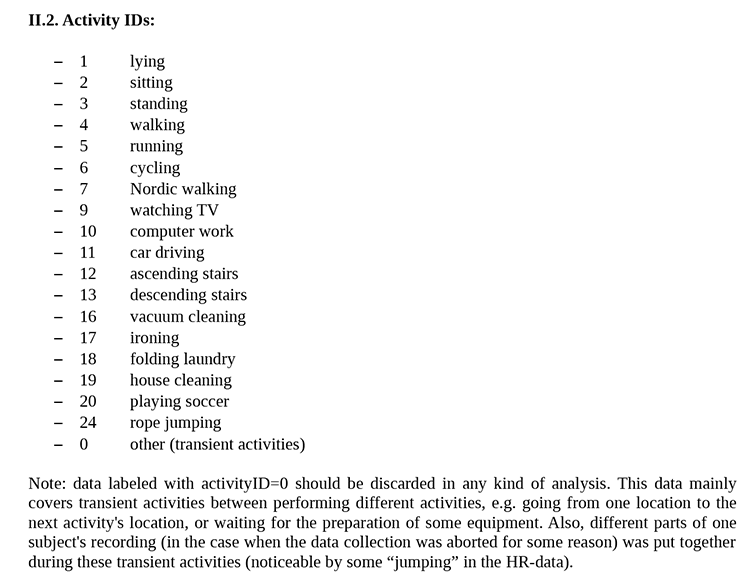

In [7]:
display_image('activities.png')

In [8]:
activity_id_map = {0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing',
                4: 'walking', 5: 'running', 6: 'cycling', 7: 'nordic_walking',
                9: 'watch_tv', 10: 'computer_work', 11: 'car_driving', 12: 'asc_stairs',
                13: 'desc_stairs', 16: 'vaccum', 17: 'ironing', 18: 'folding_laundry',
                19: 'house_cleaning', 20: 'soccer', 24: 'rope_jump'}

In [9]:
pprint(activity_id_map)

{0: 'transient',
 1: 'lying',
 2: 'sitting',
 3: 'standing',
 4: 'walking',
 5: 'running',
 6: 'cycling',
 7: 'nordic_walking',
 9: 'watch_tv',
 10: 'computer_work',
 11: 'car_driving',
 12: 'asc_stairs',
 13: 'desc_stairs',
 16: 'vaccum',
 17: 'ironing',
 18: 'folding_laundry',
 19: 'house_cleaning',
 20: 'soccer',
 24: 'rope_jump'}



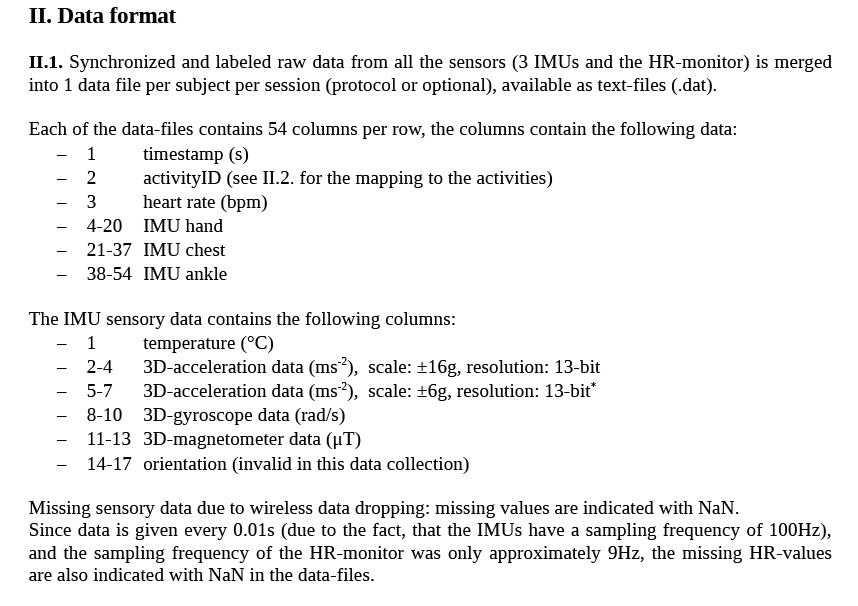

In [10]:
display_image('data_format.png')

<h4>3D data is (x, y, z) like (pitch, roll and yaw)</h4>


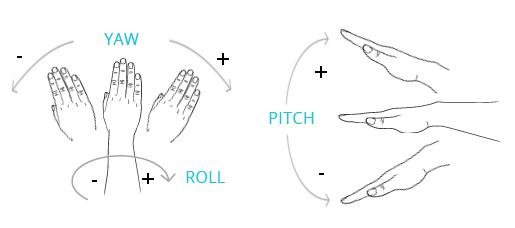

In [247]:
display_image('pitch_roll.png')


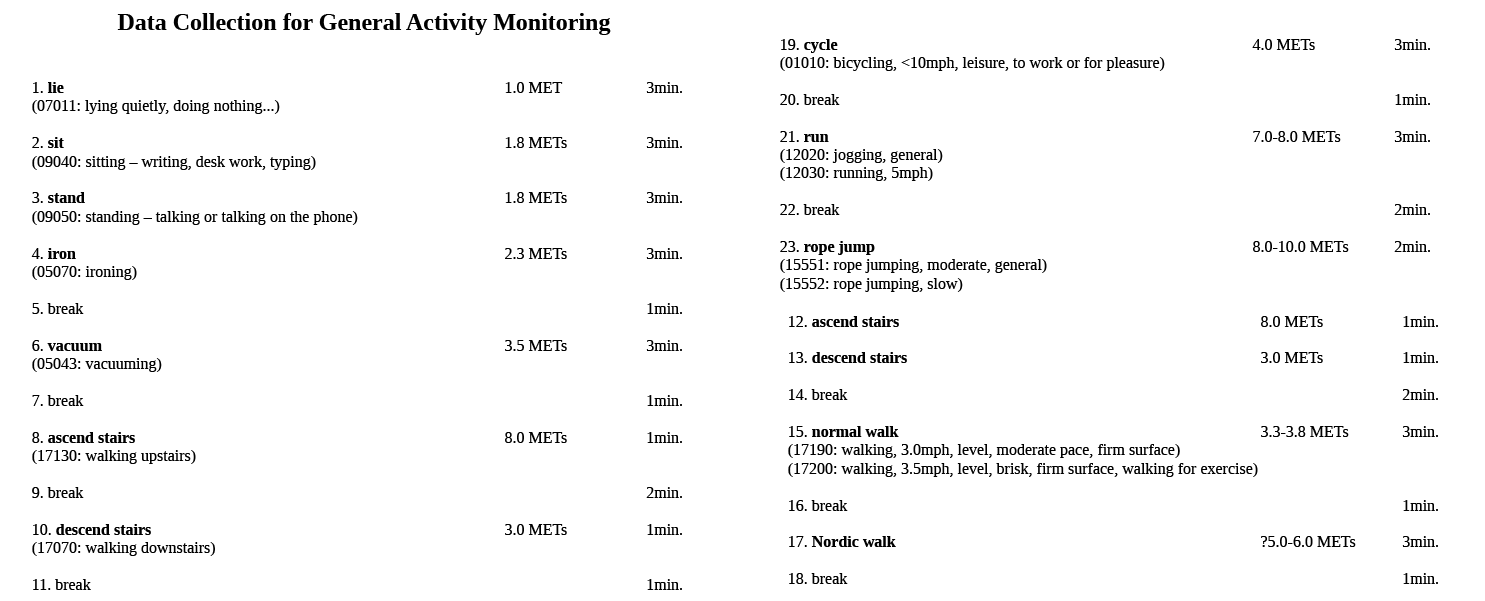

In [248]:
display_image('protocol.png')

<h3>Generating data columns & Preparing the data</h3>

In [249]:
from functools import reduce

def generate_data_cols():
    sensor_locations = ['hand', 'chest', 'ankle']
    def generate_IMU_cols(name):
        IMU_sensory_data = ['acceleration_16g', 'acceleration_6g', 'gyroscope', 'magnetometer']
        def generate_3d_data_cols(sensor_data):
            return [f'{name}_3d_{sensor_data}_{axis}' for axis in ['x', 'y', 'z']]
        return [f'{name}_temperature'] + reduce(lambda x, y: x + y, [generate_3d_data_cols(sensor_data) for sensor_data in IMU_sensory_data]) + [f'{name}_orientation_{idx}' for idx in range(4)]
    return ['timestamp', 'activity_id', 'heart_rate'] + reduce(lambda x, y: x + y, [generate_IMU_cols(sensor_location) for sensor_location in sensor_locations])

In [250]:
data_columns = generate_data_cols()

print(data_columns)
print(f'{len(generate_data_cols())} Columns')

['timestamp', 'activity_id', 'heart_rate', 'hand_temperature', 'hand_3d_acceleration_16g_x', 'hand_3d_acceleration_16g_y', 'hand_3d_acceleration_16g_z', 'hand_3d_acceleration_6g_x', 'hand_3d_acceleration_6g_y', 'hand_3d_acceleration_6g_z', 'hand_3d_gyroscope_x', 'hand_3d_gyroscope_y', 'hand_3d_gyroscope_z', 'hand_3d_magnetometer_x', 'hand_3d_magnetometer_y', 'hand_3d_magnetometer_z', 'hand_orientation_0', 'hand_orientation_1', 'hand_orientation_2', 'hand_orientation_3', 'chest_temperature', 'chest_3d_acceleration_16g_x', 'chest_3d_acceleration_16g_y', 'chest_3d_acceleration_16g_z', 'chest_3d_acceleration_6g_x', 'chest_3d_acceleration_6g_y', 'chest_3d_acceleration_6g_z', 'chest_3d_gyroscope_x', 'chest_3d_gyroscope_y', 'chest_3d_gyroscope_z', 'chest_3d_magnetometer_x', 'chest_3d_magnetometer_y', 'chest_3d_magnetometer_z', 'chest_orientation_0', 'chest_orientation_1', 'chest_orientation_2', 'chest_orientation_3', 'ankle_temperature', 'ankle_3d_acceleration_16g_x', 'ankle_3d_acceleration_1

In [251]:
def load_subject_data(columns, path='PAMAP2_Dataset\Protocol'):
    data = pd.DataFrame()
    subject_ids = set()
    protocol_data_path = join(data_dir, path)
    for filename in tqdm(os.listdir(protocol_data_path), desc="Loading subject data"):
        subject_path = join(protocol_data_path, filename)
        subject = pd.read_table(subject_path, header=None, sep='\s+')
        subject.columns = columns
        subject_id = int(''.join(list(filter(str.isdigit, filename))))
        subject_ids.add(subject_id)
        subject.insert(0, 'subject_id', subject_id)
        data = data.append(subject, ignore_index=True)
    data.reset_index(drop=True, inplace=True)
    return data, subject_ids;

In [252]:
protocol_data, protocol_subjects = load_subject_data(data_columns)

Loading subject data: 100%|██████████| 9/9 [02:40<00:00, 17.82s/it]


In [253]:
protocol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872533 entries, 0 to 2872532
Data columns (total 55 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   subject_id                   int64  
 1   timestamp                    float64
 2   activity_id                  int64  
 3   heart_rate                   float64
 4   hand_temperature             float64
 5   hand_3d_acceleration_16g_x   float64
 6   hand_3d_acceleration_16g_y   float64
 7   hand_3d_acceleration_16g_z   float64
 8   hand_3d_acceleration_6g_x    float64
 9   hand_3d_acceleration_6g_y    float64
 10  hand_3d_acceleration_6g_z    float64
 11  hand_3d_gyroscope_x          float64
 12  hand_3d_gyroscope_y          float64
 13  hand_3d_gyroscope_z          float64
 14  hand_3d_magnetometer_x       float64
 15  hand_3d_magnetometer_y       float64
 16  hand_3d_magnetometer_z       float64
 17  hand_orientation_0           float64
 18  hand_orientation_1           float64
 19  

In [254]:
protocol_data

subject_id  timestamp  activity_id  heart_rate  hand_temperature  \
0               101       8.38            0       104.0           30.0000   
1               101       8.39            0         NaN           30.0000   
2               101       8.40            0         NaN           30.0000   
3               101       8.41            0         NaN           30.0000   
4               101       8.42            0         NaN           30.0000   
...             ...        ...          ...         ...               ...   
2872528         109     100.19            0         NaN           25.1875   
2872529         109     100.20            0         NaN           25.1875   
2872530         109     100.21            0         NaN           25.1875   
2872531         109     100.22            0         NaN           25.1875   
2872532         109     100.23            0       161.0           25.1875   

         hand_3d_acceleration_16g_x  hand_3d_acceleration_16g_y  \
0                           2.37223                     8.60074   
1                           2.18837                     8.56560   
2                           2.37357                     8.60107   
3                           2.07473                     8.52853   
4                           2.22936                     8.83122   
...                             ...                         ...   
2872528                    -4.71493                    10.22250   
2872529                    -4.95932                    10.37130   
2872530                    -4.93997                     9.83615   
2872531                    -4.64941                     9.11129   
2872532                    -4.09726                     8.15642   

         hand_3d_acceleration_16g_z  hand_3d_acceleration_6g_x  \
0                           3.51048                    2.43954   
1                           3.66179                    2.39494   
2                           3.54898                    2.30514   
3                           3.66021                    2.33528   
4                           3.70000                    2.23055   
...                             ...                        ...   
2872528                     4.66893                   -5.04654   
2872529                     4.12594                   -4.96890   
2872530                     3.70468                   -5.04613   
2872531                     3.51904                   -5.06854   
2872532                     3.29961                   -4.73244   

         hand_3d_acceleration_6g_y  ...  ankle_3d_gyroscope_x  \
0                          8.76165  ...              0.008300   
1                          8.55081  ...             -0.006577   
2                          8.53644  ...              0.003014   
3                          8.53622  ...              0.003175   
4                          8.59741  ...              0.012698   
...                            ...  ...                   ...   
2872528                    9.94944  ...             -0.037788   
2872529                   10.29620  ...             -0.068904   
2872530                   10.35690  ...             -0.070888   
2872531                    9.75268  ...              0.018961   
2872532                    8.82870  ...             -0.027472   

         ankle_3d_gyroscope_y  ankle_3d_gyroscope_z  ankle_3d_magnetometer_x  \
0                    0.009250             -0.017580                 -61.1888   
1                   -0.004638              0.000368                 -59.8479   
2                    0.000148              0.022495                 -60.7361   
3                   -0.020301              0.011275                 -60.4091   
4                   -0.014303             -0.002823                 -61.5199   
...                       ...                   ...                      ...   
2872528             -0.062676             -0.127084                 -46.5153   
2872529             -0.027006             -0.089808              

In [255]:
protocol_data.describe().apply(lambda s: s.apply(lambda n: int(n) if n.is_integer() else '{0:.3f}'.format(n)))

subject_id timestamp activity_id heart_rate hand_temperature  \
count    2872533   2872533     2872533     262268          2859392   
mean     104.500  1834.354       5.466    109.873           32.653   
std        2.367  1105.689       6.331     25.870            1.844   
min          101     5.640           0         57           24.750   
25%          102   893.160           0         90           31.438   
50%          105  1790.830           3        108           33.125   
75%          107  2710.570           7        125               34   
max          109  4475.630          24        202           35.500   

      hand_3d_acceleration_16g_x hand_3d_acceleration_16g_y  \
count                    2859392                    2859392   
mean                      -4.961                      3.588   
std                        5.985                      6.278   
min                     -145.367                   -104.301   
25%                       -9.028                      1.290   
50%                       -5.788                      3.571   
75%                       -0.783                      6.603   
max                       62.860                    155.699   

      hand_3d_acceleration_16g_z hand_3d_acceleration_6g_x  \
count                    2859392                   2859392   
mean                       3.168                    -4.889   
std                        3.844                     5.993   
min                     -101.452                   -61.489   
25%                        0.969                    -8.933   
50%                        2.958                    -5.738   
75%                        6.003                    -0.725   
max                      157.760                    52.821   

      hand_3d_acceleration_6g_y  ... ankle_3d_gyroscope_x  \
count                   2859392  ...              2860784   
mean                      3.584  ...                0.009   
std                       6.056  ...                1.074   
min                     -61.868  ...              -23.995   
25%                       1.285  ...               -0.153   
50%                       3.613  ...                0.004   
75%                       6.602  ...                0.095   
max                      62.260  ...               17.420   

      ankle_3d_gyroscope_y ankle_3d_gyroscope_z ankle_3d_magnetometer_x  \
count              2860784              2860784                 2860784   
mean                -0.035                0.008                 -32.721   
std                  0.597                1.843                  18.879   
min                -18.127              -14.020                -172.865   
25%                 -0.083               -0.308                 -42.895   
50%                 -0.004               -0.002                 -33.900   
75%                  0.083                0.063                 -19.059   
max                 13.588               16.529                  97.525   

      ankle_3d_magnetometer_y ankle_3d_magnetometer_z ankle_orientation_0  \
count                 2860784                 2860784             2860784   
mean                    1.593                  16.890               0.399   
std                    21.612                  20.309               0.303   
min                  -137.908                -109.289              -0.254   
25%                   -11.485                   3.289               0.156   
50%                     1.363                  18.091               0.320   
75%                    17.331                  30.878               0.579   
max                   123.306                 146.900                   1   

      ankle_orientation_1 ankle_orientation_2 ankle_orientation_3  
count             2860784             2860784             2860784  
mean                0.022               0.309              -0.019  
std                 0.569               0.324               0.473  
min                -0.957              -0.877           

In [256]:
optional_data, optional_subjects = load_subject_data(data_columns, path='PAMAP2_Dataset\Optional')

Loading subject data: 100%|██████████| 5/5 [00:49<00:00,  9.80s/it]


In [257]:
optional_data

subject_id  timestamp  activity_id  heart_rate  hand_temperature  \
0              101      10.03            0       105.0           33.3125   
1              101      10.04            0         NaN           33.3125   
2              101      10.05            0         NaN           33.3125   
3              101      10.06            0         NaN           33.3125   
4              101      10.07            0         NaN           33.3125   
...            ...        ...          ...         ...               ...   
977967         109    1940.78            0         NaN           24.8750   
977968         109    1940.79            0         NaN           24.8750   
977969         109    1940.80            0         NaN           24.8750   
977970         109    1940.81            0         NaN               NaN   
977971         109    1940.82            0       176.0               NaN   

        hand_3d_acceleration_16g_x  hand_3d_acceleration_16g_y  \
0                          1.99964                     6.94837   
1                          1.80990                     6.45729   
2                          1.82756                     5.93151   
3                          1.75760                     5.78202   
4                          1.50670                     6.20407   
...                            ...                         ...   
977967                    -6.51915                     6.87682   
977968                    -6.47548                     6.95375   
977969                    -6.58698                     6.84148   
977970                         NaN                         NaN   
977971                         NaN                         NaN   

        hand_3d_acceleration_16g_z  hand_3d_acceleration_6g_x  \
0                          5.08845                    2.62244   
1                          5.16424                    2.19725   
2                          5.78208                    2.01408   
3                          5.97397                    1.83344   
4                          6.27669                    1.71564   
...                            ...                        ...   
977967                     2.34395                   -6.67159   
977968                     2.49829                   -6.71706   
977969                     2.57398                   -6.79405   
977970                         NaN                        NaN   
977971                         NaN                        NaN   

        hand_3d_acceleration_6g_y  ...  ankle_3d_gyroscope_x  \
0                         7.73457  ...             -0.013781   
1                         6.93762  ...             -0.026320   
2                         6.28989  ...             -0.049060   
3                         5.83858  ...             -0.031388   
4                         5.82465  ...              0.024549   
...                           ...  ...                   ...   
977967                    6.87843  ...             -0.040479   
977968                    6.87873  ...             -0.005168   
977969                    6.81875  ...              0.022185   
977970                        NaN  ...             -0.005940   
977971                        NaN  ...             -0.042861   

        ankle_3d_gyroscope_y  ankle_3d_gyroscope_z  ankle_3d_magnetometer_x  \
0                   0.009471              0.003633                 -43.8463   
1                   0.070031              0.001804                 -43.8385   
2                  -0.002170              0.012096                 -43.6100   
3                  -0.008545              0.007356                 -43.5199   
4                   0.036445             -0.004679                 -43.6258   
...                      ...                   ...                      ...   
977967              0.028883             -0.016737                 -40.1550   
977968              0.040632             -0.015746                 -39.7605   
977969              0.068296             

In [258]:
optional_data.describe().apply(lambda s: s.apply(lambda n: int(n) if n.is_integer() else '{0:.3f}'.format(n)))

subject_id timestamp activity_id heart_rate hand_temperature  \
count     977972    977972      977972      89285           976775   
mean     105.171  1095.266      10.987     92.842           32.982   
std        3.187   758.859       6.785     23.776            2.203   
min          101     5.660           0         60           24.500   
25%          101   495.700           9         78           32.125   
50%          106   984.690          10         87           33.375   
75%          108  1515.700          18        103           34.625   
max          109  3203.540          20        191           35.500   

      hand_3d_acceleration_16g_x hand_3d_acceleration_16g_y  \
count                     976775                     976775   
mean                      -1.592                      3.960   
std                        5.634                      5.510   
min                     -154.609                   -107.312   
25%                       -5.006                      1.295   
50%                       -0.479                      4.043   
75%                        2.077                      8.108   
max                      106.034                    157.611   

      hand_3d_acceleration_16g_z hand_3d_acceleration_6g_x  \
count                     976775                    976775   
mean                       4.431                    -1.494   
std                        4.444                     5.659   
min                     -118.846                   -61.432   
25%                        1.670                    -4.892   
50%                        4.362                    -0.339   
75%                        8.209                     2.259   
max                      155.737                    62.372   

      hand_3d_acceleration_6g_y  ... ankle_3d_gyroscope_x  \
count                    976775  ...               976165   
mean                      3.957  ...                0.004   
std                       5.527  ...                0.830   
min                     -61.876  ...              -29.078   
25%                       1.288  ...               -0.030   
50%                       4.052  ...                0.006   
75%                       8.096  ...                0.039   
max                      62.237  ...               24.479   

      ankle_3d_gyroscope_y ankle_3d_gyroscope_z ankle_3d_magnetometer_x  \
count               976165               976165                  976165   
mean                 0.001                0.007                 -29.422   
std                  0.419                0.990                  21.657   
min                -14.229              -16.474                -137.139   
25%                 -0.032               -0.023                 -43.569   
50%                 -0.003                0.003                 -30.918   
75%                  0.028                0.027                 -10.589   
max                 10.677               19.356                  46.210   

      ankle_3d_magnetometer_y ankle_3d_magnetometer_z ankle_orientation_0  \
count                  976165                  976165              976165   
mean                    1.855                  18.389               0.524   
std                    22.259                  21.910               0.370   
min                  -140.460                -152.323               0.000   
25%                   -14.844                   3.999               0.215   
50%                    -2.431                  22.014               0.444   
75%                    16.197                  36.957                   1   
max                    84.542                 107.369                   1   

      ankle_orientation_1 ankle_orientation_2 ankle_orientation_3  
count              976165              976165              976165  
mean               -0.135               0.189              -0.110  
std                 0.510               0.304               0.412  
min                -0.938              -0.975           

In [259]:
subject_ids = list(protocol_subjects.union(optional_subjects))
print(f"Subject IDS: {subject_ids}")

Subject IDS: [101, 102, 103, 104, 105, 106, 107, 108, 109]


In [290]:
unique_protocol = {i:activity_id_map[i] for i in protocol_data.activity_id.unique()}
unique_optional = {i:activity_id_map[i] for i in optional_data.activity_id.unique()}
print(f'Protocol data unique activities:\n {unique_protocol}')
print(f'Optional data unique activities: {unique_optional}')
print(f'Protocol and Optional intersected activites:\n {np.intersect1d(protocol_data.activity_id.unique(), optional_data.activity_id.unique())}')
print(f'Protocol and Optional activities union: {np.union1d(protocol_data.activity_id.unique(), optional_data.activity_id.unique())}, amount of activities in union: {len(np.union1d(protocol_data.activity_id.unique(), optional_data.activity_id.unique()))}')
print(f'Total activity count (including transient): {len(activity_id_map)}')

Protocol data unique activities:
 {0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 17: 'ironing', 16: 'vaccum', 12: 'asc_stairs', 13: 'desc_stairs', 4: 'walking', 7: 'nordic_walking', 6: 'cycling', 5: 'running', 24: 'rope_jump'}
Optional data unique activities: {0: 'transient', 11: 'car_driving', 9: 'watch_tv', 19: 'house_cleaning', 18: 'folding_laundry', 10: 'computer_work', 20: 'soccer'}
Protocol and Optional intersected activites:
 [0]
Protocol and Optional activities union: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 16 17 18 19 20 24], amount of activities in union: 19
Total activity count (including transient): 19


In [261]:
print(f'Min timestamp in protocol data: {protocol_data.timestamp.min()}')
print(f'Max timestamp in protocol data: {protocol_data.timestamp.max()}')
print(f'Min timestamp in optional data: {optional_data.timestamp.min()}')
print(f'Max timestamp in optional data: {optional_data.timestamp.max()}')

Min timestamp in protocol data: 5.64
Max timestamp in protocol data: 4475.63
Min timestamp in optional data: 5.66
Max timestamp in optional data: 3203.54


In [262]:
def plot_multi_bar_diagram(data, x, y, title, hue=None, legend_title=None, size_mult=1, order=False, label_rotation=0):
    fig, ax = plt.subplots(figsize=(15 * size_mult, 5))
    ax = sns.barplot(x=x, y=y, hue=hue, data=data, ax=ax, order=data[x] if order else None)
    plt.xticks(rotation=label_rotation)
    ax.set_title(title)
    if hue is not None:
        legend = ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1)
        legend.set_title(legend_title)
        if hue == 'activity_id':
            for legend_label in legend.texts:
                legend_label.set_text(activity_id_map[int(legend_label.get_text())])
    plt.show()

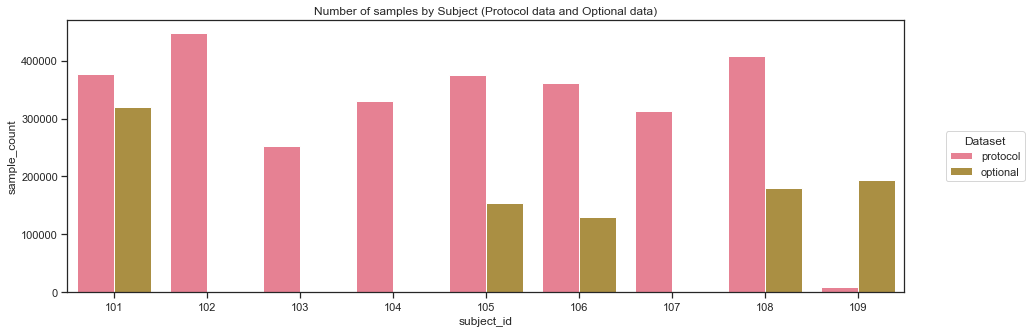

In [263]:
protocol_sample_count_data = protocol_data.groupby(['subject_id']).count().reset_index()[['subject_id', 'timestamp']]
optional_sample_count_data = optional_data.groupby(['subject_id']).count().reset_index()[['subject_id', 'timestamp']]
protocol_sample_count_data['from'] = 'protocol'
protocol_sample_count_data.rename({'timestamp': 'sample_count'}, axis=1, inplace=True)
optional_sample_count_data['from'] = 'optional'
optional_sample_count_data.rename({'timestamp': 'sample_count'}, axis=1, inplace=True)
plot_bar_data = pd.concat([protocol_sample_count_data, optional_sample_count_data], ignore_index=True, sort=False)
plot_multi_bar_diagram(plot_bar_data, x='subject_id', y='sample_count', hue='from', title='Number of samples by Subject (Protocol data and Optional data)', legend_title='Dataset')


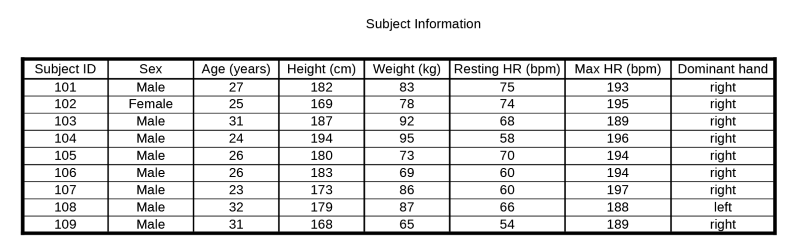


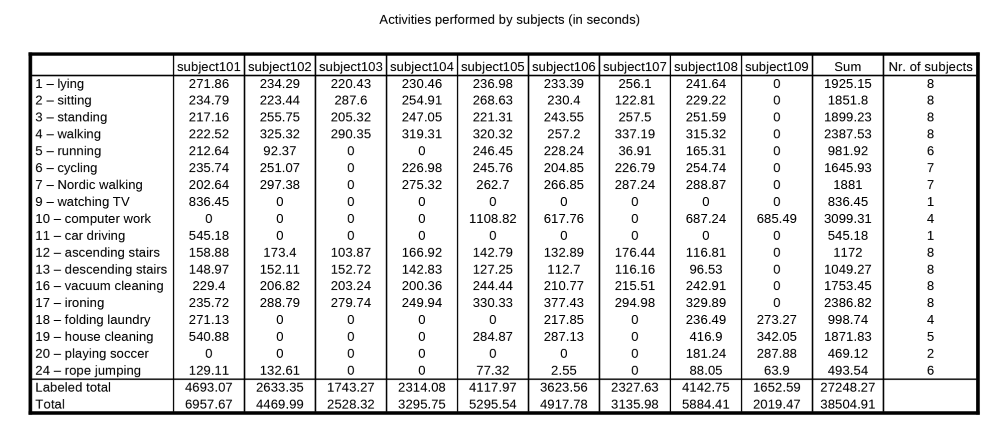

In [264]:
display_image('subject_info.png')
display_image('activities_summary.png')

<h4>IMU Sensory data samples from Subject 101</h4>

In [265]:
def plot_all_data(data, column, title, order=subject_ids):
    sns.set(style='ticks')
    sns.set_palette(palette='husl')
    grid = sns.FacetGrid(data, row="subject_id", row_order=order, height=2.5, aspect=11, hue='activity_id')
    grid.fig.suptitle(title)
    for ax in grid.axes.flatten():
        ax.tick_params(labelbottom=True)
    grid.map(sns.scatterplot, "timestamp", column, linewidth=0)
    grid.add_legend(loc='center right', bbox_to_anchor=(1, 0.5), ncol=1)
    grid._legend.set_title("Activites")
    for legend_label in grid._legend.texts:
        legend_label.set_text(activity_id_map[int(legend_label.get_text())])
    plt.show()

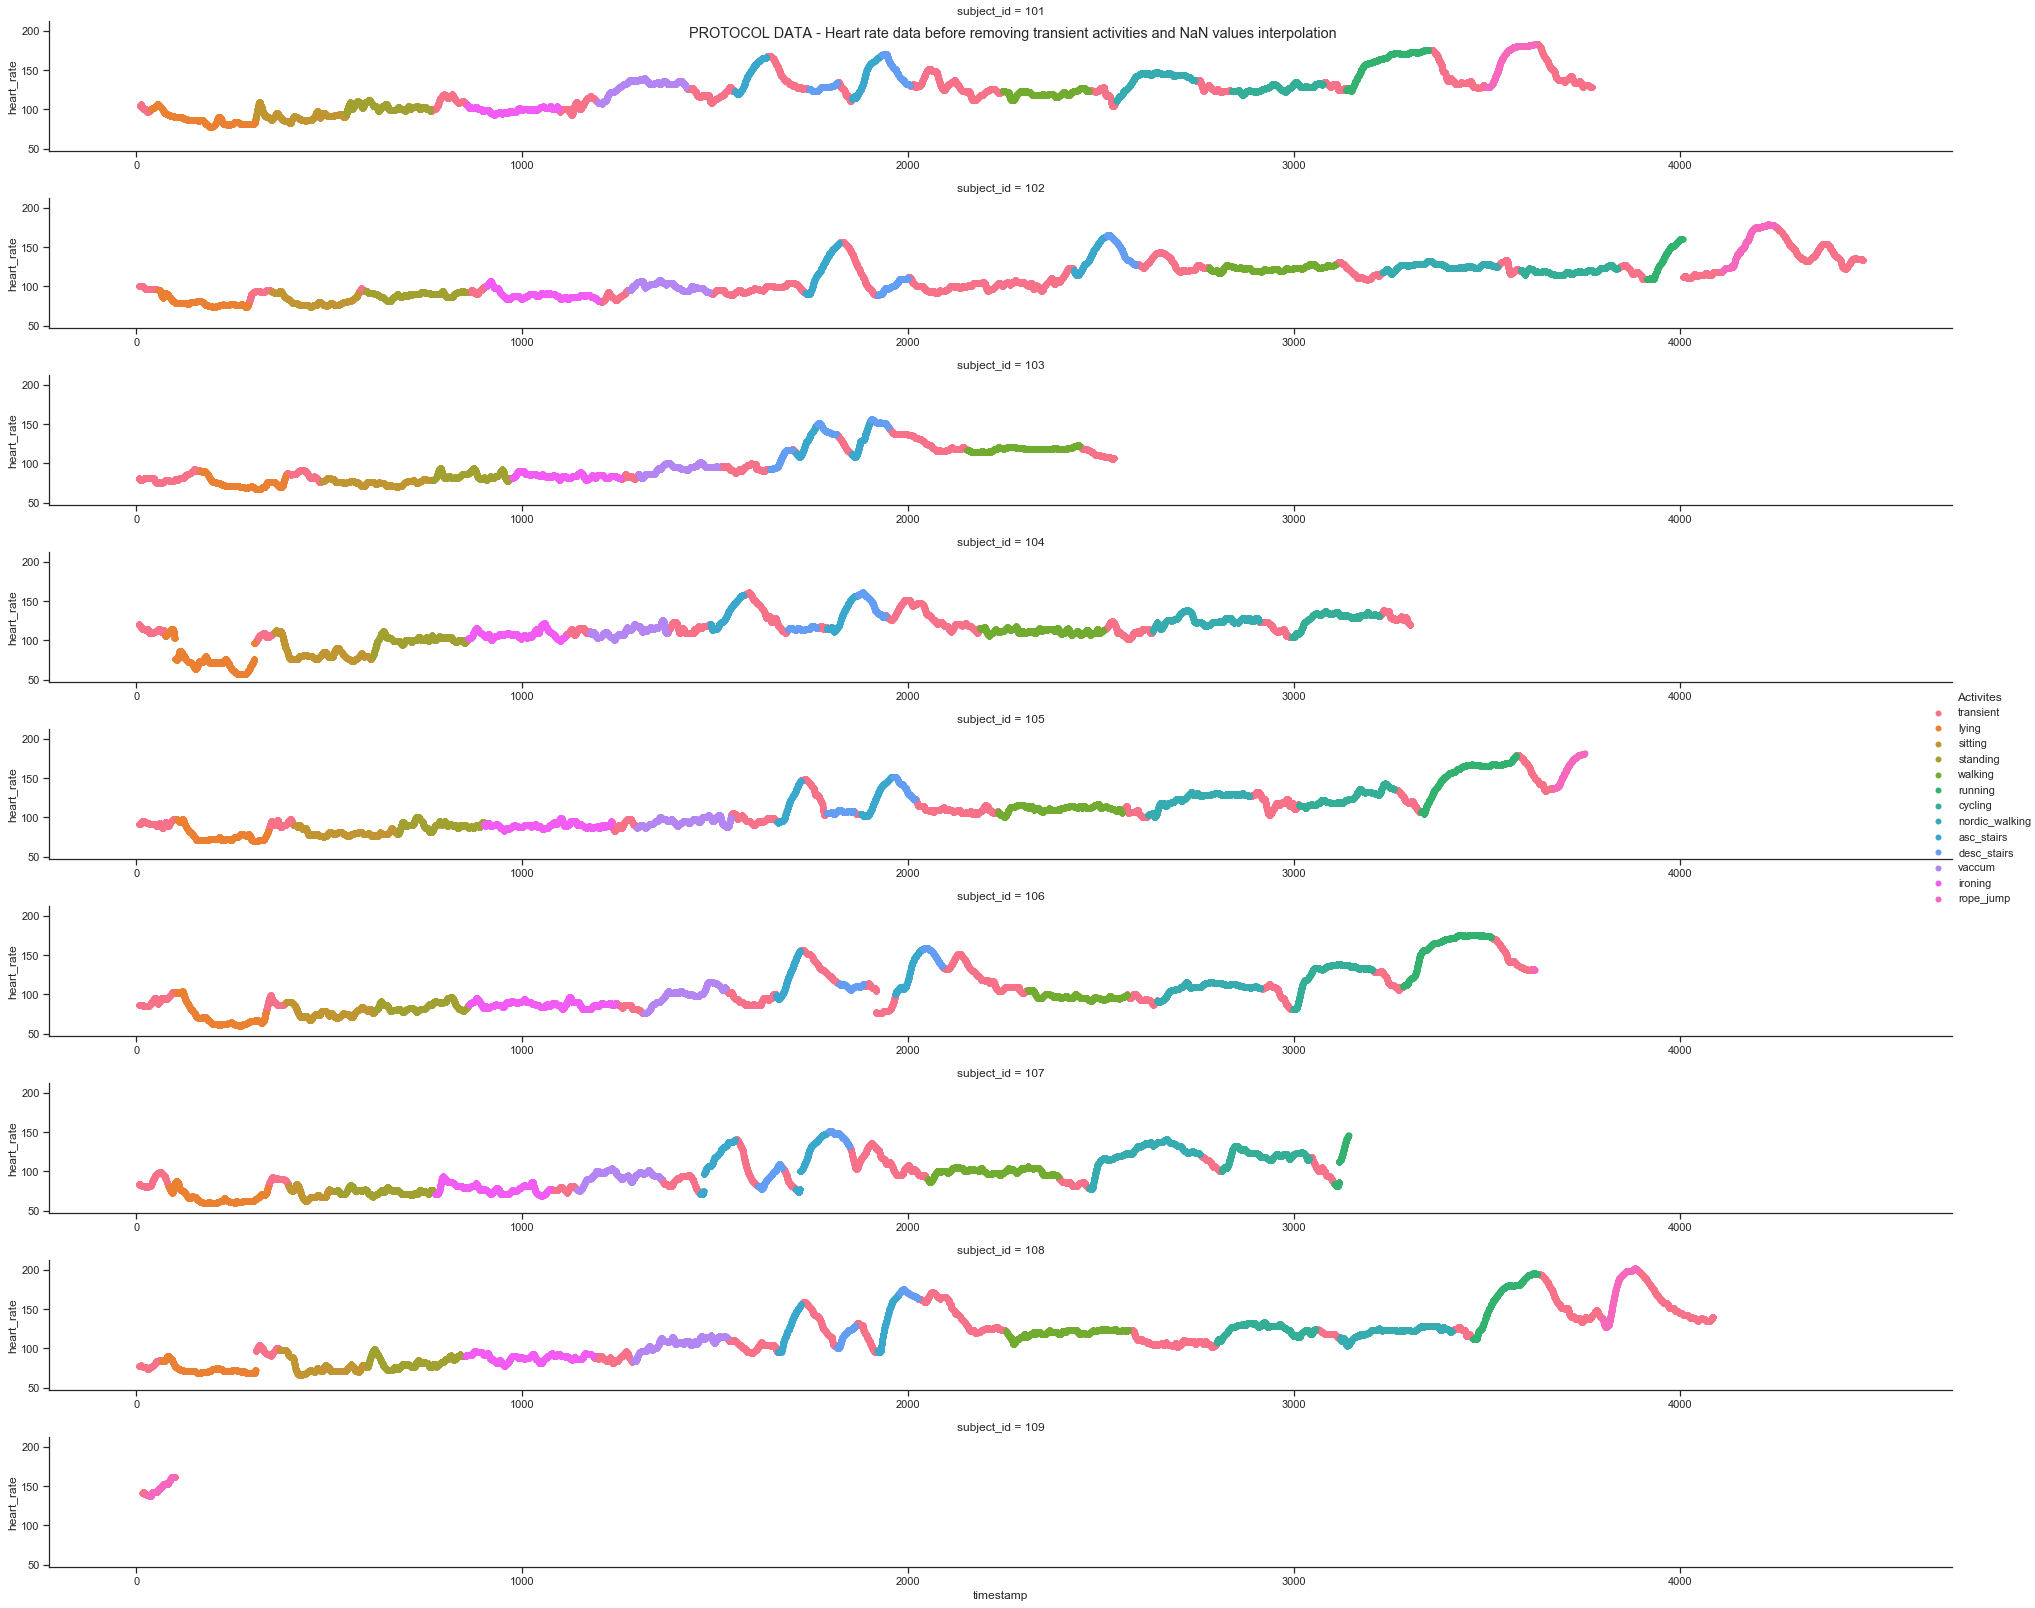

In [266]:
plot_all_data(protocol_data, column='heart_rate', title='PROTOCOL DATA - Heart rate data before removing transient activities and NaN values interpolation')

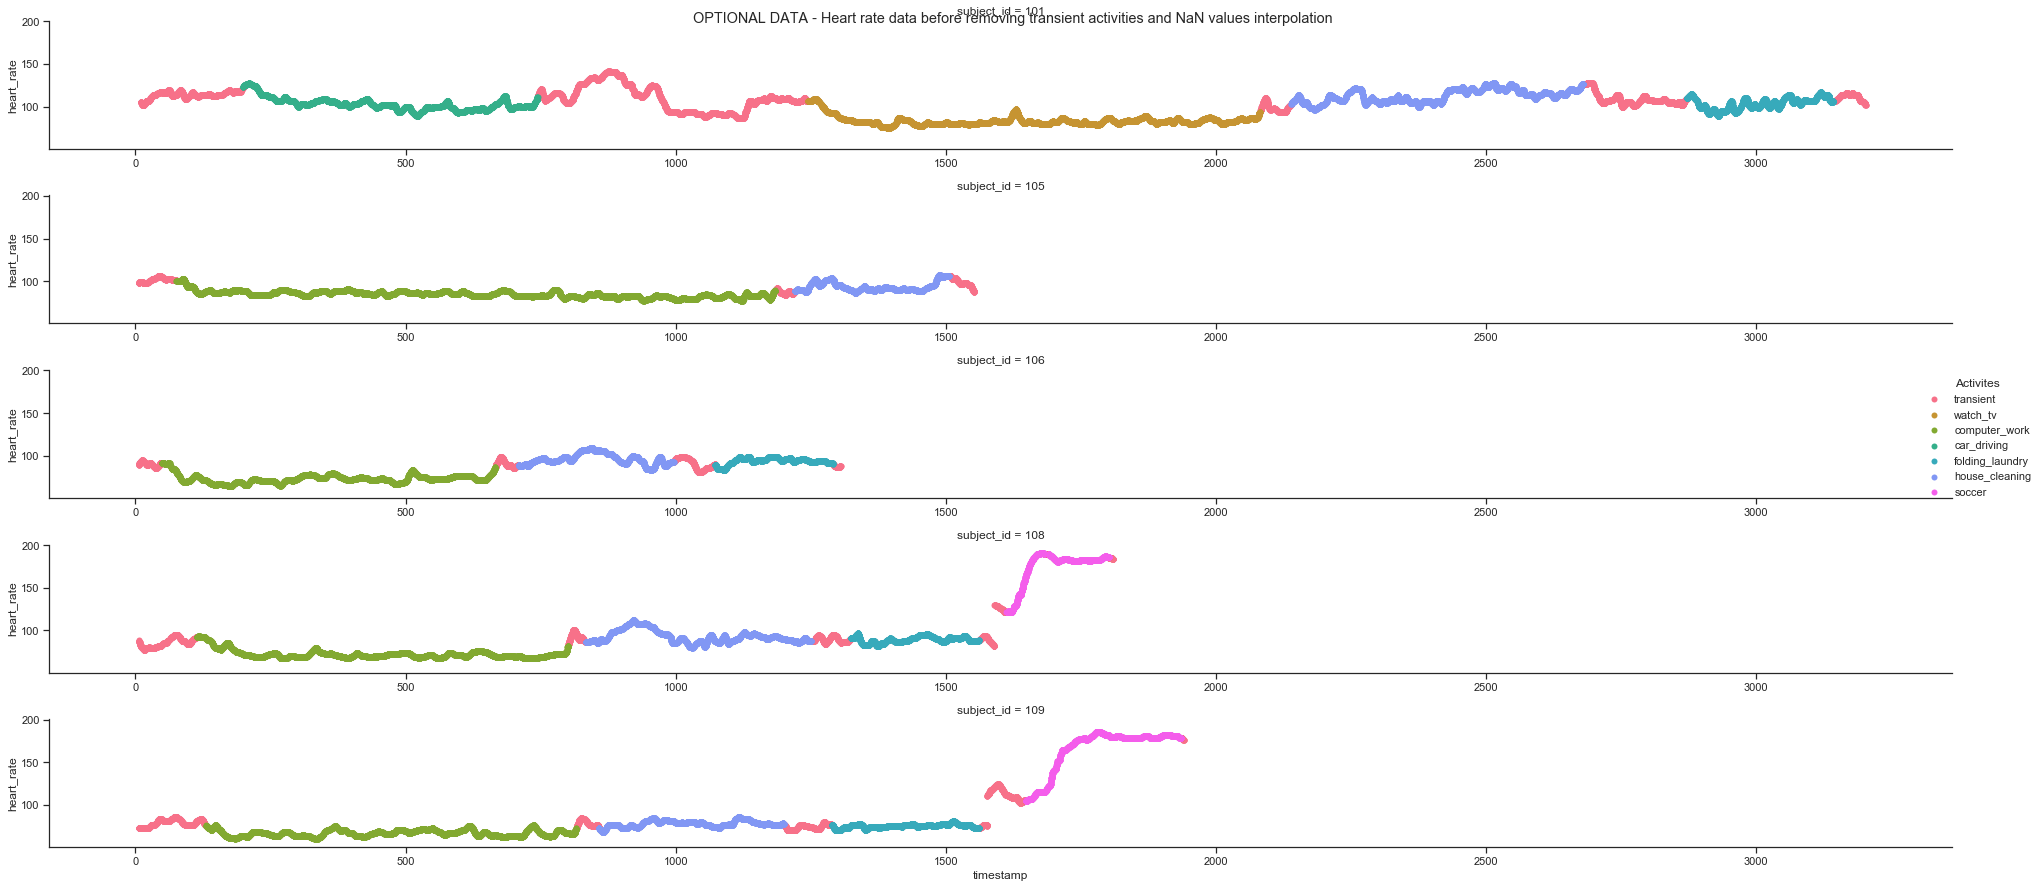

In [267]:
plot_all_data(optional_data, column='heart_rate', title='OPTIONAL DATA - Heart rate data before removing transient activities and NaN values interpolation', order=[101, 105, 106, 108, 109])

<h4>Few notices on the Protocol and Optional data</h4>
<ul>
<li>We can see that the only common activity to the protocol data and optional data of the PAMAP2 dataset is activity 0 which is an transient activity and therfore will be removed.</li>
<li>We want our data to contain labeled data fro both the protocol activities and optional activities.</li>
<li>To do so we will concatenate our protocol and optional data. <b>A problem that may occur from such concatenation is distortion of the timestamp data</b><br/>
To overcome this problem, and since we wish to classify each activity individually and not the relation between activities, we will set all the optional data timestamp to be after the protocol timestamps.</li>
</ul>

In [268]:
def concat_protocol_optional_data():
    protocol_last_times = pd.DataFrame(protocol_data.groupby('subject_id').timestamp.max())
    for subject_id in subject_ids:
        max_time = protocol_last_times[protocol_last_times.index == subject_id].timestamp.item()
        optional_data.loc[optional_data.subject_id == subject_id, 'timestamp'] = optional_data[optional_data.subject_id == subject_id]['timestamp'].add(max_time)
    return pd.concat([protocol_data, optional_data])

In [269]:
data = concat_protocol_optional_data()

In [270]:
data

subject_id  timestamp  activity_id  heart_rate  hand_temperature  \
0              101       8.38            0       104.0            30.000   
1              101       8.39            0         NaN            30.000   
2              101       8.40            0         NaN            30.000   
3              101       8.41            0         NaN            30.000   
4              101       8.42            0         NaN            30.000   
...            ...        ...          ...         ...               ...   
977967         109    2041.01            0         NaN            24.875   
977968         109    2041.02            0         NaN            24.875   
977969         109    2041.03            0         NaN            24.875   
977970         109    2041.04            0         NaN               NaN   
977971         109    2041.05            0       176.0               NaN   

        hand_3d_acceleration_16g_x  hand_3d_acceleration_16g_y  \
0                          2.37223                     8.60074   
1                          2.18837                     8.56560   
2                          2.37357                     8.60107   
3                          2.07473                     8.52853   
4                          2.22936                     8.83122   
...                            ...                         ...   
977967                    -6.51915                     6.87682   
977968                    -6.47548                     6.95375   
977969                    -6.58698                     6.84148   
977970                         NaN                         NaN   
977971                         NaN                         NaN   

        hand_3d_acceleration_16g_z  hand_3d_acceleration_6g_x  \
0                          3.51048                    2.43954   
1                          3.66179                    2.39494   
2                          3.54898                    2.30514   
3                          3.66021                    2.33528   
4                          3.70000                    2.23055   
...                            ...                        ...   
977967                     2.34395                   -6.67159   
977968                     2.49829                   -6.71706   
977969                     2.57398                   -6.79405   
977970                         NaN                        NaN   
977971                         NaN                        NaN   

        hand_3d_acceleration_6g_y  ...  ankle_3d_gyroscope_x  \
0                         8.76165  ...              0.008300   
1                         8.55081  ...             -0.006577   
2                         8.53644  ...              0.003014   
3                         8.53622  ...              0.003175   
4                         8.59741  ...              0.012698   
...                           ...  ...                   ...   
977967                    6.87843  ...             -0.040479   
977968                    6.87873  ...             -0.005168   
977969                    6.81875  ...              0.022185   
977970                        NaN  ...             -0.005940   
977971                        NaN  ...             -0.042861   

        ankle_3d_gyroscope_y  ankle_3d_gyroscope_z  ankle_3d_magnetometer_x  \
0                   0.009250             -0.017580                 -61.1888   
1                  -0.004638              0.000368                 -59.8479   
2                   0.000148              0.022495                 -60.7361   
3                  -0.020301              0.011275                 -60.4091   
4                  -0.014303             -0.002823                 -61.5199   
...                      ...                   ...                      ...   
977967              0.028883             -0.016737                 -40.1550   
977968              0.040632             -0.015746                 -39.7605   
977969              0.068296             

In [271]:
data.describe().apply(lambda s: s.apply(lambda n: int(n) if n.is_integer() else '{0:.3f}'.format(n)))

subject_id timestamp activity_id heart_rate hand_temperature  \
count    3850505   3850505     3850505     351553          3836167   
mean     104.671  2429.207       6.868    105.547           32.736   
std        2.616  1644.247       6.883     26.416            1.947   
min          101     5.640           0         57           24.500   
25%          102  1077.400           0         85           31.625   
50%          105  2160.220           4        102           33.188   
75%          107  3586.140          12        122           34.125   
max          109  6976.080          24        202           35.500   

      hand_3d_acceleration_16g_x hand_3d_acceleration_16g_y  \
count                    3836167                    3836167   
mean                      -4.103                      3.683   
std                        6.078                      6.094   
min                     -154.609                   -107.312   
25%                       -8.701                      1.291   
50%                       -4.403                      3.684   
75%                        0.159                      7.034   
max                      106.034                    157.611   

      hand_3d_acceleration_16g_z hand_3d_acceleration_6g_x  \
count                    3836167                   3836167   
mean                       3.490                    -4.025   
std                        4.043                     6.092   
min                     -118.846                   -61.489   
25%                        1.134                    -8.607   
50%                        3.212                    -4.330   
75%                        6.453                     0.254   
max                      157.760                    62.372   

      hand_3d_acceleration_6g_y  ... ankle_3d_gyroscope_x  \
count                   3836167  ...              3836949   
mean                      3.679  ...                0.008   
std                       5.928  ...                1.017   
min                     -61.876  ...              -29.078   
25%                       1.285  ...               -0.087   
50%                       3.719  ...                0.005   
75%                       7.042  ...                0.066   
max                      62.260  ...               24.479   

      ankle_3d_gyroscope_y ankle_3d_gyroscope_z ankle_3d_magnetometer_x  \
count              3836949              3836949                 3836949   
mean                -0.026                0.008                 -31.882   
std                  0.557                1.667                  19.675   
min                -18.127              -16.474                -172.865   
25%                 -0.056               -0.130                 -42.980   
50%                 -0.004               -0.000                 -32.865   
75%                  0.055                0.045                 -18.783   
max                 13.588               19.356                  97.525   

      ankle_3d_magnetometer_y ankle_3d_magnetometer_z ankle_orientation_0  \
count                 3836949                 3836949             3836949   
mean                    1.660                  17.272               0.430   
std                    21.779                  20.738               0.326   
min                  -140.460                -152.323              -0.254   
25%                   -12.323                   3.425               0.164   
50%                     0.671                  18.727               0.337   
75%                    17.111                  33.148               0.633   
max                   123.306                 146.900                   1   

      ankle_orientation_1 ankle_orientation_2 ankle_orientation_3  
count             3836949             3836949             3836949  
mean               -0.018               0.279              -0.042  
std                 0.559               0.323               0.460  
min                -0.957              -0.975           

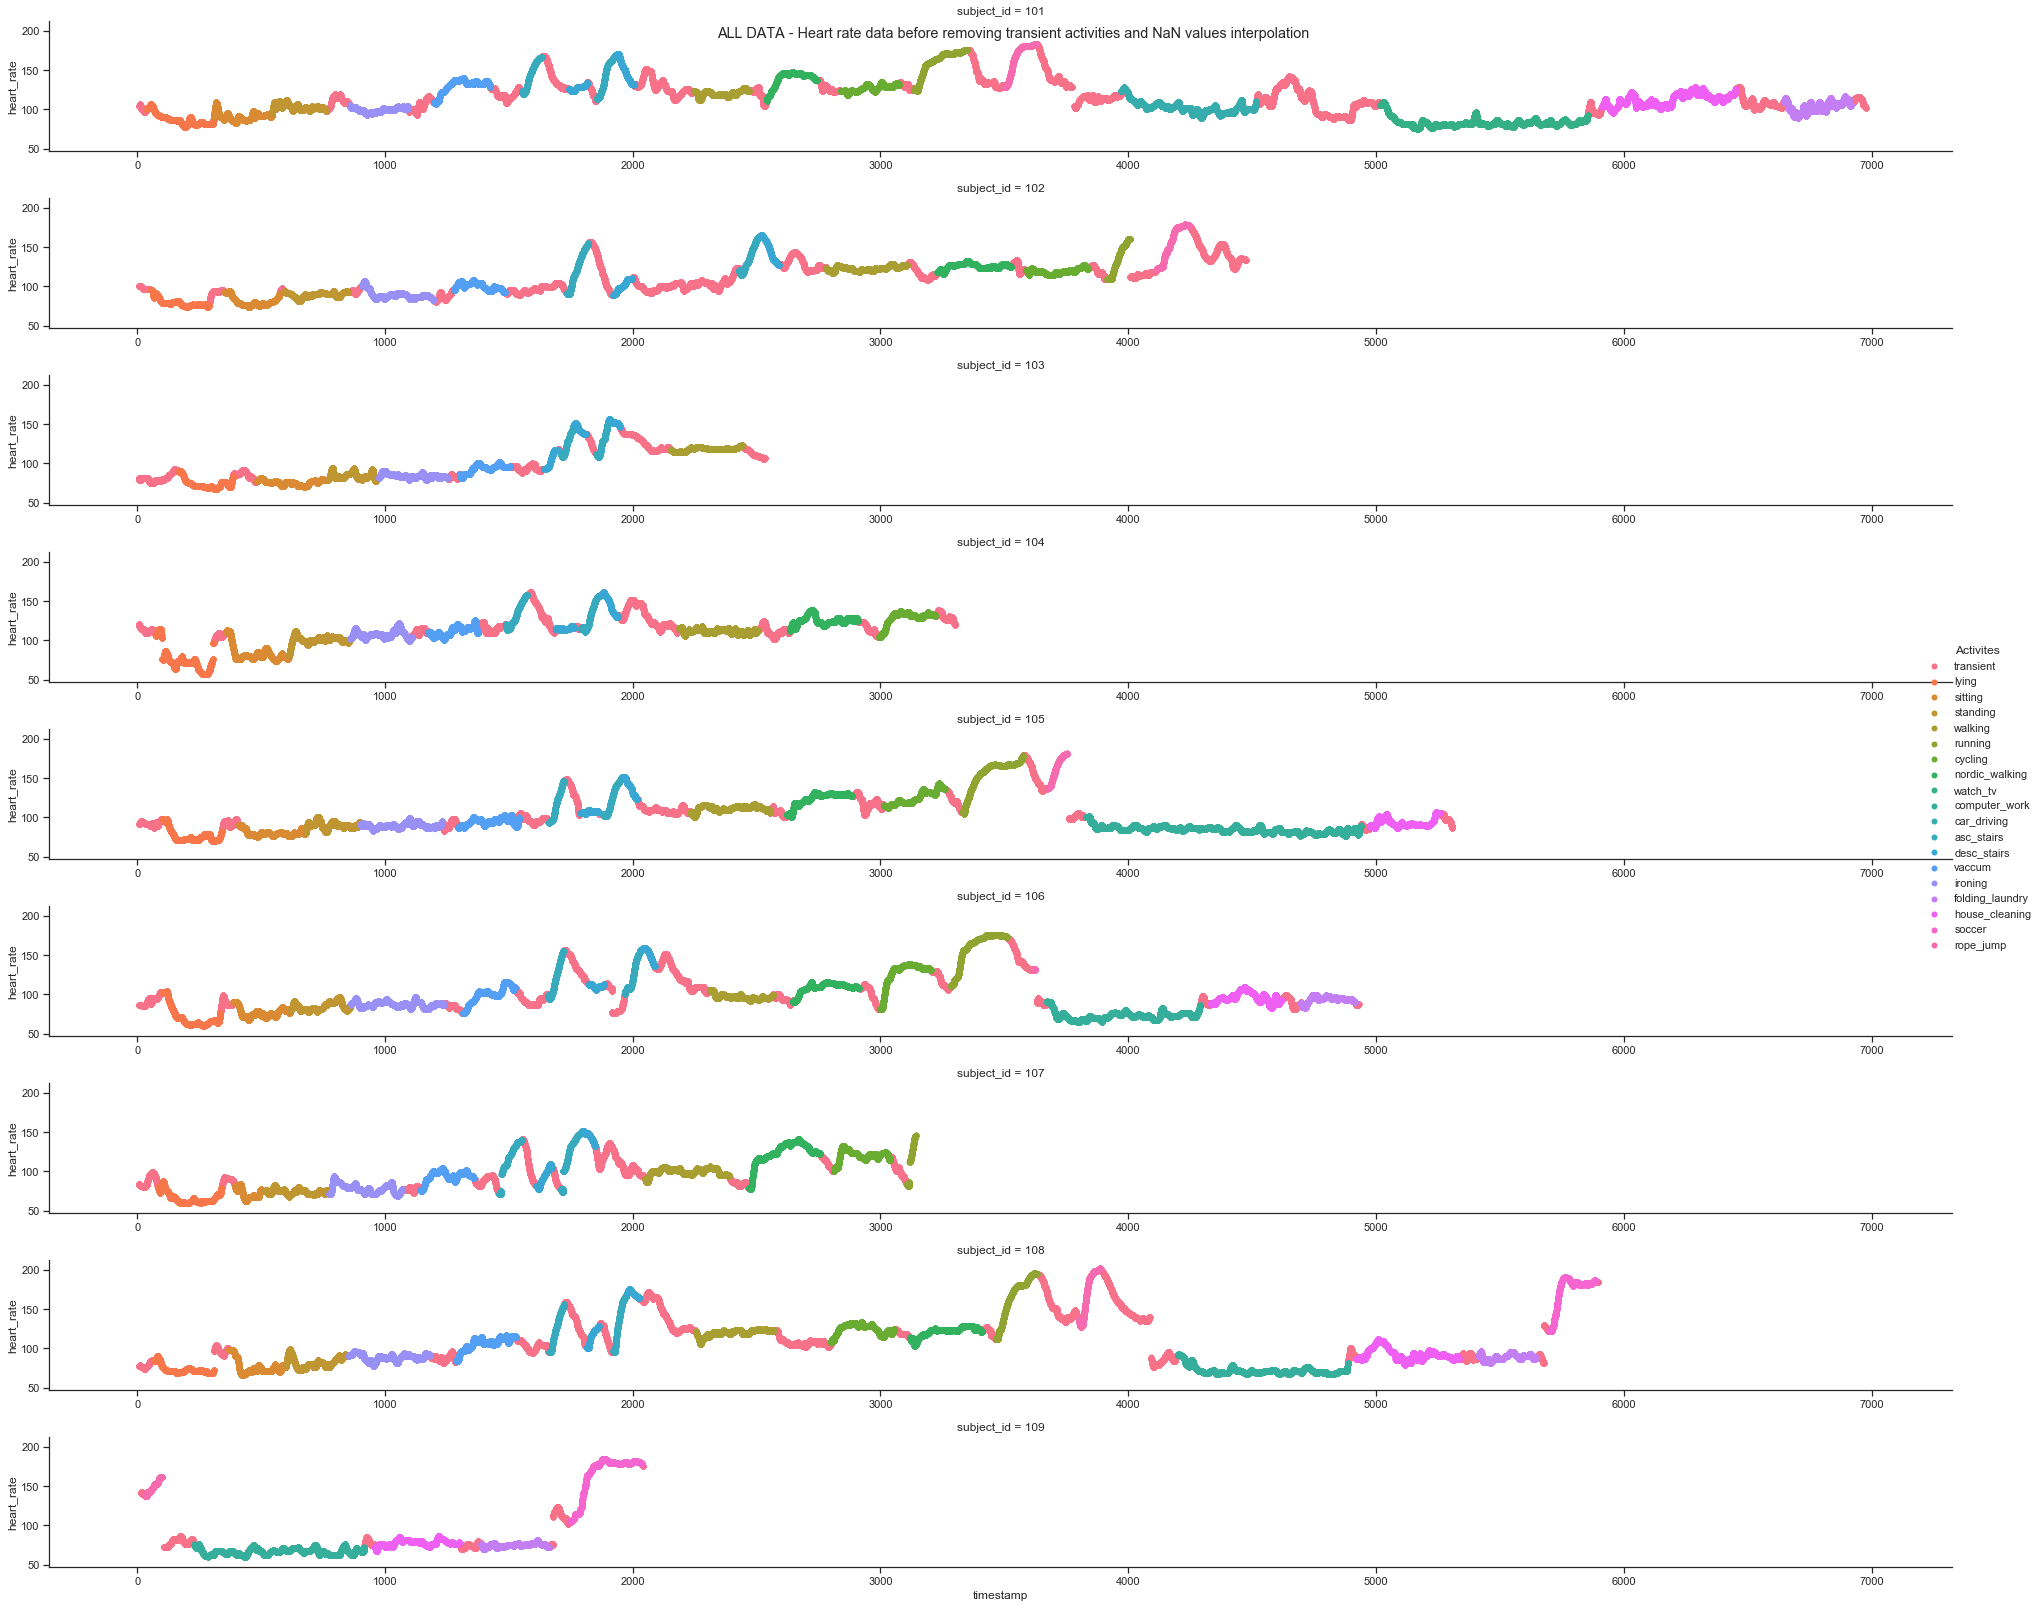

In [272]:
plot_all_data(data, column='heart_rate', title='ALL DATA - Heart rate data before removing transient activities and NaN values interpolation')

<h3> Check what coulmns has missing data values and the amount of missing values (NaN values)</h3>

In [273]:
pd.DataFrame({'column_name': data.columns, 'NaN count': [data[column].isna().sum() for column in data.columns]})

column_name  NaN count
0                    subject_id          0
1                     timestamp          0
2                   activity_id          0
3                    heart_rate    3498952
4              hand_temperature      14338
5    hand_3d_acceleration_16g_x      14338
6    hand_3d_acceleration_16g_y      14338
7    hand_3d_acceleration_16g_z      14338
8     hand_3d_acceleration_6g_x      14338
9     hand_3d_acceleration_6g_y      14338
10    hand_3d_acceleration_6g_z      14338
11          hand_3d_gyroscope_x      14338
12          hand_3d_gyroscope_y      14338
13          hand_3d_gyroscope_z      14338
14       hand_3d_magnetometer_x      14338
15       hand_3d_magnetometer_y      14338
16       hand_3d_magnetometer_z      14338
17           hand_orientation_0      14338
18           hand_orientation_1      14338
19           hand_orientation_2      14338
20           hand_orientation_3      14338
21            chest_temperature       4310
22  chest_3d_acceleration_16g_x       4310
23  chest_3d_acceleration_16g_y       4310
24  chest_3d_acceleration_16g_z       4310
25   chest_3d_acceleration_6g_x       4310
26   chest_3d_acceleration_6g_y       4310
27   chest_3d_acceleration_6g_z       4310
28         chest_3d_gyroscope_x       4310
29         chest_3d_gyroscope_y       4310
30         chest_3d_gyroscope_z       4310
31      chest_3d_magnetometer_x       4310
32      chest_3d_magnetometer_y       4310
33      chest_3d_magnetometer_z       4310
34          chest_orientation_0       4310
35          chest_orientation_1       4310
36          chest_orientation_2       4310
37          chest_orientation_3       4310
38            ankle_temperature      13556
39  ankle_3d_acceleration_16g_x      13556
40  ankle_3d_acceleration_16g_y      13556
41  ankle_3d_acceleration_16g_z      13556
42   ankle_3d_acceleration_6g_x      13556
43   ankle_3d_acceleration_6g_y      13556
44   ankle_3d_acceleration_6g_z      13556
45         ankle_3d_gyroscope_x      13556
46         ankle_3d_gyroscope_y      13556
47         ankle_3d_gyroscope_z      13556
48      ankle_3d_magnetometer_x      13556
49      ankle_3d_magnetometer_y      13556
50      ankle_3d_magnetometer_z      13556
51          ankle_orientation_0      13556
52          ankle_orientation_1      13556
53          ankle_orientation_2      13556
54          ankle_orientation_3      13556

<h4>Observe missing sensory data due to sensor frequency difference</h4>
<b>IMU sensors</b> frequency is 100Hz meaning 100 samples per second.<br/>
<b>HR sensor</b> frequency is 9Hz meaning 9 samples per second.<br/><br/>
We expect that for every 9 HR samples we will have 100 IMU samples so the ratio will be approx. 100/9 = ~11.11

In [274]:
data.hand_3d_acceleration_16g_x.count() / data[data.heart_rate.notnull()].heart_rate.count() 

10.912058779188344

<h4>Closer observation at the heart rate data points of Sample Subject 101 (first 4200 timestamps from activity 1)</h4>

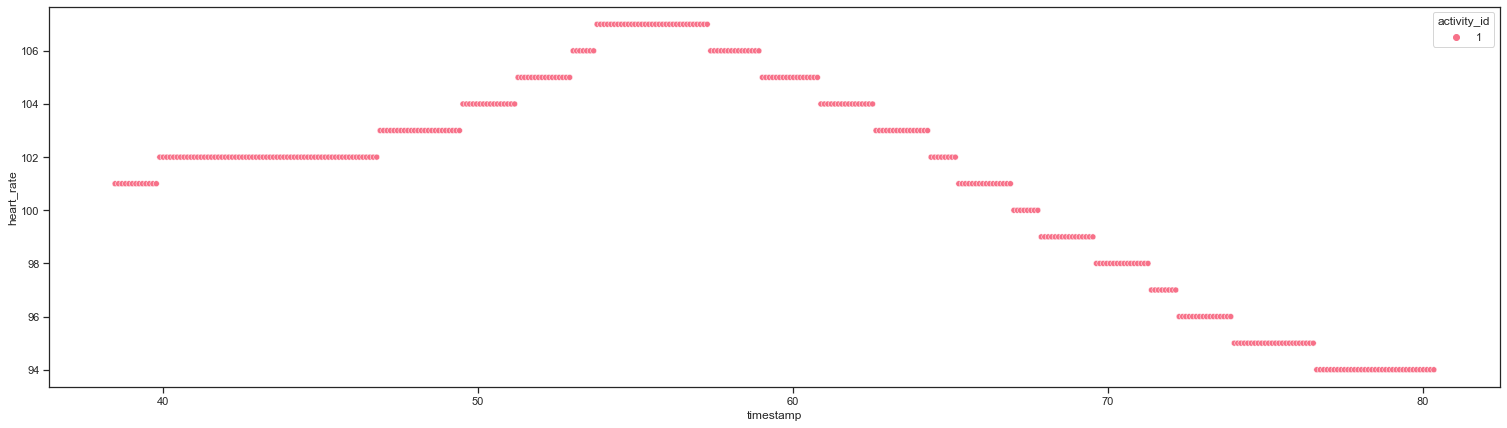

In [275]:
plt.figure(figsize=(26, 7))
sns.scatterplot(data=data[data.subject_id == 101][3000:7200], x='timestamp', y='heart_rate', hue='activity_id')
plt.show()

<h3>Initial data observations:</h3>
<ul>
    <li>The data contains missing values (NaN) due to wireless data dropping and due to the HR and IMU sensor frequency diff</li>
    <li>We can see that the data includes transient activities between other activities (index 0) that needs to be removed</li>
    <li>We can also note that all subject performed the activities in the same order as mentioned in the protocol.</li>
    <li>Not all subject performed all activites (i.e. subject 109 performed only one activity)</li>
    <li>Not all 18 activites has representation in the data</li>
</ul>

<h4>Fixing data</h4>
We can see that the data contains transient activities (activity_id = 0) and that some measurments contain NaN values.<br/>
As mentioned earlier, transient activities should be discarded.<br/>
We will solve the NaN values by using interpolation to estimate the missing value according to the previous and next closest values.

In [276]:
def discard_transient_activity(data):
    return data[data.activity_id != 0].reset_index(drop=True)

def interpolate_nan_values(data):
    for column in tqdm(data.columns, desc="Interpolating data columns containing NaN"):
        if data[column].isnull().values.any():
            data[column] = data[column].interpolate(method='linear', limit_direction='both')
    return data

In [277]:
fixed_data = interpolate_nan_values(discard_transient_activity(data))

Interpolating data columns containing NaN: 100%|██████████| 55/55 [00:14<00:00,  3.73it/s]


In [278]:
fixed_data

subject_id  timestamp  activity_id  heart_rate  hand_temperature  \
0               101      37.66            1       100.0            30.375   
1               101      37.67            1       100.0            30.375   
2               101      37.68            1       100.0            30.375   
3               101      37.69            1       100.0            30.375   
4               101      37.70            1       100.0            30.375   
...             ...        ...          ...         ...               ...   
2724948         109    2036.37           20       178.0            24.875   
2724949         109    2036.38           20       178.0            24.875   
2724950         109    2036.39           20       178.0            24.875   
2724951         109    2036.40           20       178.0            24.875   
2724952         109    2036.41           20       178.0            24.875   

         hand_3d_acceleration_16g_x  hand_3d_acceleration_16g_y  \
0                           2.21530                     8.27915   
1                           2.29196                     7.67288   
2                           2.29090                     7.14240   
3                           2.21800                     7.14365   
4                           2.30106                     7.25857   
...                             ...                         ...   
2724948                    -6.42779                     6.84232   
2724949                    -6.39107                     6.69028   
2724950                    -6.41763                     6.57977   
2724951                    -6.46049                     6.42730   
2724952                    -6.64998                     6.54224   

         hand_3d_acceleration_16g_z  hand_3d_acceleration_6g_x  \
0                           5.58753                    2.24689   
1                           5.74467                    2.27373   
2                           5.82342                    2.26966   
3                           5.89930                    2.22177   
4                           6.09259                    2.20720   
...                             ...                        ...   
2724948                     2.80728                   -6.52140   
2724949                     2.80834                   -6.55066   
2724950                     3.15471                   -6.53586   
2724951                     3.03912                   -6.55081   
2724952                     2.99740                   -6.59577   

         hand_3d_acceleration_6g_y  ...  ankle_3d_gyroscope_x  \
0                          8.55387  ...              0.002908   
1                          8.14592  ...              0.020882   
2                          7.66268  ...             -0.035392   
3                          7.25535  ...             -0.032514   
4                          7.24042  ...              0.001351   
...                            ...  ...                   ...   
2724948                    6.75658  ...             -0.013752   
2724949                    6.75689  ...             -0.009593   
2724950                    6.56061  ...             -0.010825   
2724951                    6.53056  ...             -0.019402   
2724952                    6.54600  ...             -0.004905   

         ankle_3d_gyroscope_y  ankle_3d_gyroscope_z  ankle_3d_magnetometer_x  \
0                   -0.027714              0.001752                 -61.1081   
1                    0.000945              0.006007                 -60.8916   
2                   -0.052422             -0.004882                 -60.3407   
3                   -0.018844              0.026950                 -60.7646   
4                   -0.048878             -0.006328                 -60.2040   
...                       ...                   ...                      ...   
2724948              0.011737             -0.011313                 -39.3605   
2724949             -0.014075             -0.052507              

In [279]:
fixed_data.describe().apply(lambda s: s.apply(lambda n: int(n) if n.is_integer() else '{0:.3f}'.format(n)))

subject_id timestamp activity_id heart_rate hand_temperature  \
count    2724953   2724953     2724953    2724953          2724953   
mean     104.811  2409.031       9.705    102.712           32.815   
std        2.597  1710.200       6.277     27.393            1.900   
min          101    31.200           1         57           24.875   
25%          102   922.370           4         82           31.812   
50%          105  2144.980          10         97           33.188   
75%          107  3649.050          16        120           34.188   
max          109  6915.950          24        202           35.500   

      hand_3d_acceleration_16g_x hand_3d_acceleration_16g_y  \
count                    2724953                    2724953   
mean                      -3.765                      3.638   
std                        6.316                      6.588   
min                     -154.609                   -104.301   
25%                       -8.379                      1.050   
50%                       -3.350                      3.626   
75%                        0.324                      6.928   
max                      106.034                    157.611   

      hand_3d_acceleration_16g_z hand_3d_acceleration_6g_x  \
count                    2724953                   2724953   
mean                       3.977                    -3.689   
std                        4.217                     6.330   
min                     -118.846                   -61.432   
25%                        1.338                    -8.278   
50%                        3.937                    -3.308   
75%                        7.059                     0.394   
max                      157.760                    62.372   

      hand_3d_acceleration_6g_y  ... ankle_3d_gyroscope_x  \
count                   2724953  ...              2724953   
mean                      3.628  ...                0.007   
std                       6.367  ...                1.049   
min                     -61.876  ...              -29.078   
25%                       1.050  ...               -0.098   
50%                       3.657  ...                0.005   
75%                       6.909  ...                0.073   
max                      62.260  ...               24.479   

      ankle_3d_gyroscope_y ankle_3d_gyroscope_z ankle_3d_magnetometer_x  \
count              2724953              2724953                 2724953   
mean                -0.025                0.007                 -29.764   
std                  0.584                1.773                  19.321   
min                -18.127              -16.474                -172.865   
25%                 -0.060               -0.144                 -40.858   
50%                 -0.003                0.000                 -31.421   
75%                  0.063                0.051                 -16.106   
max                 13.588               19.356                  91.552   

      ankle_3d_magnetometer_y ankle_3d_magnetometer_z ankle_orientation_0  \
count                 2724953                 2724953             2724953   
mean                    1.302                  17.937               0.411   
std                    21.885                  20.418               0.325   
min                  -140.460                -152.323               0.000   
25%                   -13.505                   4.457               0.155   
50%                    -0.358                  19.830               0.290   
75%                    16.941                  34.366               0.615   
max                    94.248                 146.900                   1   

      ankle_orientation_1 ankle_orientation_2 ankle_orientation_3  
count             2724953             2724953             2724953  
mean               -0.061               0.269              -0.084  
std                 0.562               0.331               0.466  
min                -0.957              -0.975           

<h4>Closer observation at the heart rate data points of Sample Subject 101 after interpolation(first 4200 timestamps from activity 1)</h4>

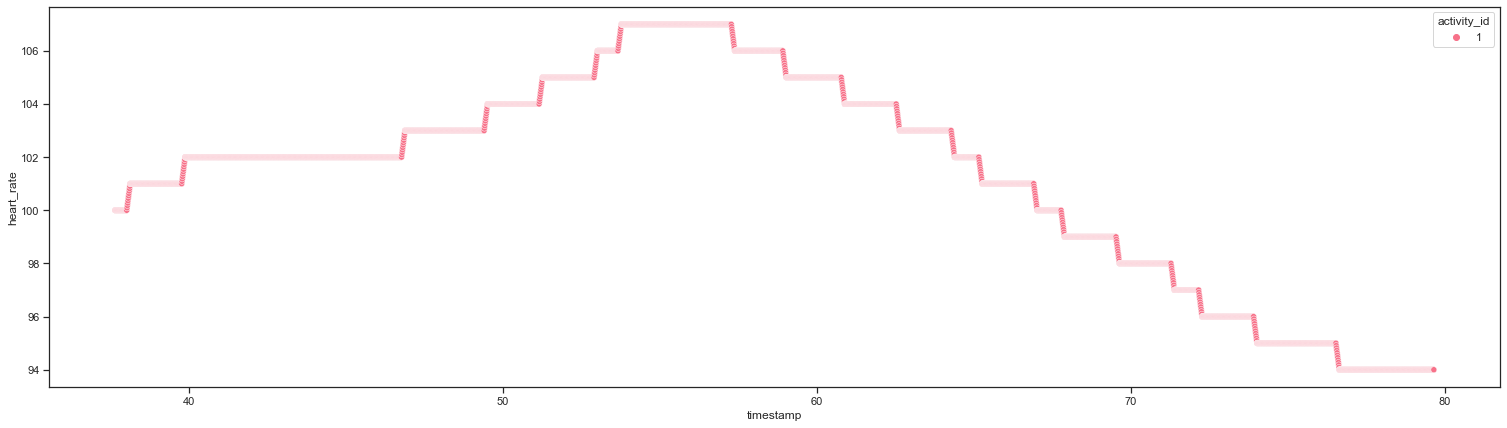

In [280]:
plt.figure(figsize=(26, 7))
sns.scatterplot(data=fixed_data[fixed_data.subject_id == 101][0:4200], x='timestamp', y='heart_rate', hue='activity_id')
plt.show()

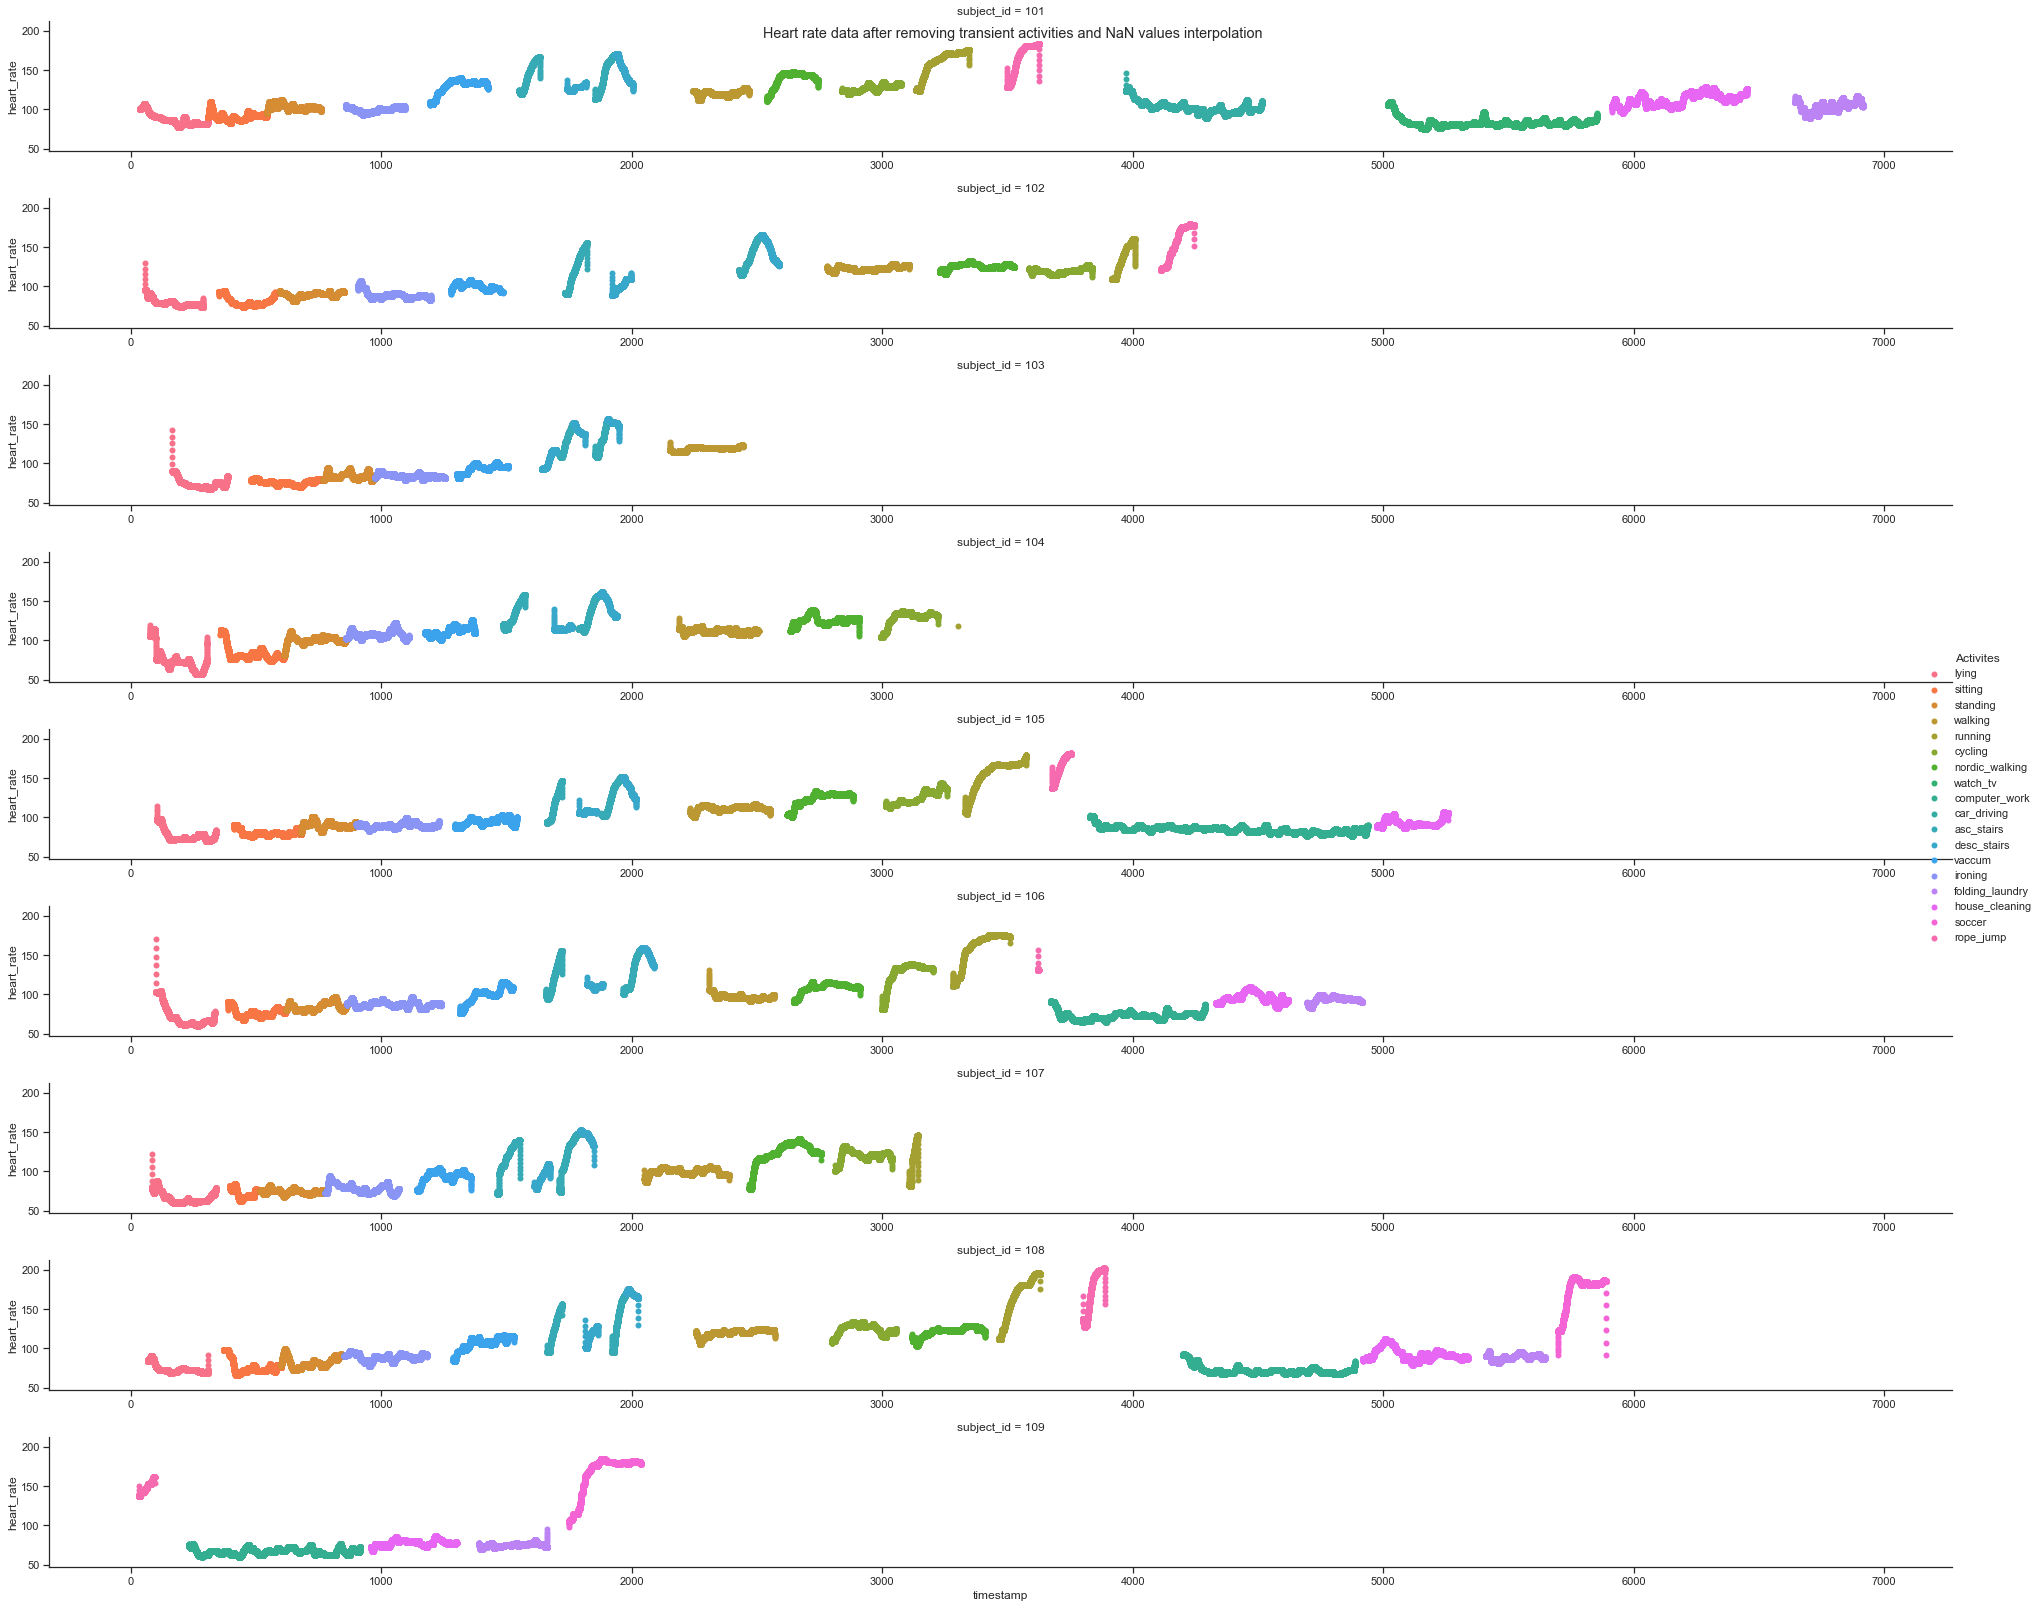

In [281]:
plot_all_data(fixed_data, column='heart_rate', title='Heart rate data after removing transient activities and NaN values interpolation')

<h3>1.b. Data insights and our task</h3>

<h3> The task at hand</h3>
After reviewing out data we can define out task.<br/>
<b>The task at hand is an hierarchical classification task.</b><br/>
Given a measurment of the HR-monitor and the IMU sensors we want to predict what is the activity performed by the subject at that particular time frame.<br/>
We will classify segements of the time series to one of the valid activities and try to determine the activity the meaurments were taken from.

In [282]:
print(f'Total number of samples (including transient activities): {data.size}')
print(f'Total number of samples (discarding transient activities): {fixed_data.size}')
print(f'Number of columns in the tabular data: {len(fixed_data.columns)}')
print(f'Unique activites in the data: {fixed_data.activity_id.unique().size}')
print(f'Number of subjects in the data: {fixed_data.subject_id.unique().size}')

Total number of samples (including transient activities): 211777775
Total number of samples (discarding transient activities): 149872415
Number of columns in the tabular data: 55
Unique activites in the data: 18
Number of subjects in the data: 9


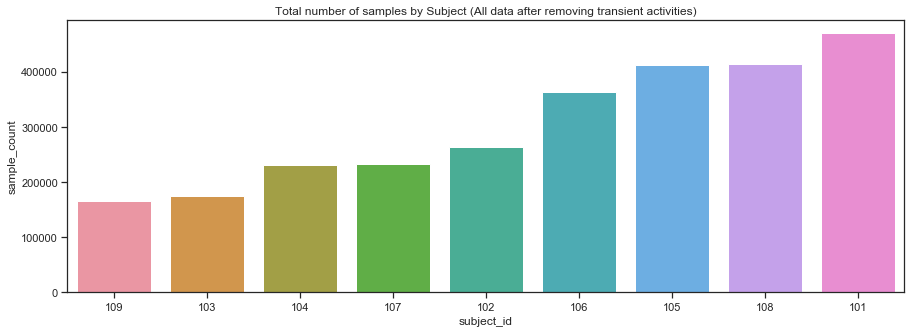

In [46]:
plot_data = fixed_data.groupby(['subject_id']).count().reset_index()[['subject_id', 'timestamp']]
plot_data = plot_data.sort_values(by=['timestamp'], ascending=True)
plot_data.rename({'timestamp': 'sample_count'}, axis=1, inplace=True)
plot_multi_bar_diagram(plot_data, x='subject_id', y='sample_count', title='Total number of samples by Subject (All data after removing transient activities)', order=True)

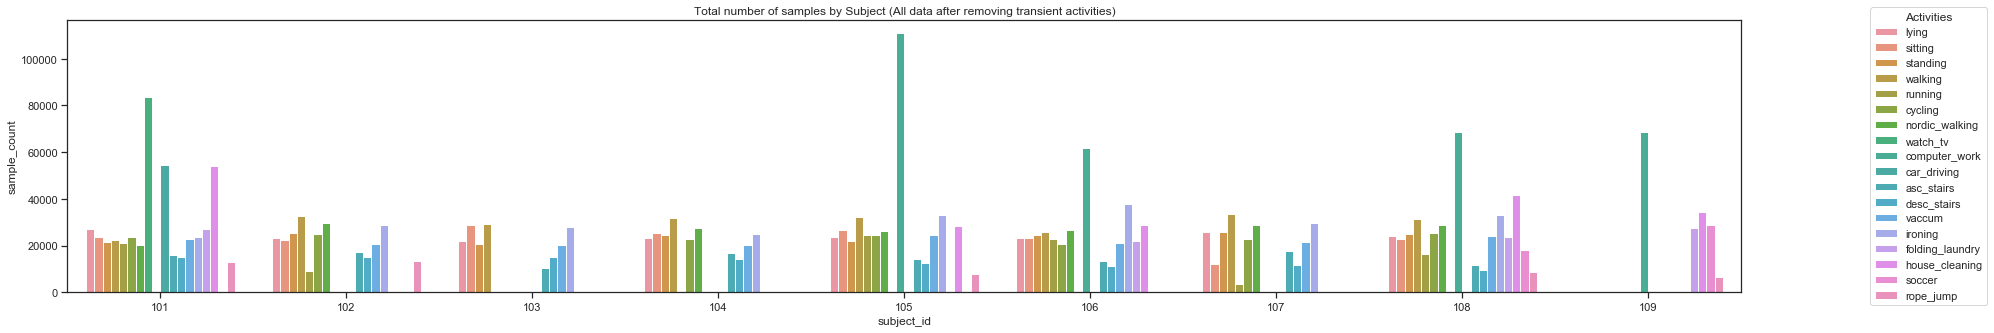

In [47]:
plot_data = fixed_data.groupby(['subject_id', 'activity_id']).count().reset_index()[['subject_id', 'timestamp', 'activity_id']]
plot_data.rename({'timestamp': 'sample_count'}, axis=1, inplace=True)
plot_multi_bar_diagram(plot_data, x='subject_id', y='sample_count', hue='activity_id', title='Total number of samples by Subject (All data after removing transient activities)', size_mult=2, legend_title='Activities')

In [92]:
activity_id_subject_count = fixed_data.replace({'activity_id': activity_id_map})
pd.crosstab(activity_id_subject_count.subject_id, activity_id_subject_count.activity_id)

activity_id  asc_stairs  car_driving  computer_work  cycling  desc_stairs  \
subject_id                                                                  
101               15890        54519              0    23575        14899   
102               17342            0              0    25108        15213   
103               10389            0              0        0        15275   
104               16694            0              0    22699        14285   
105               14281            0         110883    24577        12727   
106               13291            0          61777    20486        11272   
107               17646            0              0    22680        11618   
108               11683            0          68725    25475         9655   
109                   0            0          68550        0            0   

activity_id  folding_laundry  house_cleaning  ironing  lying  nordic_walking  \
subject_id                                                                     
101                    27114           54089    23573  27187           20265   
102                        0               0    28880  23430           29739   
103                        0               0    27975  22044               0   
104                        0               0    24995  23047           27533   
105                        0           28488    33034  23699           26271   
106                    21786           28714    37744  23340           26686   
107                        0               0    29499  25611           28725   
108                    23650           41691    32990  24165           28888   
109                    27328           34206        0      0               0   

activity_id  rope_jump  running  sitting  soccer  standing  vaccum  walking  \
subject_id                                                                    
101              12912    21265    23480       0     21717   22941    22253   
102              13262     9238    22345       0     25576   20683    32533   
103                  0        0    28761       0     20533   20325    29036   
104                  0        1    25492       0     24706   20037    31932   
105               7733    24646    26864       0     22132   24445    32033   
106                256    22825    23041       0     24356   21078    25721   
107                  0     3692    12282       0     25751   21552    33720   
108               8806    16532    22923   18126     25160   24292    31533   
109               6391        0        0   28789         0       0        0   

activity_id  watch_tv  
subject_id             
101             83646  
102                 0  
103                 0  
104                 0  
105                 0  
106                 0  
107                 0  
108                 0  
109                 0

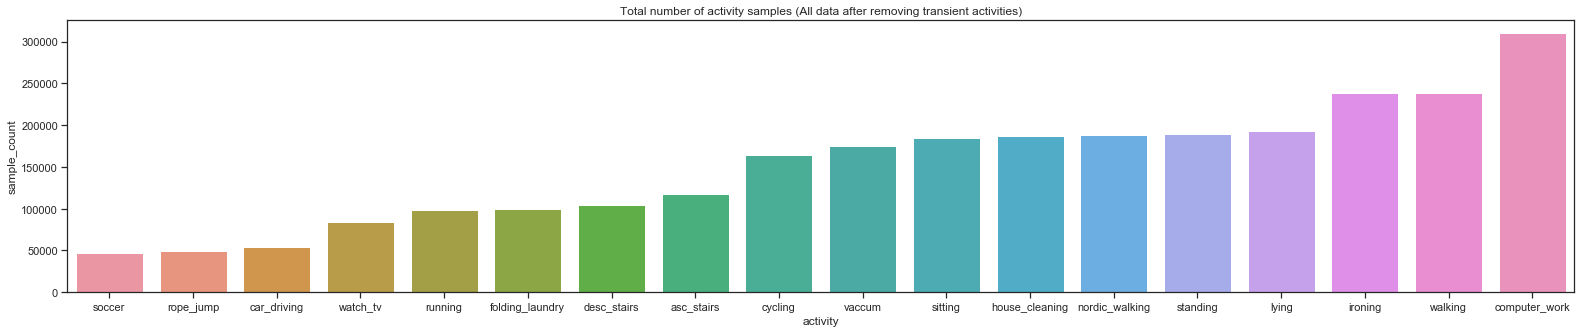

In [48]:
plot_data = fixed_data.groupby(['activity_id']).count().reset_index()[['timestamp','activity_id']]
plot_data = plot_data.sort_values(by=['timestamp'], ascending=True)
plot_data.rename({'timestamp': 'sample_count'}, axis=1, inplace=True)
plot_data.rename({'activity_id': 'activity'}, axis=1, inplace=True)
plot_data.replace({'activity': activity_id_map}, inplace=True)
plot_multi_bar_diagram(plot_data, x='activity', y='sample_count', title='Total number of activity samples (All data after removing transient activities)', size_mult=1.8, order=True)

In [49]:
# Show total activity time per subject

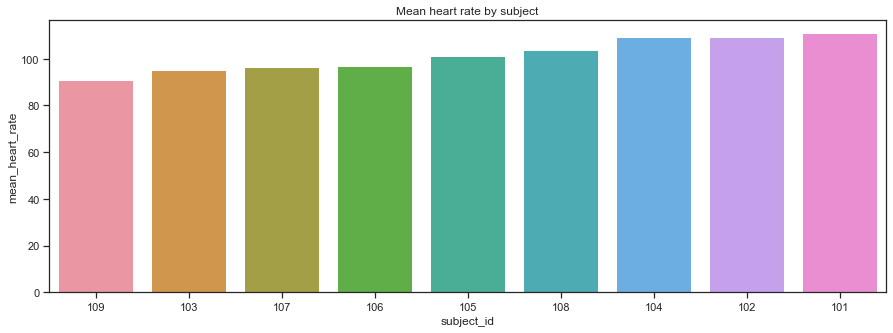

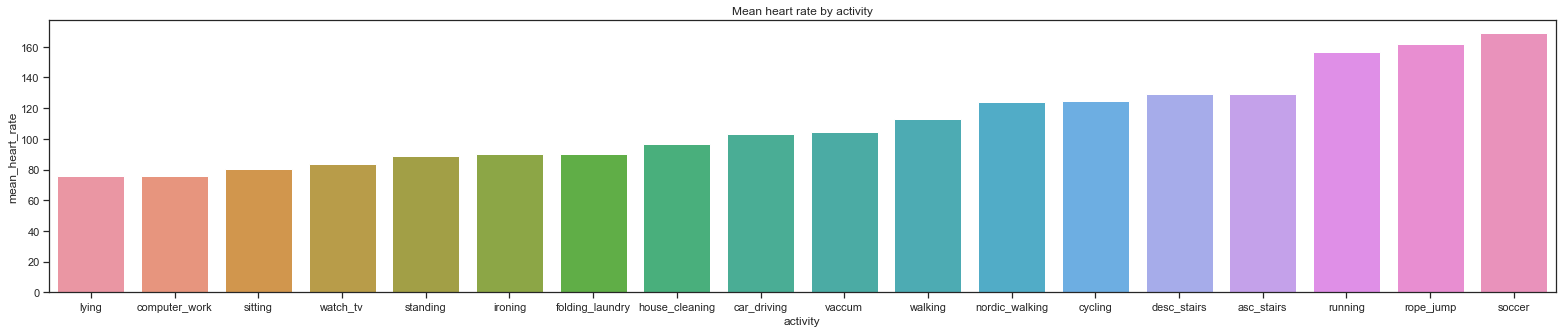

In [50]:
plot_data = fixed_data.groupby(['subject_id']).mean().reset_index()[['subject_id', 'heart_rate']]
plot_data = plot_data.sort_values(by=['heart_rate'], ascending=True)
plot_data.rename({'heart_rate': 'mean_heart_rate'}, axis=1, inplace=True)
plot_multi_bar_diagram(plot_data, x='subject_id', y='mean_heart_rate', title='Mean heart rate by subject', order=True)
plot_data = fixed_data.groupby(['activity_id']).mean().reset_index()[['activity_id', 'heart_rate']]
plot_data = plot_data.sort_values(by=['heart_rate'], ascending=True)
plot_data.rename({'heart_rate': 'mean_heart_rate'}, axis=1, inplace=True)
plot_data.rename({'activity_id': 'activity'}, axis=1, inplace=True)
plot_data.replace({'activity': activity_id_map}, inplace=True)
plot_multi_bar_diagram(plot_data, x='activity', y='mean_heart_rate', title='Mean heart rate by activity', size_mult=1.8, order=True)

<h4>Ankle IMU acceleration measurments across activities</h4>

C:\Users\Itay Bouganim\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


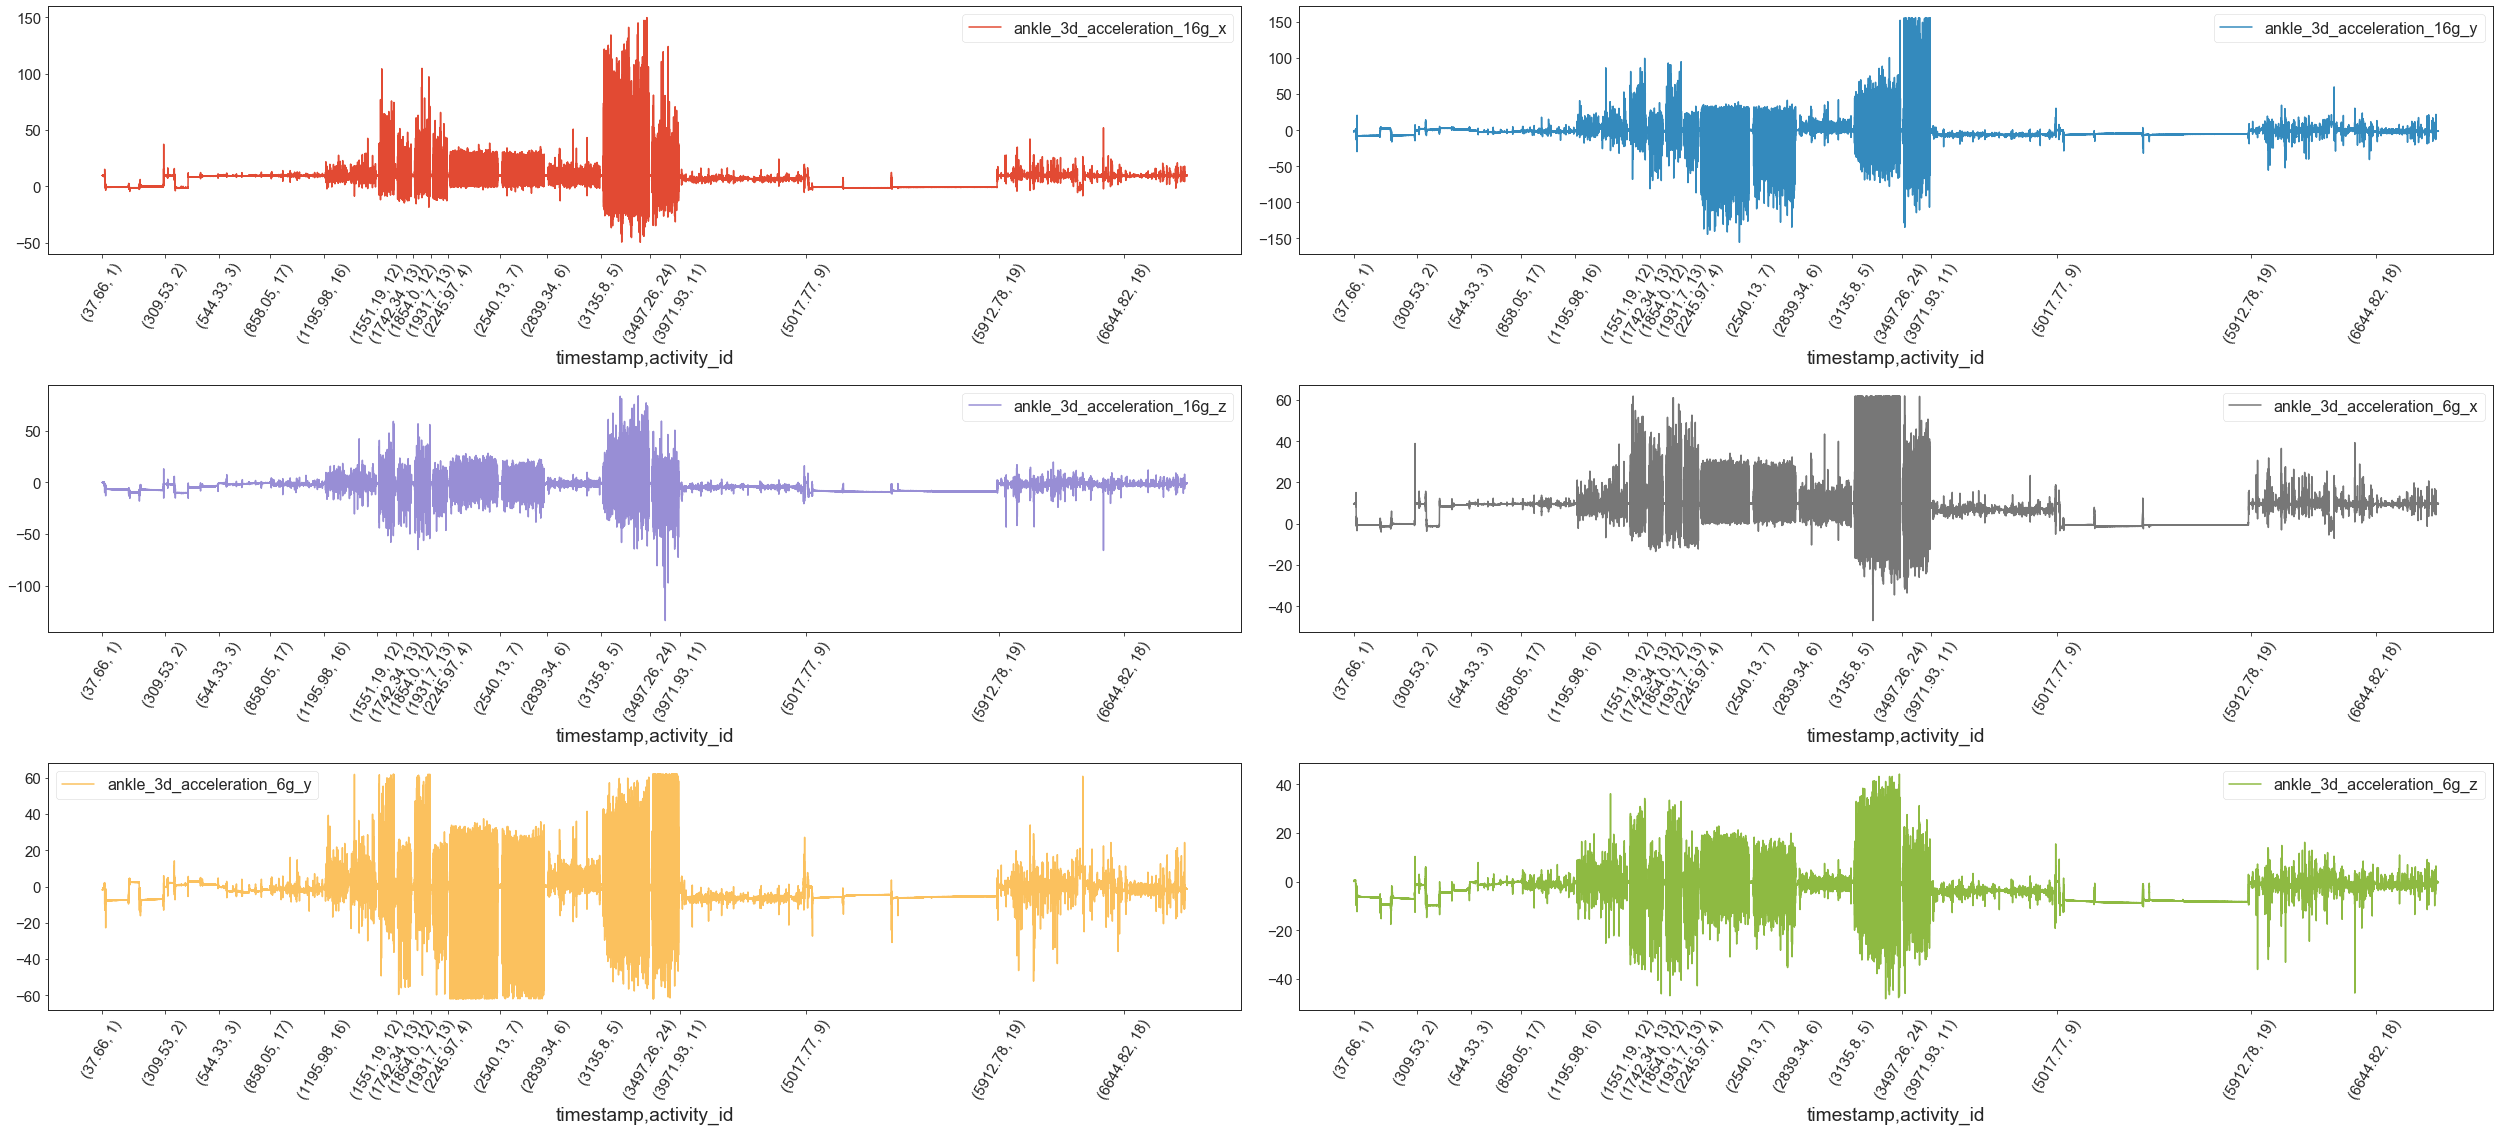

In [390]:
sample_subject = fixed_data[fixed_data.subject_id == 101]
fig = plt.figure(figsize=(35,16))
activities = list(sample_subject['activity_id'])
activity_start = [0] + [i for i, activity_id in enumerate(activities) if activities[i - 1] != activities[i]][1:] 
ankle_plot = sample_subject.set_index(['timestamp', 'activity_id'])[['ankle_3d_acceleration_16g_x', 'ankle_3d_acceleration_16g_y', 'ankle_3d_acceleration_16g_z', 'ankle_3d_acceleration_6g_x', 'ankle_3d_acceleration_6g_y', 'ankle_3d_acceleration_6g_z']]
ax = plt.gca()
ankle_plot.plot(subplots=True, layout=(3,2), ax=ax, xticks=activity_start, rot=60, fontsize=15)
fig.tight_layout()

<h4>We will take a further look how our data changes across different types of activities</h4>
<b>In order to demonstrate we will choose the columns that are related to hand IMU sensors

In [453]:
hand_dataset = fixed_data.loc[fixed_data.subject_id == 102][['timestamp', 'activity_id', 'hand_temperature', 'hand_3d_acceleration_16g_x', 'hand_3d_acceleration_6g_x', 'hand_3d_gyroscope_x', 'hand_3d_magnetometer_x', 'hand_orientation_0']]

# get - lying(1), sitting(2), running(5), cycling(6), ascending stairs(12), vacuum cleaning(16)
def prep_df(df):
    new_df = df.copy().reset_index()
    new_df.drop('index', axis=1, inplace=True)
    return new_df

lying = prep_df(hand_dataset.loc[hand_dataset['activity_id'] == 1])
sit = prep_df(hand_dataset.loc[hand_dataset['activity_id'] == 2])
run = prep_df(hand_dataset.loc[hand_dataset['activity_id'] == 5])
cycle = prep_df(hand_dataset.loc[hand_dataset['activity_id'] == 6])
asc_stairs = prep_df(hand_dataset.loc[hand_dataset['activity_id'] == 12])
vac = prep_df(hand_dataset.loc[hand_dataset['activity_id'] == 16])

print(f"Lying hand data size(Subject 102): ", len(lying))
print(f"Sitting hand data size(Subject 102): ", len(sit))
print(f"Running hand data size(Subject 102): ", len(run))
print("Cycling cleaning hand data size(Subject 102): ", len(cycle))
print(f"Ascending Stairs hand data size(Subject 102): ", len(asc_stairs))
print("Vaccum cleaning hand data size(Subject 102): ", len(vac))

Lying hand data size(Subject 102):  23430
Sitting hand data size(Subject 102):  22345
Running hand data size(Subject 102):  9238
Cycling cleaning hand data size(Subject 102):  25108
Ascending Stairs hand data size(Subject 102):  17342
Vaccum cleaning hand data size(Subject 102):  20683


In [109]:
def IMU_plotter(df):
    fig = plt.figure(figsize=(28,10))
    ax = plt.gca()
    col_list = ['hand_temperature', 'hand_3d_acceleration_16g_x', 'hand_3d_acceleration_6g_x', 'hand_3d_gyroscope_x', 'hand_3d_magnetometer_x', 'hand_orientation_0']
    plot = df.set_index(['timestamp'])[['hand_temperature', 'hand_3d_acceleration_16g_x', 'hand_3d_acceleration_6g_x', 'hand_3d_gyroscope_x', 'hand_3d_magnetometer_x', 'hand_orientation_0']]
    plot.plot(subplots=True, layout=(3,2), ax=ax, rot=0, fontsize=15)
    ttl = ax.title
    fig.tight_layout()
    plt.show()

<h4>Lying activity hand IMU sensors</h4>

C:\Users\Itay Bouganim\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


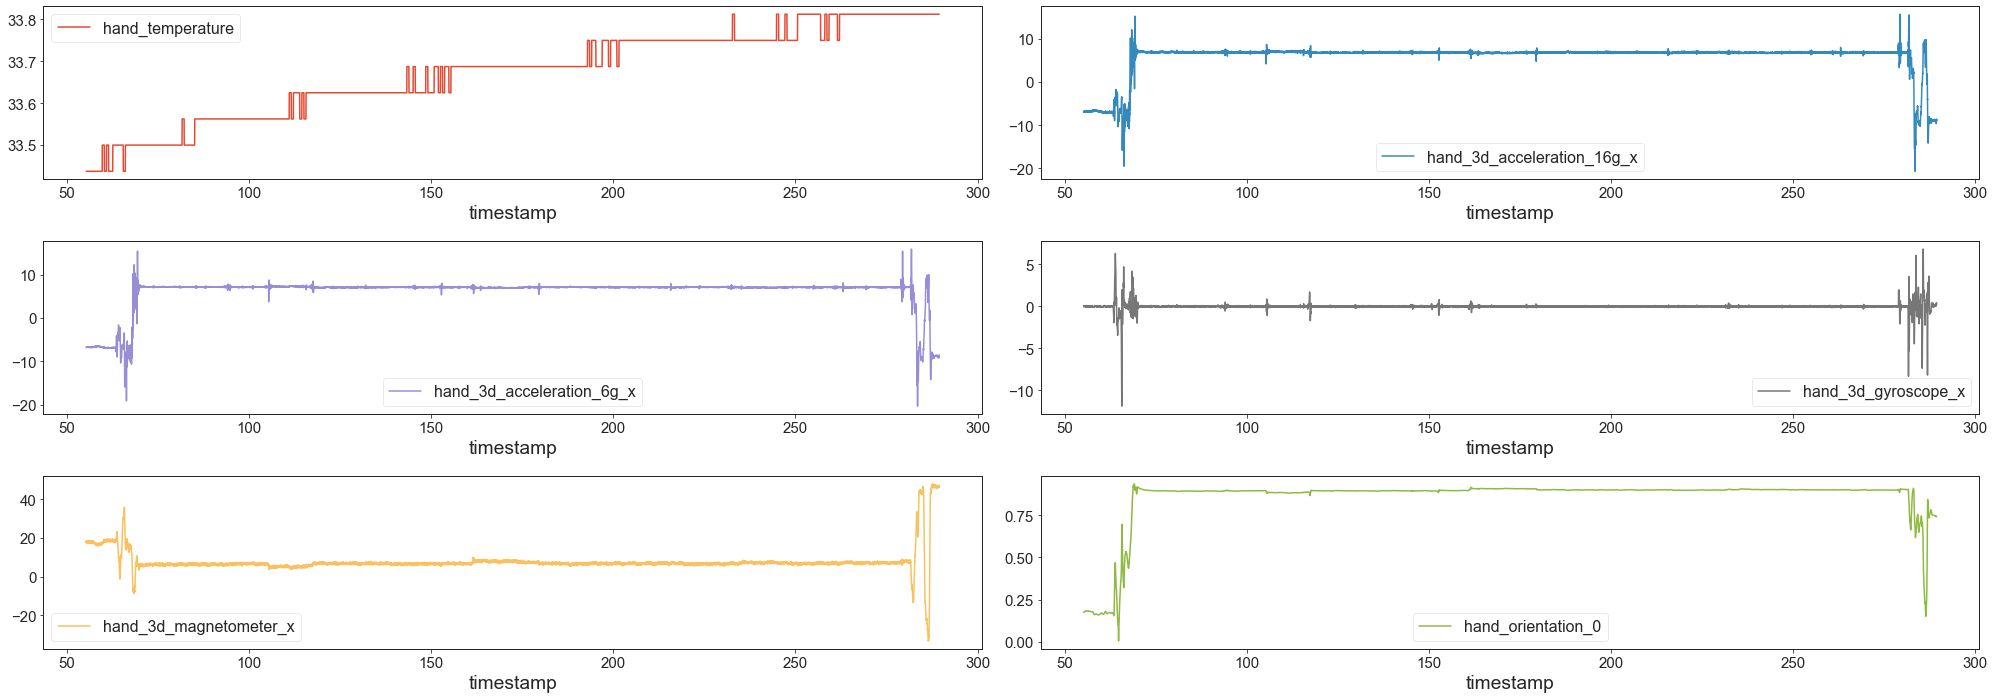

In [455]:
IMU_plotter(lying)

<h4>Sitting activity hand IMU sensors</h4>

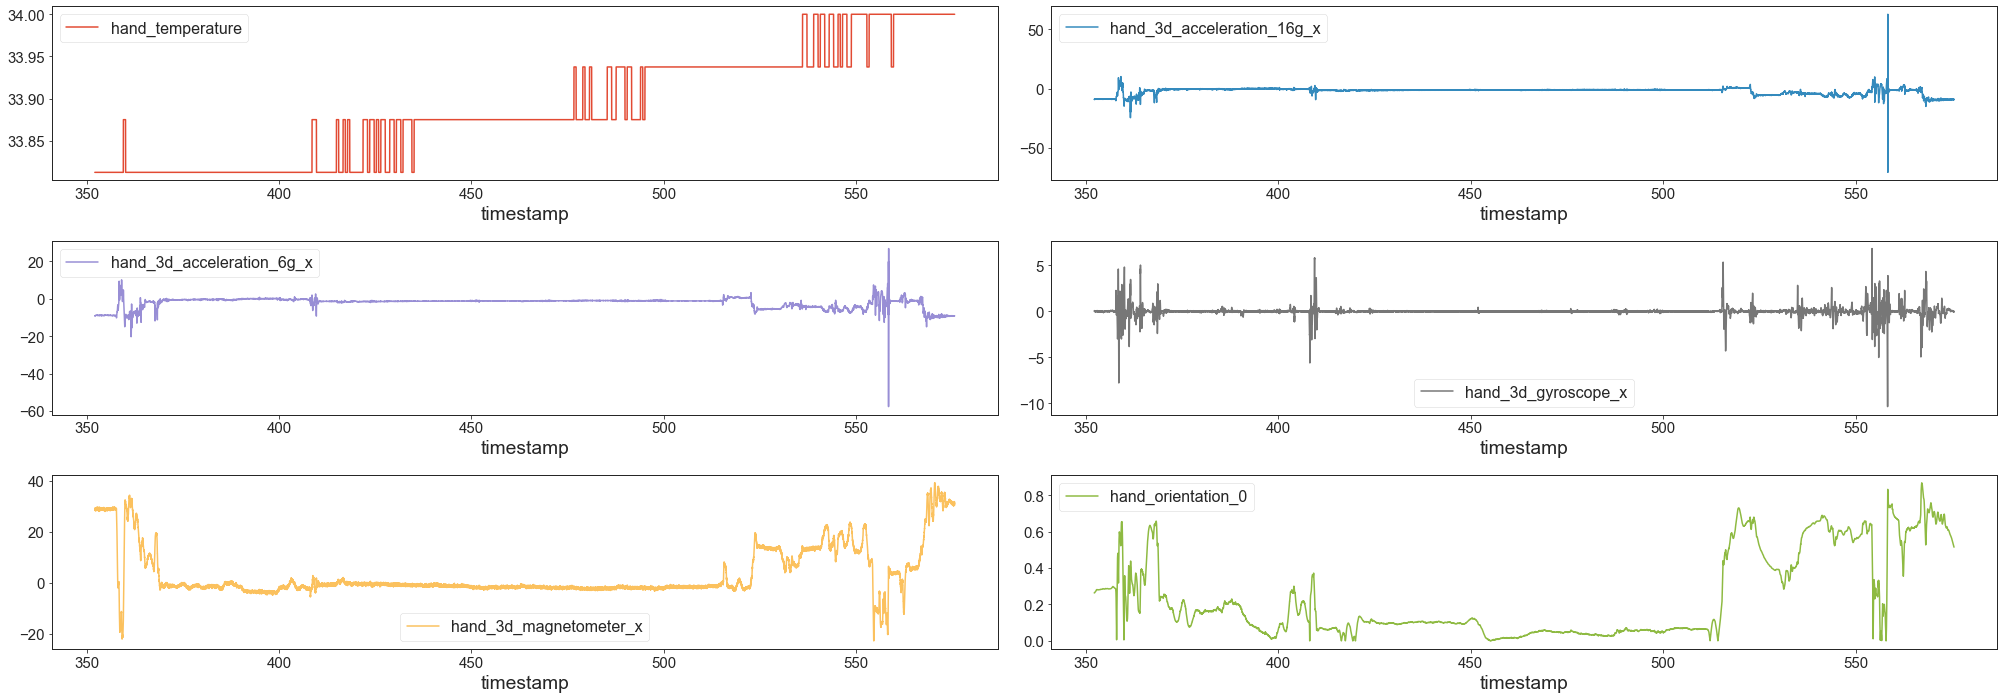

In [456]:
IMU_plotter(sit)

<h4>Running activity hand IMU sensors</h4>

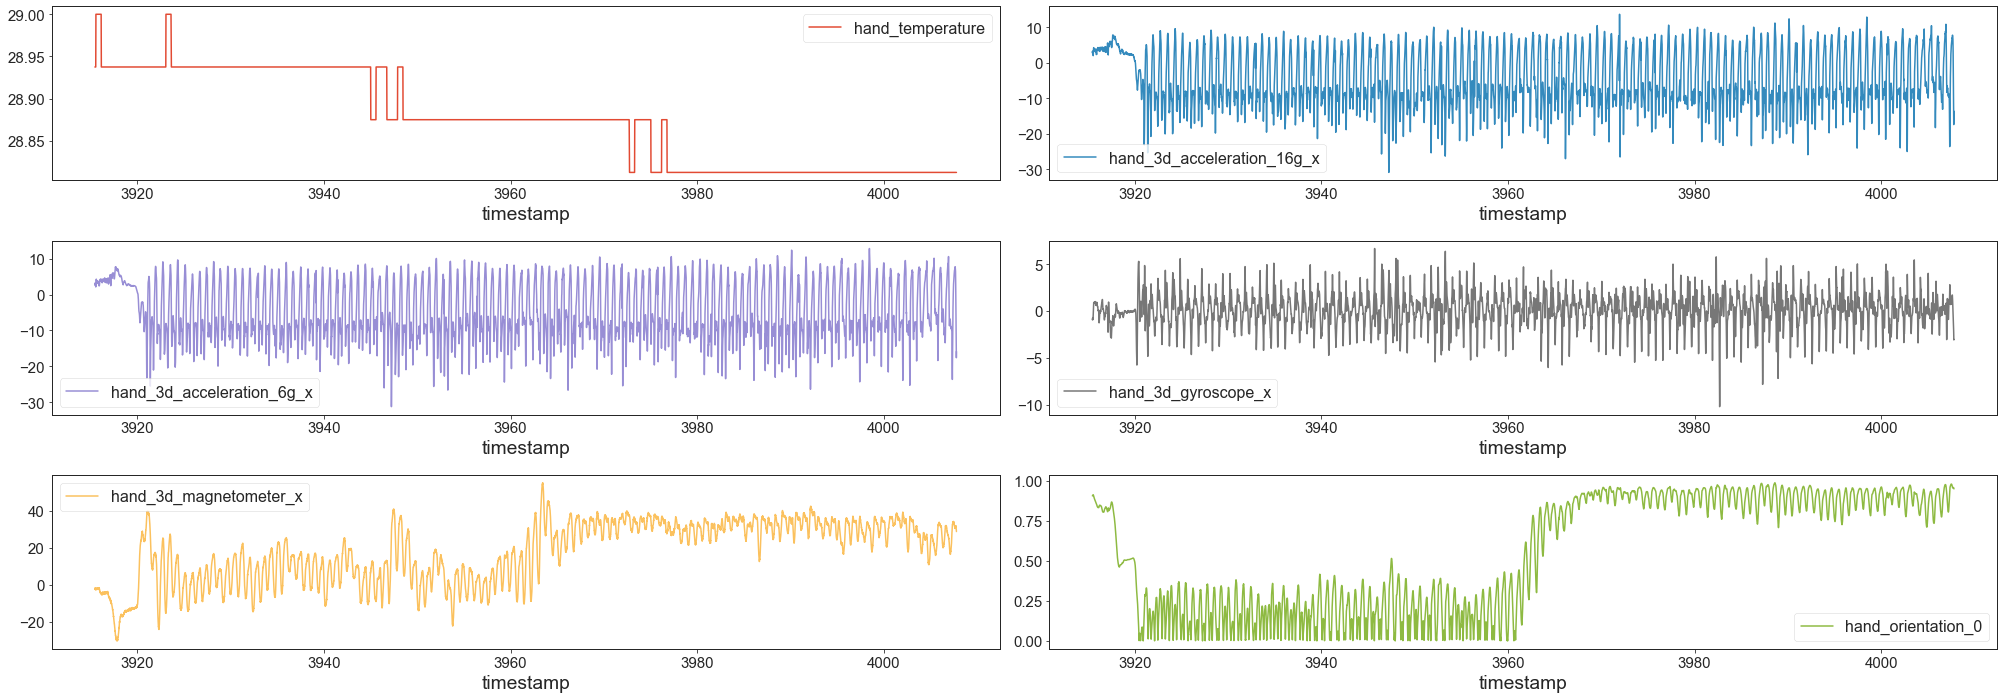

In [457]:
IMU_plotter(run)

<h4>Cycle activity hand IMU sensors</h4>

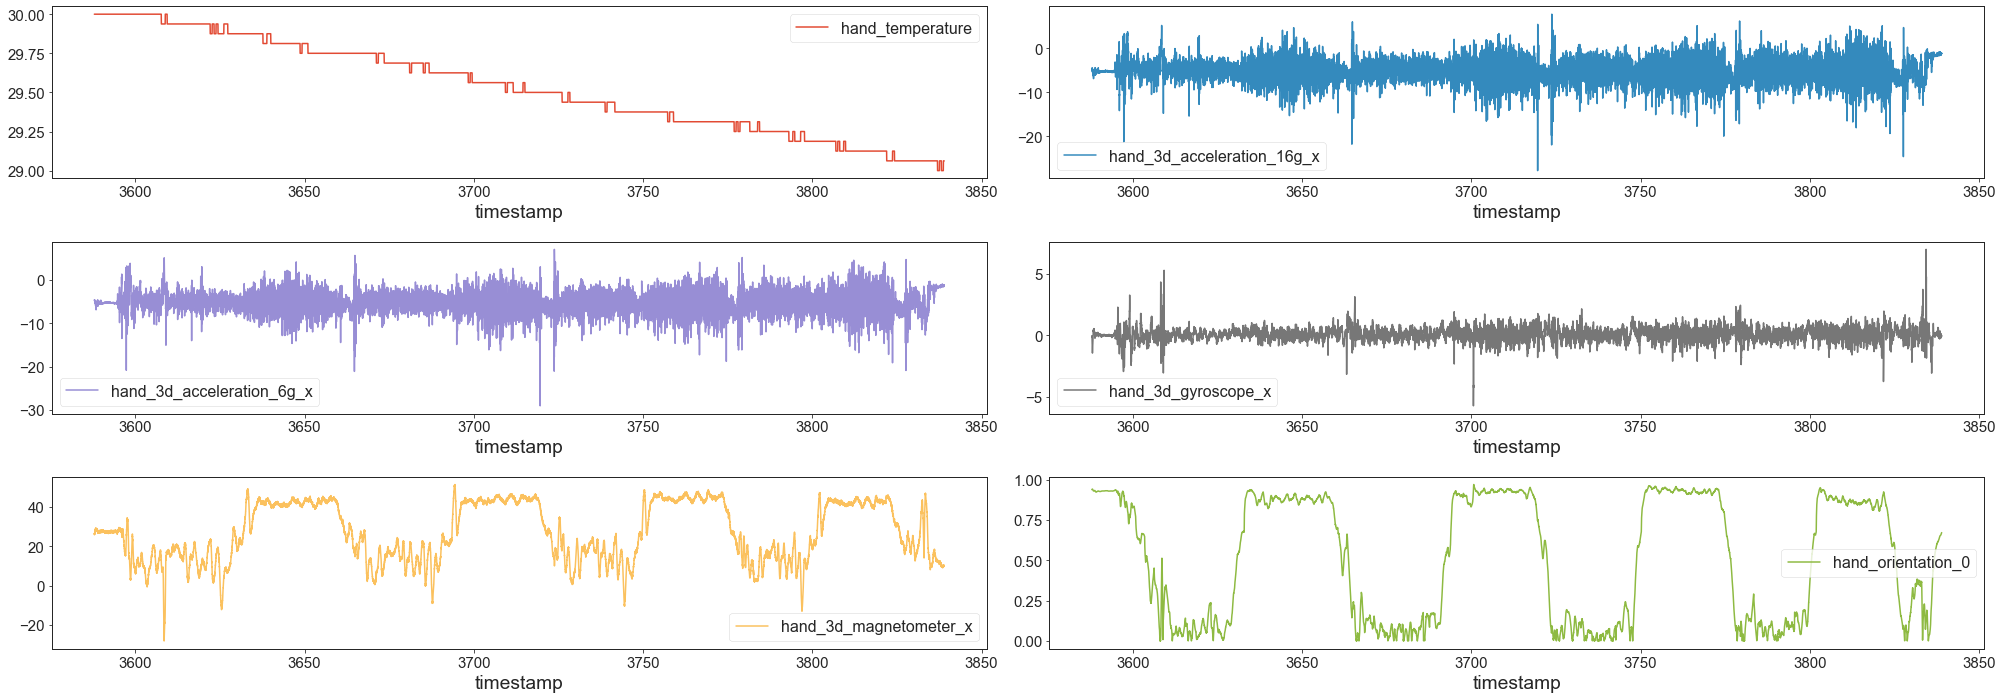

In [458]:
IMU_plotter(cycle)

<h4>Acsending Stairs activity hand IMU sensors</h4>

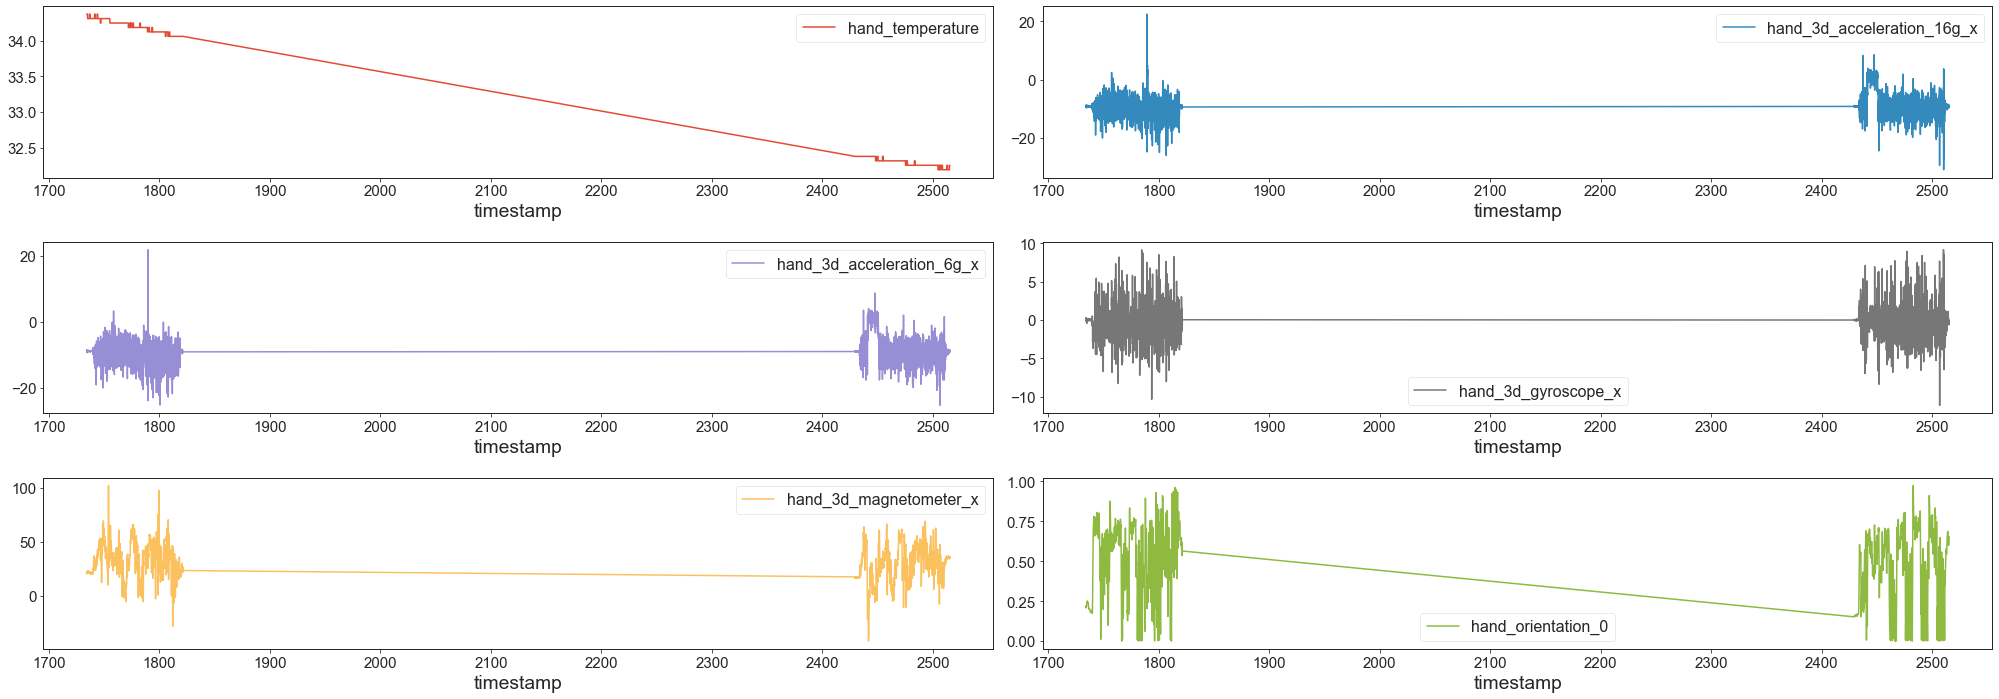

In [459]:
IMU_plotter(asc_stairs)

<h4>Vaccum Cleaning activity hand IMU sensors</h4>

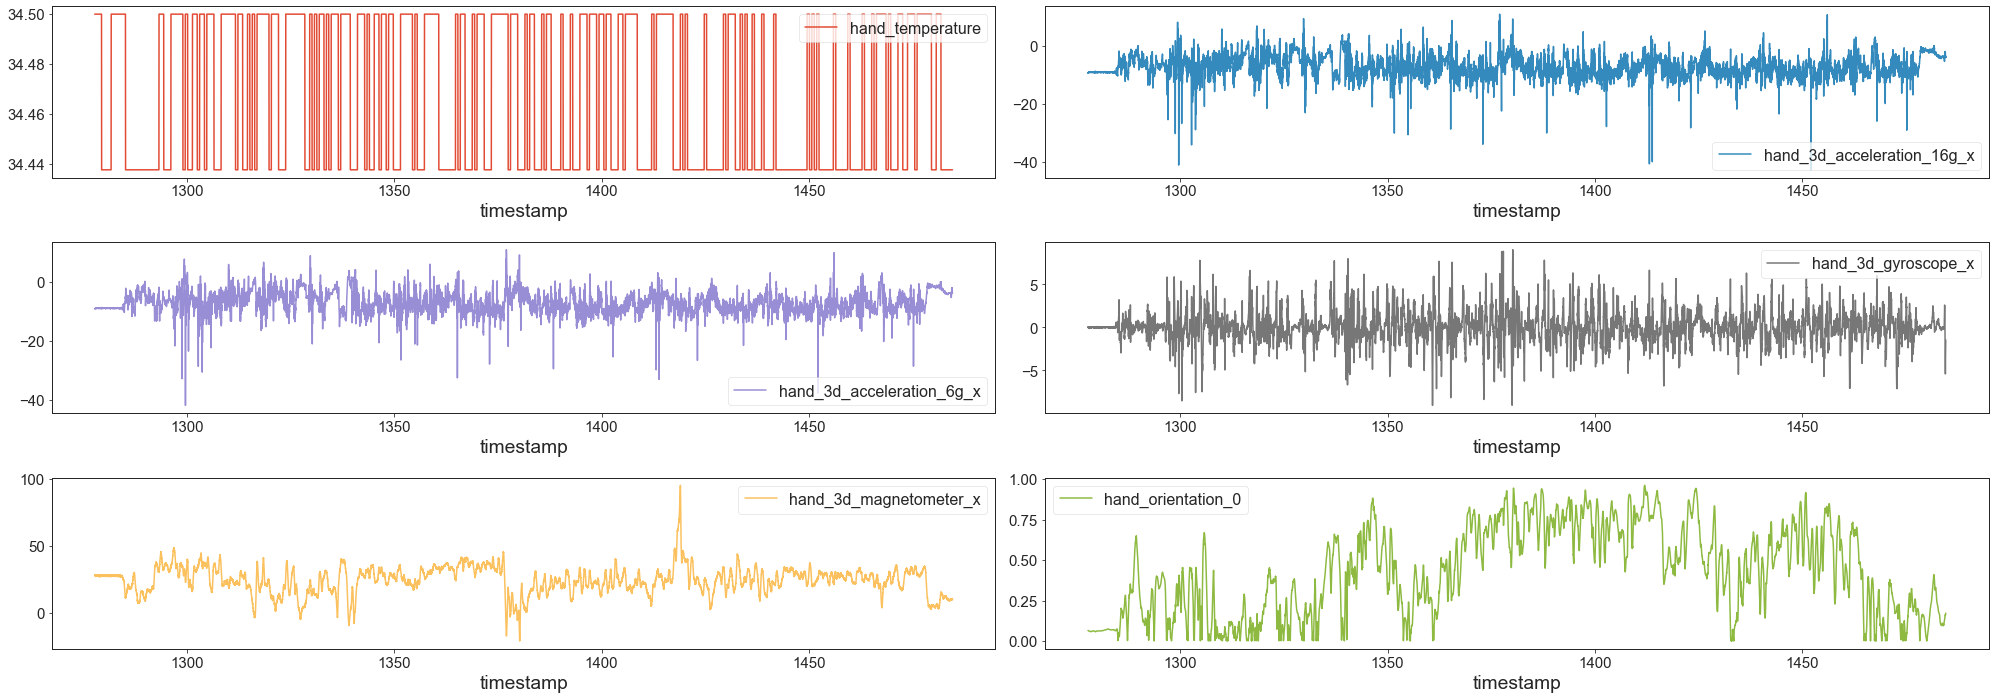

In [460]:
IMU_plotter(vac)

<h3>1.c. Self-Supervised tasks suggestions</h3>
We can perform multiple self-suprvised task on the data to gain further insights.<br/>
<br/>
<b>Self-supervised task suggestions:</b>
<ul>
    <li>Forecasting the next heart-rate(HR) measurment according to the full measurments taken in a timeframe of x measurments samples.
    <li>Predicting the median measurments according to past measurments time frame and future measurments time frame</li>
    <li>Predicting past measurment according to future measurments time frame</li>
</ul>

<h4>Save loaded subject data to CSV to make it easier to read later</h4>

In [35]:
fixed_data.to_csv(join(data_dir, "subject_data.csv"), index=False)

In [51]:
fixed_data = pd.read_csv(join(data_dir, "subject_data.csv"))

<h2>Data Balance Analysis</h2>

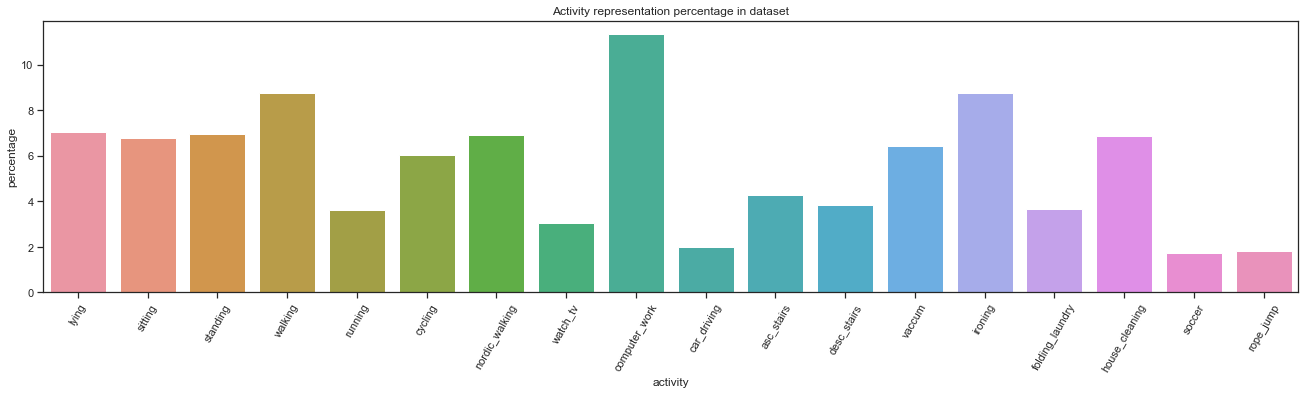

In [49]:
activity_samples_plot_data = fixed_data.groupby(['activity_id']).count().reset_index()[['timestamp', 'activity_id']]
total_samples = int(fixed_data.groupby(['activity_id']).count().sum()[['timestamp']].astype(int))
activity_samples_plot_data['timestamp'] = activity_samples_plot_data['timestamp'].apply(lambda count: (count / total_samples) * 100)
activity_samples_plot_data['activity_id'] = activity_samples_plot_data['activity_id'].apply(lambda activity_id: activity_id_map[activity_id])
activity_samples_plot_data.rename({'timestamp': 'percentage'}, axis=1, inplace=True)
activity_samples_plot_data.rename({'activity_id': 'activity'}, axis=1, inplace=True)
plot_multi_bar_diagram(activity_samples_plot_data, x='activity', y='percentage', title='Activity representation percentage in dataset', size_mult=1.5, label_rotation=60)

<h4>Check if the data is balanced using Shannon Entropy</h4>
Although we can see from the chart above that we have variation between the representation precentage of the different classes in the dataset, we will use <b>Shannon Entropy</b> to calculate the imbalance.<br/>
In information theory, <b>Shannon Entropy</b> is an estimation of the average amount of information stored in a random variable.<br/>
For example, an unbiased coin flip contains 1 bit of information with each result. The entropy of a random variable can be estimated from a series of results.
<br/><br/>
The entropy value meaning is:
<ul>
    <li>0 when there is one single class. In other words, it tends to 0 when your data set is very unbalanced</li>
    <li>logk when all your classes are balanced of the same size nk</li>
</ul>

Therefore, dividing the entropy by logk, where k is the number of classes will give us a measurment for balance where:
<ul>
<li>0 for a unbalanced data set</li>
 <li>1 for a balanced data set</li>
</ul>


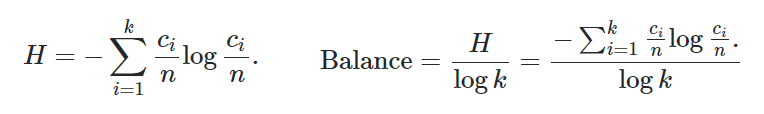

In [50]:
display_image('entropy.png')

In [51]:
from scipy.stats import entropy
import math

balance_check = pd.Series(fixed_data['activity_id'])
counts = balance_check.value_counts()

def calculate_entropy(counts):
    H = entropy(counts)
    print(f'Entropy value H: {H :.6f}')
    balance = H / math.log(len(set(activity_id_map.keys() - set([0]))))
    print(f'Balance value: {balance :.6f}')
    print(f'Balance percentage: {balance * 100:.4f}%')

calculate_entropy(counts)

Entropy value H: 2.773562
Balance value: 0.959586
Balance percentage: 95.9586%


<h5>We can see that the data is generally balanced, no further action needed</h5>

<h4>Calculate mean sample count from each activity for test subjects and train/valid subjects</h4> + Show missing activities<br/>Activity window segments in train and validation come from the same subject set ({101, 102, 103, 104, 105, 106, 109})

In [125]:
def map_class(data):
    activity_ids = data.activity_id.unique()
    activity_ids.sort()
    activity_labels = [activity_id_map[i] for i in activity_ids]
    activity_id_to_index = {activity_ids[i]: i for i in range(len(activity_ids))}
    index_to_activity_id = {i: activity_ids[i] for i in range(len(activity_ids))}
    return activity_labels, activity_id_to_index, index_to_activity_id

In [126]:
activity_labels, activity_id_to_index, index_to_activity_id = map_class(fixed_data)
activity_count = len(activity_labels)

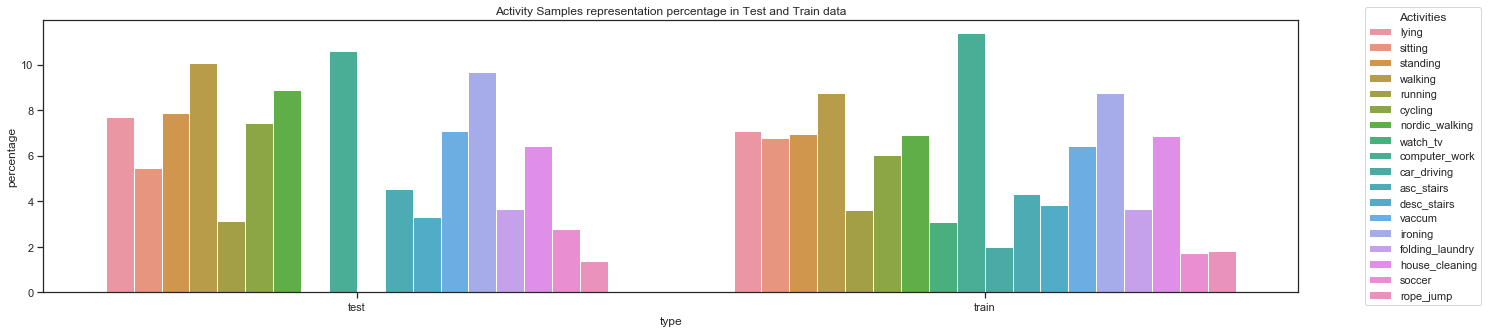

In [54]:
test_plot_data = fixed_data.loc[(fixed_data['subject_id'] == 107) | (fixed_data['subject_id'] == 108)].groupby(['activity_id']).count().reset_index()[['timestamp', 'activity_id']]
total_samples = int(fixed_data.loc[(fixed_data['subject_id'] == 107) | (fixed_data['subject_id'] == 108)].groupby(['activity_id']).count().sum()[['timestamp']].astype(int))
test_plot_data['timestamp'] = test_plot_data['timestamp'].apply(lambda count: (count / total_samples) * 100)

train_plot_data = fixed_data.loc[(fixed_data['subject_id'] != 107) | (fixed_data['subject_id'] != 108)].groupby(['activity_id']).count().reset_index()[['timestamp', 'activity_id']]
total_samples = int(fixed_data.loc[(fixed_data['subject_id'] != 107) | (fixed_data['subject_id'] != 108)].groupby(['activity_id']).count().sum()[['timestamp']].astype(int))
train_plot_data['timestamp'] = train_plot_data['timestamp'].apply(lambda count: (count / total_samples) * 100)

test_plot_data['type'] = 'test'
train_plot_data['type'] = 'train'
plot_data = test_plot_data.append(train_plot_data)

plot_data.rename({'timestamp': 'percentage'}, axis=1, inplace=True)
plot_multi_bar_diagram(plot_data, x='type', y='percentage', hue='activity_id', title='Activity Samples representation percentage in Test and Train data', size_mult=1.5, legend_title='Activities')

<h4>We can also observe that the train samples taken from the train subject does not have any representation for the dollowing activities:</h4>

In [55]:
missing_test_activities = [activity_id_map[i] for i in list(set(train_plot_data['activity_id'].unique()) - set(test_plot_data['activity_id'].unique()))]
pprint(missing_test_activities)

['watch_tv', 'car_driving']


In [56]:
balance_check_test = pd.Series(fixed_data.loc[(fixed_data['subject_id'] == 107) | (fixed_data['subject_id'] == 108)]['activity_id'])
counts_test = balance_check_test.value_counts()

balance_check_train = pd.Series(fixed_data.loc[(fixed_data['subject_id'] != 107) & (fixed_data['subject_id'] != 108)]['activity_id'])
counts_train = balance_check_train.value_counts()

print('Train data balance statistics:\n===========================')
calculate_entropy(counts_train)

print('\nTest data balance statistics:\n===========================')
calculate_entropy(counts_test)

Train data balance statistics:
Entropy value H: 2.784208
Balance value: 0.963270
Balance percentage: 96.3270%

Test data balance statistics:
Entropy value H: 2.664299
Balance value: 0.921784
Balance percentage: 92.1784%


<h5>We can see that the testing data we use is less balanced than the training data</h5>

<h4>Classification Problem</h4>
<b>The problem we wish to address is the classification of consecutive time windows to the activity that was performed in this time segment.</b><br/>
We will use the Sliding window technique with a window look back value of 200.<br/>
Since data was measured and interpolated to fit the measurment rate of 100Hz, meaining measurment every 0.01 second,<br/>
all window segments will contain 2 seconds of data measurments.<br/>
For each of the 2 seconds HR-monitor and IMU sensors measurments we wish to determine what was the activity that produced those measurments (undependent of the performing subject).

hirerchal classification - activities - windows where there is one action - we want to predict the current activity 100hz we want 150-200 timepoint window - maybe interpolate + describe dataframe

<h3>2.a. Preprocessing steps and Validation Strategy</h3>
<h3>Preprocessing steps</h3>
<ul>
    <li>We will segment our data into individual activities while ignoring the subject ID that performed that activity.<br/>
    This operation will result in lists of timeframes each one belong to specific activity.<br/>We will segments all the activities from each subject.</li>
    <li>For every subject we will:
        <ul>
        <li>Ignore the following columns: subject_id, activity_id, timestamp.<br/>
            We want to ignore those columns from the following reasons:<br/>
            <b>subject_id</b> - The subject ID that performed that activity will not be relevant to out model and we want it to generalize for every subject.<br/>
            <b>activity_id</b> - This is the perdiction we want out model to eventually conclude on.<br/>
            <b>timestamp</b> - Since all our data is given in interval of 100Hz and contains all values after interpolation, the specific time the activity was performed in the sequence is not relevant.<br/>We only need to account for the order of the measurments within each activity and not for the time the activity was performed relative to other activities (We only perdict individual activites with no activity overlap)<br/>
        </li>
        <li>Scale the specific subject data values after removel of irelevant columns to range [0,1] using the scaler we fitted earlier on the entire data</li>
        </ul>
    </li>
    <li>We will one-hot encode our activity_id values(y)</li>
    <li>For every activity timeframe recorded in the previous step we will produce sliding windows with length 200 (2 seconds since the measurments are taken in 100Hz)</li>
    <li><b>Preprocessing output:</b> after all the steps we will get X values corresponding with timeframe windows of length 200 from a specific activity and y values that are the one-hot encoded activity if for every timeframe windows</li>
  </ul>
  
 <h3>Validation Strategy</h3>
 As a validation stategy we will use <b>stratisfied train-test split</b> in order to preserve the samples representation and include all classes in the training and validation data.<br/>
 So our validation data will be a statisfied subset of the training windows data taken from the same range of activities.<br/>
 Additionaly, we will shuffle our training, validation and testing data after divided to windows (since the internal order of the activity timeframe windows matter but not the order between different windows.

<h4>Fit a scaler to our data in order to normalize values to range [0, 1]</h4>

In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
to_scale_data = fixed_data.drop(['subject_id', 'activity_id', 'timestamp'], axis=1)
scaler.fit(to_scale_data)

scaled_data = scaler.transform(to_scale_data)
print("Scaled data summary:")
pd.DataFrame(scaled_data, columns=to_scale_data.columns, index=to_scale_data.index).describe().apply(lambda s: s.apply(lambda n: int(n) if n.is_integer() else '{0:.8f}'.format(n)))

Scaled data summary:


heart_rate hand_temperature hand_3d_acceleration_16g_x  \
count     2724953          2724953                    2724953   
mean   0.31525340       0.74732171                 0.57873793   
std    0.18891410       0.17880920                 0.02423240   
min             0                0                          0   
25%    0.17241379       0.65294118                 0.56103648   
50%    0.27586207       0.78235294                 0.58033149   
75%    0.43448276       0.87647059                 0.59442559   
max    1.00000000                1                          1   

      hand_3d_acceleration_16g_y hand_3d_acceleration_16g_z  \
count                    2724953                    2724953   
mean                  0.41211895                 0.44403539   
std                   0.02515222                 0.01524413   
min                            0                          0   
25%                   0.40223953                 0.43449640   
50%                   0.41207173                 0.44389005   
75%                   0.42468184                 0.45517639   
max                            1                          1   

      hand_3d_acceleration_6g_x hand_3d_acceleration_6g_y  \
count                   2724953                   2724953   
mean                 0.46640229                0.52768258   
std                  0.05113111                0.05128920   
min                           0                         0   
25%                  0.42933742                0.50691225   
50%                  0.46948451                0.52791893   
75%                  0.49938357                0.55411081   
max                           1                         1   

      hand_3d_acceleration_6g_z hand_3d_gyroscope_x hand_3d_gyroscope_y  ...  \
count                   2724953             2724953             2724953  ...   
mean                 0.53366625          0.51577238          0.43699004  ...   
std                  0.03401007          0.02395085          0.02313917  ...   
min                           0                   0                   0  ...   
25%                  0.51261880          0.51023891          0.43208274  ...   
50%                  0.53387231          0.51565899          0.43623605  ...   
75%                  0.55886607          0.52066592          0.44108470  ...   
max                  1.00000000                   1                   1  ...   

      ankle_3d_gyroscope_x ankle_3d_gyroscope_y ankle_3d_gyroscope_z  \
count              2724953              2724953              2724953   
mean            0.54306760           0.57075816           0.45996972   
std             0.01958875           0.01840709           0.04948880   
min                      0                    0                    0   
25%             0.54109364           0.56965686           0.45576846   
50%             0.54302888           0.57144392           0.45979319   
75%             0.54428391           0.57353722           0.46120152   
max                      1                    1           1.00000000   

      ankle_3d_magnetometer_x ankle_3d_magnetometer_y ankle_3d_magnetometer_z  \
count                 2724953                 2724953                 2724953   
mean               0.54119410              0.60399562              0.56900853   
std                0.07306979              0.09324560              0.06823810   
min                         0                       0                       0   
25%                0.49923794              0.54090448              0.52395842   
50%                0.53492784              0.59692127              0.57533478   
75%                0.59284931              0.67062705              0.62391327   
max                         1                       1                       1   

      ankle_orientation_0 ankle_orientation_1 ankle_orientation_2  \
count             2724953             2724953             2724953   
mean           0.41123383          0.46758952          0.64047953

In [53]:
def preprocess_subject_data(data, subject_id):
    to_scale_data = data.drop(['subject_id', 'activity_id', 'timestamp'], axis=1)
    scaled_data = scaler.transform(to_scale_data)
    print(f'Preprocessed data for subject {subject_id}: \n {scaled_data}\nTotal size: {len(scaled_data)}')
    return scaled_data

In [54]:
from tensorflow.keras.utils import to_categorical

def one_hot_encode_y(y):
    ymapped = np.array([activity_id_to_index[c] for c in y], dtype='int')
    ybinary = to_categorical(ymapped, len(activity_labels))
    return ybinary

def one_hot_to_index(one_hot_y):
    return np.argmax(one_hot_y)

In [55]:
def activities_segmentation(data, subject_ids, loading_title=None):
    x_lists, y_lists = [], []
    for subject_id in tqdm(subject_ids, desc=loading_title):
        subject_data = data[data.subject_id == subject_id].reset_index(drop=True)
        activity_labels = subject_data.activity_id
        subject_data = preprocess_subject_data(subject_data, subject_id)
        subject_activity_count = activity_labels.size
        startpoints = np.where([1] + [activity_labels[i] != activity_labels[i - 1] for i in range(1, subject_activity_count)])[0]
        endpoints = np.append(startpoints[1:] - 1, subject_activity_count - 1)
        subject_activities = [activity_labels[s] for s, e in zip(startpoints, endpoints)]
        xysplit = [(subject_data[start:end], activity) for start, end, activity in zip(startpoints, endpoints, subject_activities)]
        xysplit = [(X, y) for X, y in xysplit if len(X) > 0]
        x_lists.append([X for X, _ in xysplit])
        y_lists.append([y for _, y in xysplit])
    return list(chain(*x_lists)), list(chain(*y_lists))

In [56]:
x_train_lists, y_train_lists = activities_segmentation(fixed_data, subject_ids=[subject_id for subject_id in subject_ids if subject_id != 107 and subject_id != 108], loading_title="Splitting activities to X and y lists for train subjects")
x_test_lists, y_test_lists = activities_segmentation(fixed_data, subject_ids=[107, 108], loading_title="Splitting activities to X and y lists for test subjects")

Splitting activities to X and y lists for train subjects:   0%|          | 0/7 [00:00<?, ?it/s]

Preprocessed data for subject 101: 
 [[0.29655172 0.51764706 0.60168238 ... 0.49930547 0.50199225 0.50029498]
 [0.29655172 0.51764706 0.6019765  ... 0.49930547 0.50199225 0.50029498]
 [0.29655172 0.51764706 0.60197243 ... 0.49930547 0.50199225 0.50029498]
 ...
 [0.32050817 0.91176471 0.60603849 ... 0.49930547 0.50199225 0.50029498]
 [0.31833031 0.91176471 0.60629359 ... 0.49930547 0.50199225 0.50029498]
 [0.31615245 0.91176471 0.60571982 ... 0.49930547 0.50199225 0.50029498]]
Total size: 469325


Splitting activities to X and y lists for train subjects:  14%|█▍        | 1/7 [00:07<00:42,  7.02s/it]

Preprocessed data for subject 102: 
 [[0.49973475 0.80588235 0.56677885 ... 0.8949418  0.45782046 0.82452069]
 [0.4535809  0.80588235 0.56691049 ... 0.89494702 0.45783607 0.82451467]
 [0.40742706 0.80588235 0.56644579 ... 0.89498824 0.45783509 0.82446751]
 ...
 [0.76827586 0.34705882 0.61817068 ... 0.90142631 0.47623725 0.81803324]
 [0.70896552 0.34705882 0.617419   ... 0.9014357  0.47594289 0.81799912]
 [0.64965517 0.34705882 0.61724013 ... 0.90137622 0.47563015 0.81805079]]
Total size: 263349


Splitting activities to X and y lists for train subjects:  29%|██▊       | 2/7 [00:10<00:30,  6.02s/it]

Preprocessed data for subject 103: 
 [[0.59034483 0.57647059 0.58769255 ... 0.48711401 0.87347864 0.49672326]
 [0.53103448 0.57647059 0.58714138 ... 0.48779371 0.87364861 0.49710048]
 [0.47172414 0.57647059 0.5859641  ... 0.48871523 0.87381343 0.49755311]
 ...
 [0.44827586 0.35882353 0.58803597 ... 0.12361838 0.59265514 0.17719298]
 [0.44827586 0.35882353 0.58925231 ... 0.12403479 0.59378519 0.17672342]
 [0.43824451 0.35882353 0.5887052  ... 0.12438805 0.59478646 0.17628247]]
Total size: 174338


Splitting activities to X and y lists for train subjects:  43%|████▎     | 3/7 [00:13<00:19,  4.95s/it]

Preprocessed data for subject 104: 
 [[0.42821317 0.71764706 0.55991962 ... 0.23118074 0.79858225 0.32879332]
 [0.41818182 0.71764706 0.55993911 ... 0.23115099 0.79860645 0.32880185]
 [0.40815047 0.71764706 0.56004715 ... 0.23120683 0.79863736 0.32881539]
 ...
 [0.46482759 0.25294118 0.55945822 ... 0.45523081 0.8521598  0.4764754 ]
 [0.44206897 0.25294118 0.55947771 ... 0.45562504 0.85221594 0.47688661]
 [0.41931034 0.24705882 0.57546307 ... 0.66908455 0.86684879 0.65839581]]
Total size: 231421


Splitting activities to X and y lists for train subjects:  57%|█████▋    | 4/7 [00:16<00:13,  4.44s/it]

Preprocessed data for subject 105: 
 [[0.39655172 0.92352941 0.55864481 ... 0.19623004 0.76699981 0.27092043]
 [0.3737931  0.92352941 0.55952705 ... 0.19628327 0.76704771 0.27093749]
 [0.35103448 0.92352941 0.5582232  ... 0.19629892 0.76706367 0.27092946]
 ...
 [0.33793103 0.92941176 0.60075989 ... 0.70973756 0.85591047 0.63427705]
 [0.30574713 0.92941176 0.60206892 ... 0.70966868 0.85579818 0.63446819]
 [0.27356322 0.92941176 0.60088136 ... 0.70988628 0.85565448 0.63474811]]
Total size: 411813


Splitting activities to X and y lists for train subjects:  71%|███████▏  | 5/7 [00:22<00:09,  4.89s/it]

Preprocessed data for subject 106: 
 [[0.78423645 0.78823529 0.5580847  ... 0.02506922 0.39304422 0.32807595]
 [0.70640394 0.78823529 0.55825432 ... 0.02511983 0.3929237  0.32791642]
 [0.62857143 0.78823529 0.55840034 ... 0.0251694  0.39281914 0.32777746]
 ...
 [0.23275862 0.78235294 0.61138837 ... 0.86177465 0.69033727 0.77518755]
 [0.23448276 0.78235294 0.61146626 ... 0.86166976 0.69045831 0.77516046]
 [0.2362069  0.78235294 0.61117321 ... 0.86165828 0.6904444  0.77514591]]
Total size: 362373


Splitting activities to X and y lists for train subjects:  86%|████████▌ | 6/7 [00:27<00:05,  5.03s/it]

Preprocessed data for subject 109: 
 [[0.64326019 0.         0.55855143 ... 0.2980833  0.86171777 0.40836396]
 [0.60438871 0.         0.55851859 ... 0.29854875 0.86192894 0.40862081]
 [0.56551724 0.         0.55842593 ... 0.29980944 0.86242597 0.40841714]
 ...
 [0.83448276 0.         0.56856071 ... 0.13276672 0.71039319 0.24295495]
 [0.83448276 0.         0.56839627 ... 0.13272445 0.71030511 0.24299609]
 [0.83448276 0.         0.56766926 ... 0.13264305 0.71024176 0.24300261]]
Total size: 165264


Splitting activities to X and y lists for train subjects: 100%|██████████| 7/7 [00:30<00:00,  4.30s/it]
Splitting activities to X and y lists for test subjects:   0%|          | 0/2 [00:00<?, ?it/s]

Preprocessed data for subject 107: 
 [[0.45172414 0.5        0.5562741  ... 0.26684005 0.84609806 0.3173274 ]
 [0.39310345 0.5        0.55625258 ... 0.2669538  0.84612948 0.31733543]
 [0.33448276 0.5        0.55743193 ... 0.26693762 0.84607591 0.3173259 ]
 ...
 [0.30282132 0.71176471 0.57087184 ... 0.10989275 0.36710272 0.19973753]
 [0.26394984 0.71176471 0.58425736 ... 0.1018209  0.37666377 0.20325215]
 [0.22507837 0.71176471 0.59094075 ... 0.09346467 0.38667344 0.20784886]]
Total size: 232776


Splitting activities to X and y lists for test subjects:  50%|█████     | 1/2 [00:03<00:03,  3.45s/it]

Preprocessed data for subject 108: 
 [[0.1862069  0.84117647 0.55616157 ... 0.6930825  0.85923003 0.63914465]
 [0.1862069  0.84117647 0.55557034 ... 0.69314877 0.85917131 0.63925251]
 [0.1862069  0.84117647 0.55615029 ... 0.69294526 0.85919243 0.63927257]
 ...
 [0.45615764 0.55294118 0.555661   ... 0.28594813 0.86420963 0.35250473]
 [0.34778325 0.55294118 0.55592327 ... 0.28603788 0.86413391 0.3523141 ]
 [0.23940887 0.55294118 0.55650837 ... 0.28620121 0.86411691 0.3521626 ]]
Total size: 414294


Splitting activities to X and y lists for test subjects: 100%|██████████| 2/2 [00:12<00:00,  6.17s/it]


In [38]:
print(f'Total activity timeframe count: {len(x_train_lists)} activities')

Total activity timeframe count: 93 activities


In [39]:
print("Train Timeseries samples per activity (Consecutive):")
sample_count_to_activity = [(len(X_activity), y_train_lists[i]) for i, X_activity in enumerate(x_train_lists)]
sample_count_to_activity.sort(key=lambda e: e[1])
pprint([(f'Timeseries datapoints: {samples}', f'Activity: {activity_id_map[activity_id]}') for samples, activity_id in sample_count_to_activity])

Train Timeseries samples per activity (Consecutive):
[('Timeseries datapoints: 27186', 'Activity: lying'),
 ('Timeseries datapoints: 23429', 'Activity: lying'),
 ('Timeseries datapoints: 22043', 'Activity: lying'),
 ('Timeseries datapoints: 23046', 'Activity: lying'),
 ('Timeseries datapoints: 23698', 'Activity: lying'),
 ('Timeseries datapoints: 23339', 'Activity: lying'),
 ('Timeseries datapoints: 23479', 'Activity: sitting'),
 ('Timeseries datapoints: 22344', 'Activity: sitting'),
 ('Timeseries datapoints: 28760', 'Activity: sitting'),
 ('Timeseries datapoints: 25491', 'Activity: sitting'),
 ('Timeseries datapoints: 26863', 'Activity: sitting'),
 ('Timeseries datapoints: 23040', 'Activity: sitting'),
 ('Timeseries datapoints: 21716', 'Activity: standing'),
 ('Timeseries datapoints: 25575', 'Activity: standing'),
 ('Timeseries datapoints: 20532', 'Activity: standing'),
 ('Timeseries datapoints: 24705', 'Activity: standing'),
 ('Timeseries datapoints: 22131', 'Activity: standing'),
 (

In [40]:
print("Test Timeseries samples per activity (Consecutive):")
sample_count_to_activity = [(len(X_activity), y_test_lists[i]) for i, X_activity in enumerate(x_test_lists)]
sample_count_to_activity.sort(key=lambda e: e[1])
pprint([(f'Timeseries datapoints: {samples}', f'Activity: {activity_id_map[activity_id]}') for samples, activity_id in sample_count_to_activity])

Test Timeseries samples per activity (Consecutive):
[('Timeseries datapoints: 25610', 'Activity: lying'),
 ('Timeseries datapoints: 24164', 'Activity: lying'),
 ('Timeseries datapoints: 12281', 'Activity: sitting'),
 ('Timeseries datapoints: 22922', 'Activity: sitting'),
 ('Timeseries datapoints: 25750', 'Activity: standing'),
 ('Timeseries datapoints: 25159', 'Activity: standing'),
 ('Timeseries datapoints: 33719', 'Activity: walking'),
 ('Timeseries datapoints: 31532', 'Activity: walking'),
 ('Timeseries datapoints: 3691', 'Activity: running'),
 ('Timeseries datapoints: 16531', 'Activity: running'),
 ('Timeseries datapoints: 22679', 'Activity: cycling'),
 ('Timeseries datapoints: 25474', 'Activity: cycling'),
 ('Timeseries datapoints: 28724', 'Activity: nordic_walking'),
 ('Timeseries datapoints: 28887', 'Activity: nordic_walking'),
 ('Timeseries datapoints: 68724', 'Activity: computer_work'),
 ('Timeseries datapoints: 9101', 'Activity: asc_stairs'),
 ('Timeseries datapoints: 8543', 

In [136]:
y_train_lists_encoded = one_hot_encode_y(y_train_lists)
y_test_lists_encoded = one_hot_encode_y(y_test_lists)

In [137]:
LOOK_BACK = 200
FEATURES = 52

In [138]:
def sliding_window(x_lists, y_lists, look_back, pred_steps=0):
    X, y = [], []
    for i, x_list in tqdm(enumerate(x_lists), desc=f'Generating sliding windows for activities (out of {len(x_lists)} activities)'):
        ybinary = y_lists[i]
        size = len(x_list)
        tX, ty = [], []
        for j, features in enumerate(x_list):
            if j >= look_back and j < size - pred_steps:
                xsub = x_list[j - look_back:j]
                tX.append(xsub)
                ty.append(ybinary)
        X.append(tX)
        y.append(ty)
    print(f'Generated: {len(list(chain(*X)))} windows with length {look_back}')
    return list(chain(*X)), list(chain(*y))

X_train, y_train = sliding_window(x_train_lists, y_train_lists_encoded, look_back=LOOK_BACK)
X_test, y_test = sliding_window(x_test_lists, y_test_lists_encoded, look_back=LOOK_BACK)

Generating sliding windows for activities (out of 93 activities): 93it [00:03, 29.71it/s]
Generating sliding windows for activities (out of 31 activities): 4it [00:00, 30.72it/s]

Generated: 2059189 windows with length 200


Generating sliding windows for activities (out of 31 activities): 31it [00:01, 28.86it/s]

Generated: 640839 windows with length 200


In [139]:
from sklearn.model_selection import train_test_split

def create_startisfied_train_test_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

X_train, X_valid, y_train, y_valid = create_startisfied_train_test_split(X_train, y_train)

In [140]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

In [141]:
print('Train samples:')
pprint(sorted([(activity_id_map[index_to_activity_id[i]], count) for i, count in zip(*np.unique(np.argmax(y_train, axis=1), return_counts=True))], key = lambda x: x[1]))

print('\nValidation samples:')
pprint(sorted([(activity_id_map[index_to_activity_id[i]], count) for i, count in zip(*np.unique(np.argmax(y_valid, axis=1), return_counts=True))], key = lambda x: x[1]))

print('\nTest samples:')
pprint(sorted([(activity_id_map[index_to_activity_id[i]], count) for i, count in zip(*np.unique(np.argmax(y_test, axis=1), return_counts=True))], key = lambda x: x[1]))

Train samples:
[('soccer', 22871),
 ('rope_jump', 31639),
 ('car_driving', 43454),
 ('folding_laundry', 60500),
 ('running', 61736),
 ('desc_stairs', 64846),
 ('watch_tv', 66756),
 ('asc_stairs', 68380),
 ('cycling', 92352),
 ('vaccum', 102642),
 ('nordic_walking', 103591),
 ('standing', 110251),
 ('lying', 113233),
 ('house_cleaning', 115754),
 ('sitting', 119022),
 ('walking', 137842),
 ('ironing', 139996),
 ('computer_work', 192486)]

Validation samples:
[('soccer', 5717),
 ('rope_jump', 7910),
 ('car_driving', 10864),
 ('folding_laundry', 15125),
 ('running', 15434),
 ('desc_stairs', 16212),
 ('watch_tv', 16689),
 ('asc_stairs', 17095),
 ('cycling', 23088),
 ('vaccum', 25661),
 ('nordic_walking', 25898),
 ('standing', 27563),
 ('lying', 28308),
 ('house_cleaning', 28939),
 ('sitting', 29755),
 ('walking', 34460),
 ('ironing', 34999),
 ('computer_work', 48121)]

Test samples:
[('rope_jump', 8605),
 ('soccer', 17925),
 ('running', 19822),
 ('desc_stairs', 20469),
 ('folding_laundry',

In [142]:
from sklearn.utils import shuffle
from tensorflow.keras.utils import Sequence
import math

BATCH_SIZE = 512

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size, dim):
        'Initialization'
        self.X = X
        self.y = y
        self.n_classes = len(y[0])
        self.dim = dim
        self.batch_size = batch_size

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.ceil(len(self.X) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        batch_x = self.X[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        return np.array(batch_x), np.array(batch_y)
    
    def shape_in(self):
        return (len(self.X), *self.dim)
           
    def shape_out(self):
        return (len(self.y), self.n_classes)
        

In [143]:
train_generator = DataGenerator(X_train, y_train, batch_size=BATCH_SIZE, dim=(LOOK_BACK, FEATURES))
valid_generator = DataGenerator(X_valid, y_valid, batch_size=BATCH_SIZE, dim=(LOOK_BACK, FEATURES))
test_generator = DataGenerator(X_test, y_test, batch_size=BATCH_SIZE, dim=(LOOK_BACK, FEATURES))

print(f'Train data input shape: {train_generator.shape_in()}\nTrain data output shape: {train_generator.shape_out()}\n\n')
print(f'Validation data input shape: {valid_generator.shape_in()}\nValidation data output shape: {valid_generator.shape_out()}\n\n')
print(f'Test data input shape: {test_generator.shape_in()}\nTest data output shape: {test_generator.shape_out()}')

Train data input shape: (1647351, 200, 52)
Train data output shape: (1647351, 18)


Validation data input shape: (411838, 200, 52)
Validation data output shape: (411838, 18)


Test data input shape: (640839, 200, 52)
Test data output shape: (640839, 18)


In [216]:
plt.rcParams.update({'font.size': 16})

In [163]:
from sklearn.metrics import confusion_matrix
from matplotlib import rcParamsDefault

def plot_confusion_matrix(y, y_pred, title):
    confusion = confusion_matrix(y_true=y, y_pred=y_pred)
    plt.figure(figsize=(28,18), dpi=50)
    labels = list(set(y_pred).union(set(y)))
    missing_labels = list(set(list(activity_id_map.keys())) - set(labels) - set([0]))
    missing_labels = [activity_id_map[l] for l in missing_labels]
    labels = [activity_id_map[l] for l in labels]
    sns.heatmap(confusion, cmap='coolwarm', annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax = plt.gca()
    ax.set_title(title, fontsize= 22) # title of plot
    ax.tick_params(labelsize=15)
    plt.figtext(0.2, 0.0001, "Missing Labels: " + ','.join(missing_labels) if len(missing_labels) > 0 else 'Missing Labels: None', ha="center", fontsize=25, bbox={"facecolor":"orange", "alpha":0.5, "pad":10})
    plt.xticks(fontsize=18, rotation=90)
    plt.yticks(fontsize=18, rotation=0)
    plt.show()

<h3>2.b. Naïve baseline solution</h3>
As a naive baseline solution we will use stratisfied Dummy Classifier.<br/>
This startisfied dummy classifier will produce dummy perdictions so that the predicted class will be the according to the relative probability from the entire train data and the class distribution for each category.<br/>
For each row (individual meaurment datapoint) in the data the classifier will classify it to class x int the probability of x to be chosen randomly from the data.

In [675]:
def preprocess_baseline(x_lists, y_lists):
    X, y = [], []
    for i, x_list in tqdm(enumerate(x_lists), desc=f'Generating sliding windows for activities (out of {len(x_lists)} activities)'):
        for features in x_list:
            X.append(features)
            y.append(y_lists[i])
    return np.array(X), np.array(y)

X_train_baseline, y_train_baseline = preprocess_baseline(x_train_lists, y_train_lists)
X_test_baseline, y_test_baseline = preprocess_baseline(x_test_lists, y_test_lists)

Generating sliding windows for activities (out of 93 activities): 93it [00:01, 75.97it/s] 
Generating sliding windows for activities (out of 31 activities): 31it [00:00, 89.52it/s] 


In [676]:
from sklearn.dummy import DummyClassifier

def fit_naive_baseline(X, y):
    model = DummyClassifier(strategy='stratified') #Predict relative to the class distribution for each category 
    model.fit(X, y)
    return model

naive_model = fit_naive_baseline(X_train_baseline, y_train_baseline)

In [62]:
from sklearn.metrics import accuracy_score
from collections import Counter

def estimate_baseline_model(model, X_train, y_train, X_test, y_test, plot_title):
    y_pred = model.predict(X_train)
    print('Train Prediction Count:')
    pprint(Counter([activity_id_map[y] for y in y_pred]).most_common())
    accuracy = accuracy_score(y_train, y_pred)
    print(f'\nTrain Accuracy: {(accuracy * 100):.2f}%')
    y_pred = model.predict(X_test)
    print('\n\nTest Prediction Count:')
    pprint(Counter([activity_id_map[y] for y in y_pred]).most_common())
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\nTest Accuracy: {(accuracy * 100):.2f}%')
    plot_confusion_matrix(y_test, y_pred, title=plot_title + " (Test data)")
    return accuracy * 100

Train Prediction Count:
[('computer_work', 240991),
 ('ironing', 176270),
 ('walking', 173658),
 ('sitting', 150007),
 ('house_cleaning', 145841),
 ('lying', 143087),
 ('standing', 139072),
 ('nordic_walking', 130551),
 ('vaccum', 129646),
 ('cycling', 116345),
 ('asc_stairs', 87555),
 ('watch_tv', 83575),
 ('desc_stairs', 83457),
 ('running', 77829),
 ('folding_laundry', 76500),
 ('car_driving', 54487),
 ('rope_jump', 40276),
 ('soccer', 28642)]

Train Accuracy: 6.74%


Test Prediction Count:
[('computer_work', 75245),
 ('ironing', 54855),
 ('walking', 54132),
 ('sitting', 46618),
 ('house_cleaning', 45356),
 ('lying', 44793),
 ('standing', 43218),
 ('nordic_walking', 40826),
 ('vaccum', 40460),
 ('cycling', 35824),
 ('asc_stairs', 27203),
 ('desc_stairs', 26086),
 ('watch_tv', 25806),
 ('running', 24355),
 ('folding_laundry', 23861),
 ('car_driving', 16885),
 ('rope_jump', 12600),
 ('soccer', 8916)]

Test Accuracy: 6.80%


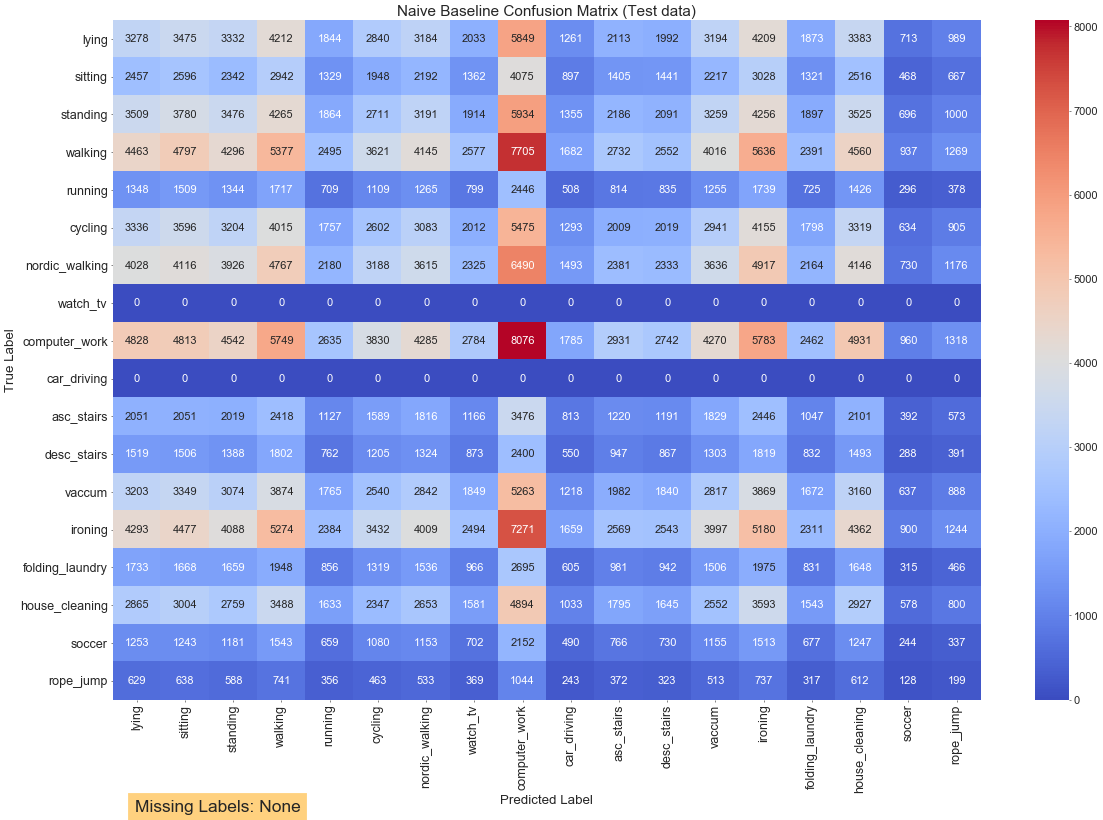

In [704]:
naive_acc = estimate_baseline_model(naive_model, X_train=X_train_baseline, y_train=y_train_baseline, X_test=X_test_baseline, y_test=y_test_baseline, plot_title="Naive Baseline Confusion Matrix")

<h3>2.c. Classical ML algorithms solid benchmark</h3>
We will fit our data (rows from measurments from each activity) into two ML algorithms in order to get a solid benchmark for the future LSTM model performance.<br/>
Each algorithm will get individual datapoints as X values (rows from activities) and the expected outcome will be the activity the measurment was taken from as y value.<br/>
We will use: <b>Decision Tree and Random Forest as an extension</b>

<h4>Decision Tree Classification Baseline </h4>
A <b>Decision Tree</b> is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome.<br/>
The topmost node in a decision tree is known as the root node. <br/>
It learns to partition on the basis of the attribute value.<br/>
It partitions the tree in recursively manner call recursive partitioning.
This flowchart-like structure helps you in decision making. 


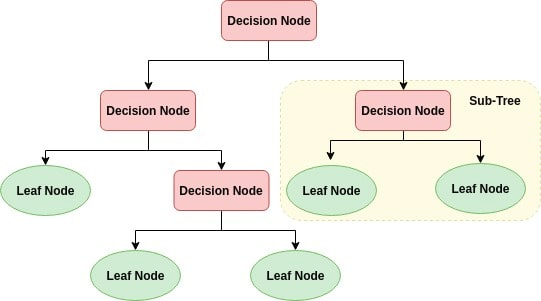

In [705]:
display_image('d_tree.jpg')

In [706]:
from sklearn.tree import DecisionTreeClassifier

def fit_decision_tree(X, y):
    clf = DecisionTreeClassifier()
    clf = clf.fit(X, y)
    return clf

In [707]:
dt_model = fit_decision_tree(X_train_baseline, y_train_baseline)

Train Prediction Count:
[('computer_work', 241207),
 ('ironing', 176195),
 ('walking', 173502),
 ('sitting', 149977),
 ('house_cleaning', 145493),
 ('lying', 142741),
 ('standing', 139014),
 ('nordic_walking', 130489),
 ('vaccum', 129503),
 ('cycling', 116440),
 ('asc_stairs', 87875),
 ('desc_stairs', 83658),
 ('watch_tv', 83645),
 ('running', 77970),
 ('folding_laundry', 76225),
 ('car_driving', 54518),
 ('rope_jump', 40549),
 ('soccer', 28788)]

Train Accuracy: 100.00%


Test Prediction Count:
[('desc_stairs', 84433),
 ('ironing', 72574),
 ('sitting', 63552),
 ('lying', 62305),
 ('computer_work', 54476),
 ('cycling', 52390),
 ('house_cleaning', 37180),
 ('vaccum', 33080),
 ('standing', 32074),
 ('running', 31084),
 ('walking', 30904),
 ('asc_stairs', 29284),
 ('nordic_walking', 25565),
 ('rope_jump', 24736),
 ('watch_tv', 9187),
 ('soccer', 4215)]

Test Accuracy: 24.55%


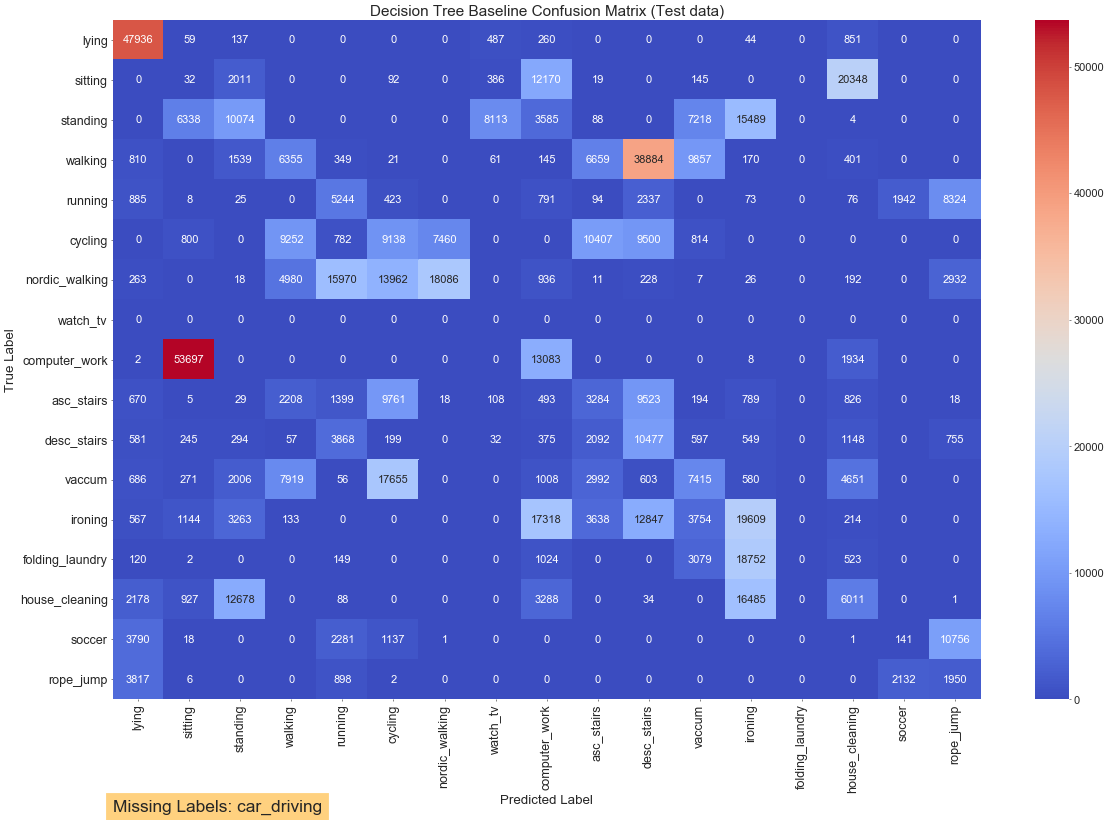

In [708]:
dt_acc = estimate_baseline_model(dt_model, X_train=X_train_baseline, y_train=y_train_baseline, X_test=X_test_baseline, y_test=y_test_baseline, plot_title="Decision Tree Baseline Confusion Matrix")

<h4>Random Forest Classification Baseline </h4>
We will try to achieve better baseline results by using multiple decision trees in the form of Random Forest classification ML algorithm.<br/>
<p>
<b>Random forests</b> or <b>random decision forests</b> are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees.<br/> Random decision forests correct for decision trees' habit of overfitting to their training set.<br/>Random forests generally outperform decision trees, but their accuracy is lower than gradient boosted trees. However, data characteristics can affect their performance.</p>


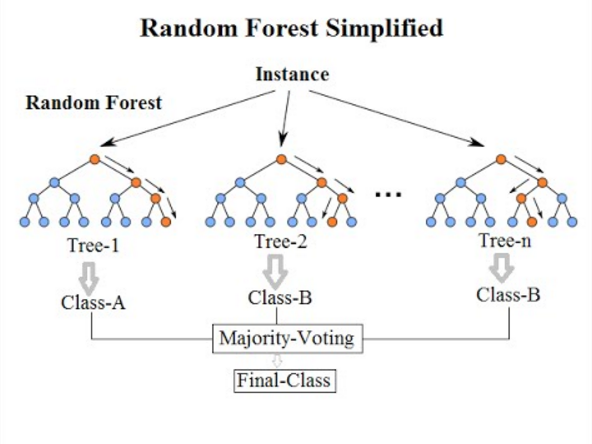

In [709]:
display_image('rf.png')

In [720]:
from sklearn.ensemble import RandomForestClassifier

def fit_random_forest(X, y):
    clf = RandomForestClassifier(n_estimators=20, verbose=2)
    clf.fit(X, y)
    return clf

In [721]:
rf_model = fit_random_forest(X_train_baseline, y_train_baseline)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.1s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.8min finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.6s finished


Train Prediction Count:
[('computer_work', 241207),
 ('ironing', 176195),
 ('walking', 173502),
 ('sitting', 149977),
 ('house_cleaning', 145493),
 ('lying', 142741),
 ('standing', 139014),
 ('nordic_walking', 130489),
 ('vaccum', 129503),
 ('cycling', 116440),
 ('asc_stairs', 87875),
 ('desc_stairs', 83658),
 ('watch_tv', 83645),
 ('running', 77970),
 ('folding_laundry', 76225),
 ('car_driving', 54518),
 ('rope_jump', 40549),
 ('soccer', 28788)]

Train Accuracy: 100.00%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.2s finished




Test Prediction Count:
[('computer_work', 98856),
 ('vaccum', 76234),
 ('sitting', 74820),
 ('lying', 65552),
 ('cycling', 57582),
 ('nordic_walking', 55442),
 ('standing', 39643),
 ('walking', 38438),
 ('house_cleaning', 32000),
 ('asc_stairs', 30046),
 ('running', 29458),
 ('desc_stairs', 25327),
 ('soccer', 14669),
 ('ironing', 8475),
 ('rope_jump', 356),
 ('folding_laundry', 141)]

Test Accuracy: 48.95%


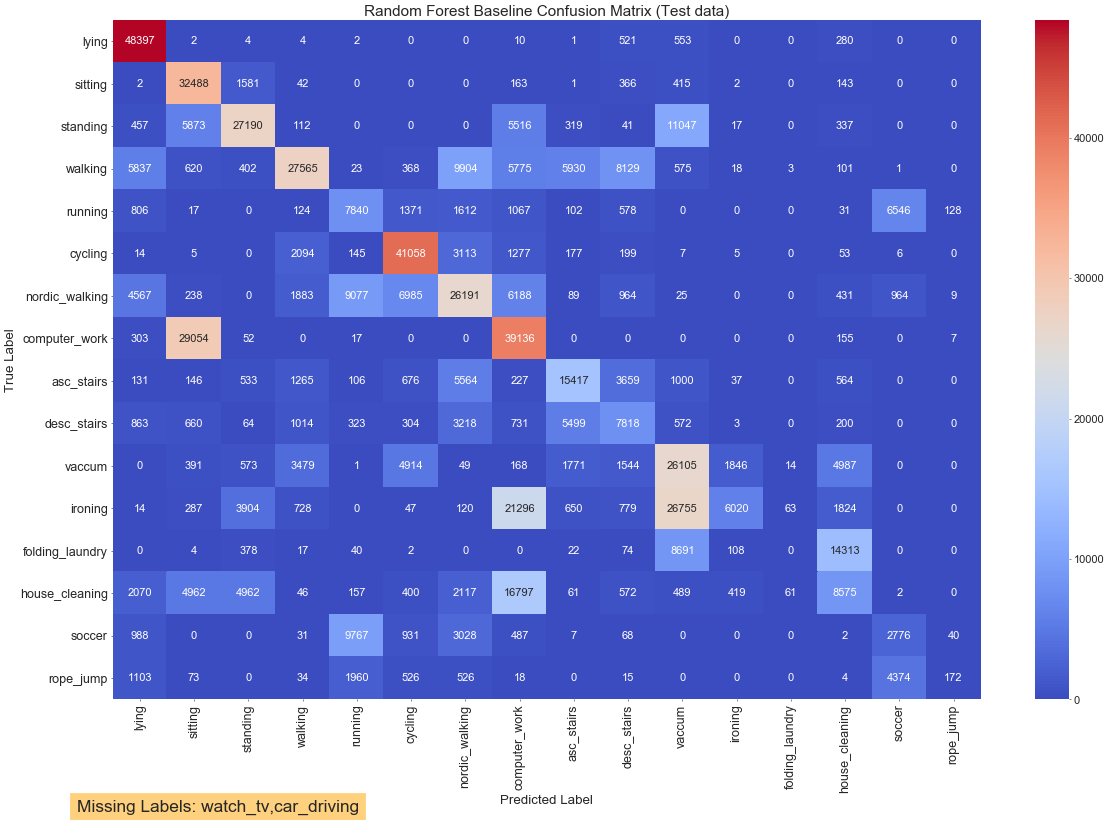

In [722]:
rf_acc = estimate_baseline_model(rf_model, X_train=X_train_baseline, y_train=y_train_baseline, X_test=X_test_baseline, y_test=y_test_baseline, plot_title="Random Forest Baseline Confusion Matrix")

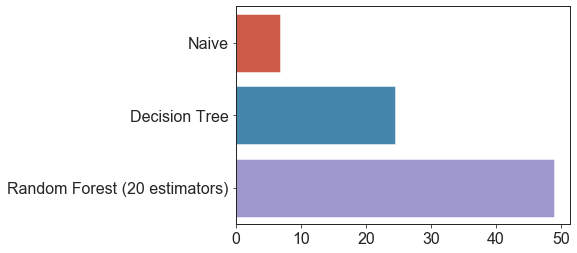

In [723]:
baseline_plot_df = pd.DataFrame([[naive_acc, dt_acc, rf_acc]], columns=['Naive', 'Decision Tree', 'Random Forest (20 estimators)'])
sns.barplot(data=baseline_plot_df, orient = 'h')

<h3>2.d. Classification using LSTM NN</h3>
In this section we will use Neural Networks in order to solve our classifictaion problem.<br/>
We will use LSTM layer to account for our measurments data window sequences.

<h4>About RNNs</h4>
<b>RNN's map an input sequence to an output sequence.</b>
RNNs can be used in interesting sequencing tasks. Ranging from machine language translation to time series forecasting.

With a simple RNN, there is the problem of "vanishing gradients", meaning the farther back the loss is propagated,<br/> the rate approaches zero meaning that information about the sequence properties are not saved. This is solved using Long Short Term Memory Units (LSTMs).


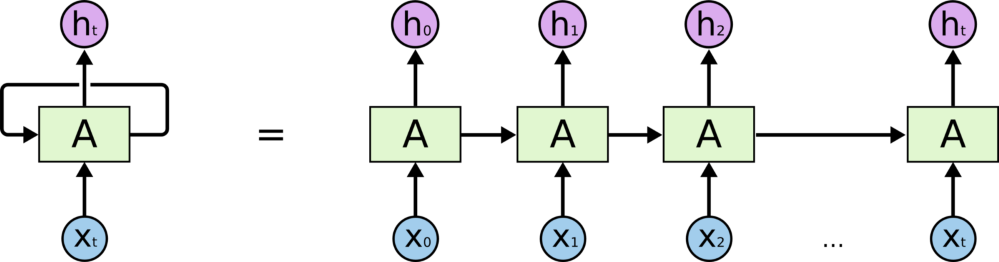

In [727]:
display_image('rnn.png')

<h4>About LSTM</h4>
<b>Long short-term memory (LSTM)</b> is an artificial recurrent neural network (RNN) architecture.<br/>
Unlike standard feedforward neural networks, LSTM has feedback connections.<br/>
It can not only process single data points (such as images), but also entire sequences of data (such as speech or video).<br/>
For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems).
<br/><br/>
In this task we will use LSTM in order ro process our measurments windows sequence of datapoints.


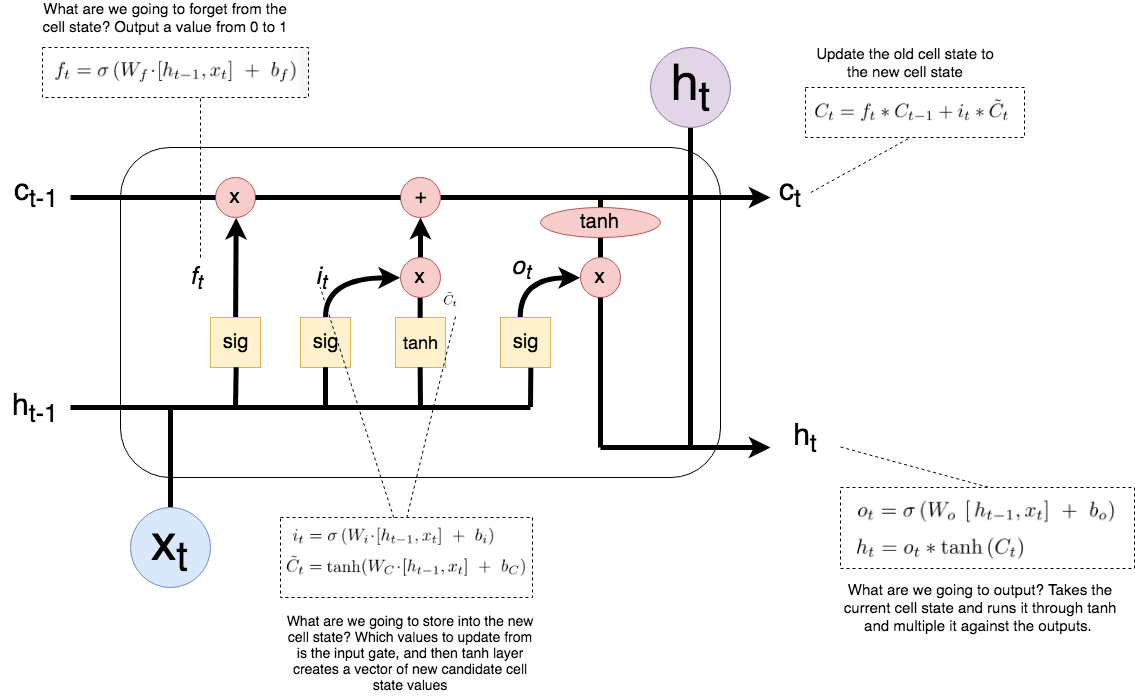

In [724]:
display_image('lstm.png')

<h4>The following image explains how we will solve the task at hand using LSTMs</h4>


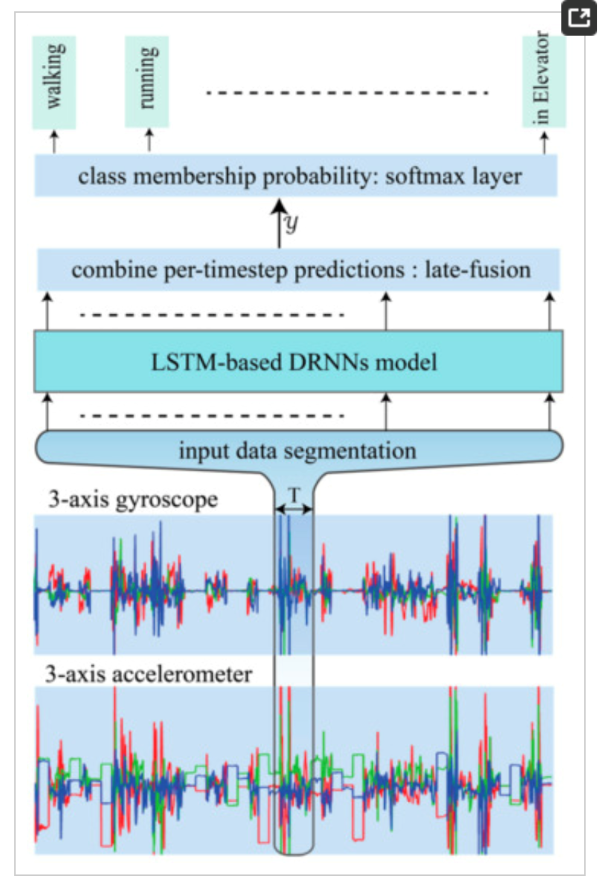

In [726]:
display_image('lstm_rnn.png')

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_save_dir = join(data_dir, 'saved_models')

def get_callbacks(saved_model_name):
    early_stopping_callback = EarlyStopping(monitor="val_loss", patience=3, verbose=2)
    rlop_callback = ReduceLROnPlateau(patience=3)   
    checkpoint_callback = ModelCheckpoint(join(model_save_dir, f'model_{saved_model_name}.h5'), 
                                                monitor='val_loss', verbose=1, 
                                                save_best_only=True, mode='min')
    return [early_stopping_callback, checkpoint_callback, rlop_callback]

In [59]:
def save_history(history, model_name):
    np.save(join(data_dir, 'history', f'{model_name}_history.npy'), history.history)
    
def load_history(model_name):
    return np.load(join(data_dir, 'history', f'{model_name}_history.npy'), allow_pickle='TRUE').item()

In [78]:
from tensorflow.keras.layers import Flatten, Dense, LSTM, Input, Dropout
from tensorflow.keras.models import Model

def create_simple_lstm_model():
    inp = Input(shape=(LOOK_BACK, FEATURES))
    x = LSTM(6)(inp)
    x = Dense(32 ,activation='relu')(x)
    x = Dense(activity_count, activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [73]:
simple_lstm_model = create_simple_lstm_model()
simple_lstm_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 52)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 6)                 1416      
_________________________________________________________________
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 18)                594       
Total params: 2,234
Trainable params: 2,234
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = simple_lstm_model.fit(x=train_generator, validation_data=valid_generator, epochs=5, verbose=1, callbacks=get_callbacks(saved_model_name='simple_lstm'), shuffle=False)
save_history(history, model_name='simple_lstm')

Epoch 1/5
3218/3218 [==============================] - ETA: 0s - loss: 0.9755 - accuracy: 0.6685
Epoch 00001: val_loss improved from inf to 0.52156, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_simple_lstm.h5
3218/3218 [==============================] - 277s 86ms/step - loss: 0.9755 - accuracy: 0.6685 - val_loss: 0.5216 - val_accuracy: 0.8217
Epoch 2/5
3218/3218 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.8582
Epoch 00002: val_loss improved from 0.52156 to 0.34983, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_simple_lstm.h5
3218/3218 [==============================] - 246s 76ms/step - loss: 0.4253 - accuracy: 0.8582 - val_loss: 0.3498 - val_accuracy: 0.8825
Epoch 3/5
3217/3218 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8948
Epoch 00003: val_loss improved from 0.34983 to 0.26607, saving 

In [237]:
def plot_history(history, plot_title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    
    # Plot training & validation accuracy values
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='lower right')
    axes[0].grid()

    # Plot training & validation loss values
    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper right')
    axes[1].grid()
    fig.suptitle(plot_title + " Model")
    plt.tight_layout()
    plt.show()

In [235]:
def plot_model_history(model_name):
    history = load_history(model_name)
    plot_title = model_name.replace("_", " ").title().replace("Lstm", "LSTM")
    plot_history(history, plot_title)

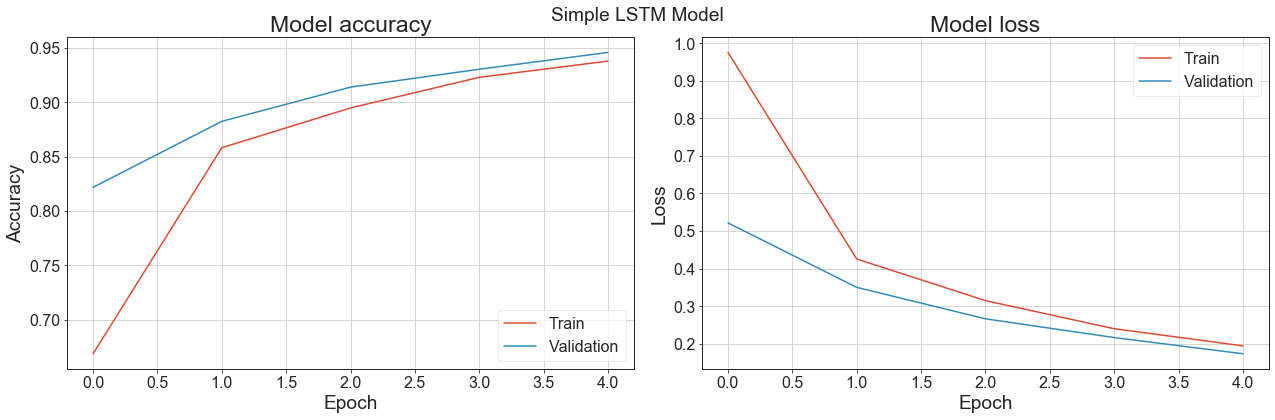

In [77]:
plot_model_history('simple_lstm')

In [157]:
from IPython.display import display 

def display_best_worst_predictions(preds, y_pred, y_true):
    y_pred_labeled = [{'pred_label': activity_id_map[pred], 'true_label': activity_id_map[y_true[i]], 'percentage': np.amax(preds[i]) * 100} for i, pred in enumerate(y_pred)]
    correct_set = set()
    correct_pred = sorted(list(filter(lambda pred: pred['pred_label'] == pred['true_label'], y_pred_labeled)), key=lambda e: e['percentage'], reverse=True)
    correct_samples = []
    for c_pred in correct_pred:
        if c_pred['pred_label'] not in correct_set:
            correct_set.add(c_pred['pred_label'])
            correct_samples.append(c_pred)

    print('Top Correct Predictions Samples from each label:')
    display(pd.DataFrame([[p['pred_label'], p['true_label'], p['percentage']] for p in correct_samples], columns=['Predicted Label', 'True Label', 'Prediction Percentage'])) 

    wrong_set = set()
    worst_pred = sorted(list(filter(lambda pred: pred['pred_label'] != pred['true_label'], y_pred_labeled)), key=lambda e: e['percentage'], reverse=True)
    wrong_samples = []
    for w_pred in worst_pred:
        if w_pred['pred_label'] not in wrong_set:
            wrong_set.add(w_pred['pred_label'])
            wrong_samples.append(w_pred)

    print('\nTop Worst Prediction Samples from each label:')
    display(pd.DataFrame([[p['pred_label'], p['true_label'], p['percentage']] for p in wrong_samples], columns=['Predicted Label', 'True Label', 'Prediction Percentage']))

In [158]:
def plot_classification_report(clf_report, plot_title):
    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='coolwarm', ax=ax)
    ax.set_title(plot_title + ' Classification Report(Test)')
    plt.show()

In [159]:
import matplotlib.ticker as plticker

def plot_scores(scores, plot_title):
    acc_scores = {k: s[1] * 100 for k, s in scores.items()}
    loss_scores = {k: s[0] for k, s in scores.items()}
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    acc_keys = list(acc_scores.keys())
    acc_vals = [acc_scores[k] for k in acc_keys]
    p1 = sns.barplot(x=acc_keys, y=acc_vals, ax=axes[0], palette="Blues_d")
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy Percentage')
    axes[0].set_xlabel('Data')
    p1.set(yticks=range(0, 100, 5))
    axes[0].tick_params(axis='y', labelsize=10)
    for i, v in enumerate(acc_vals):
        axes[0].text(i-.25, 0.0, f'{acc_vals[i]:.3f}', fontsize=16)
    
    loss_keys = list(loss_scores.keys())
    loss_vals = [loss_scores[k] for k in loss_keys]
    p2 = sns.barplot(x=loss_keys, y=loss_vals, ax=axes[1], palette="Blues_d")
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Data')
    p2.set(yticks=np.arange(0, max(loss_vals) + 0.2, 0.2))
    axes[1].tick_params(axis='y', labelsize=10)
    for i, v in enumerate(loss_vals):
        axes[1].text(i-.25, 0.0, f'{loss_vals[i]:.3f}', fontsize=16)
    
    fig.suptitle(plot_title, y=1.08)
    plt.tight_layout()
    plt.show()

In [154]:
from sklearn.metrics import classification_report

def evaluate_lstm_model(model_create_func, saved_model_name):
    model = model_create_func()
    model.load_weights(join(model_save_dir, f'model_{saved_model_name}.h5'))
    
    scores = dict()
    print('Evaluating on train data:')
    score = model.evaluate(train_generator, verbose=1)
    print(f'Evaulate train loss: {score[0]:.4f} / Evaluate train accuracy: {(score[1] * 100):.3f}%\n')
    scores['train'] = score
    
    print('\nEvaluating on validation data:')
    score = model.evaluate(valid_generator, verbose=1)
    print(f'Evaulate validation loss: {score[0]:.4f} / Evaluate validation accuracy: {(score[1] * 100):.3f}%\n')
    scores['valid'] = score
    
    print('\nEvaluating on test data:')
    preds = model.predict(test_generator, verbose=1)
    y_pred = [index_to_activity_id[pred] for pred in np.argmax(preds, axis=1)]
    y_true = [index_to_activity_id[pred] for pred in np.argmax(y_test, axis=1)]
    accuracy = accuracy_score(y_true, y_pred)
    score = model.evaluate(test_generator, verbose=1)
    print(f'\nAccuracy: {(accuracy * 100):.2f}%')
    print(f'Evaulate test loss: {score[0]:.4f} / Evaluate Test accuracy: {(score[1] * 100):.3f}%')
    scores['test'] = score
    
    clf_report = classification_report([activity_id_map[x] for x in y_true], [activity_id_map[x] for x in y_pred], zero_division=0, output_dict=True)
    return preds, y_true, y_pred, clf_report, scores

Evaluating on train data:
12870/12870 [==============================] - 296s 23ms/step - loss: 0.1722 - accuracy: 0.9461
Evaulate train loss: 0.1722 / Evaluate train accuracy: 94.609%


Evaluating on validation data:
3218/3218 [==============================] - 72s 22ms/step - loss: 0.1731 - accuracy: 0.9459
Evaulate validation loss: 0.1731 / Evaluate validation accuracy: 94.592%


Evaluating on test data:
5007/5007 [==============================] - 115s 23ms/step - loss: 4.6883 - accuracy: 0.4823

Accuracy: 48.23%
Evaulate test loss: 4.6883 / Evaluate Test accuracy: 48.231%


C:\Users\Itay Bouganim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Itay Bouganim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


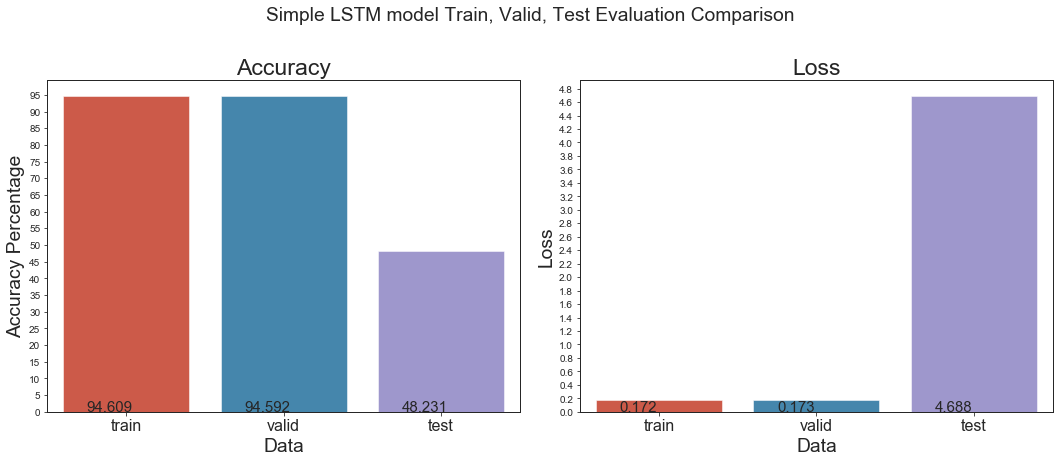

In [688]:
preds, y_true, y_pred, clf_report, scores = evaluate_lstm_model(model_create_func=create_simple_lstm_model, saved_model_name='simple_lstm')
plot_scores(scores, plot_title="Simple LSTM model Train, Valid, Test Evaluation Comparison")

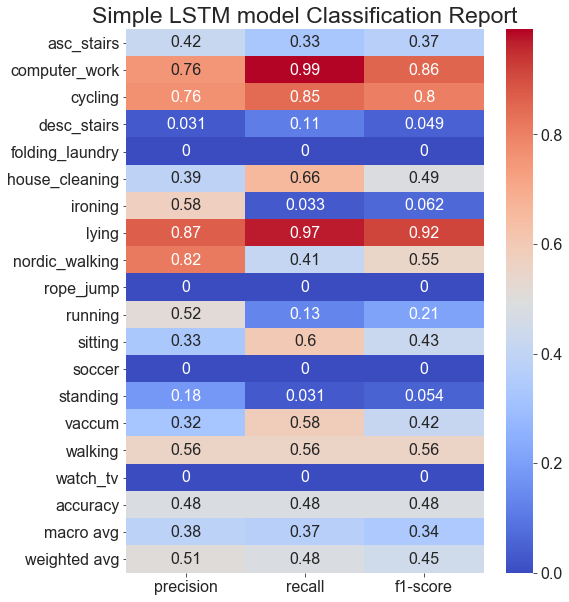

In [689]:
plot_classification_report(clf_report, plot_title="Simple LSTM model")

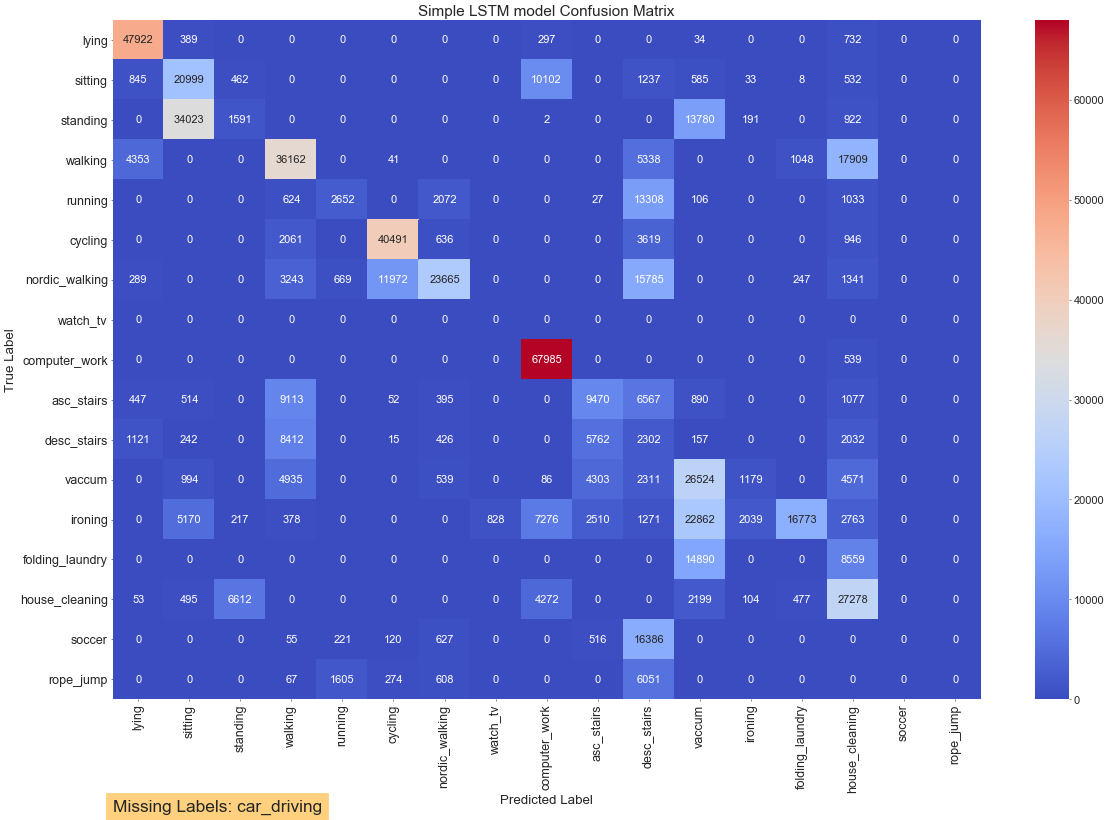

In [690]:
plot_confusion_matrix(y=y_true, y_pred=y_pred, title='Simple LSTM model Confusion Matrix')

In [691]:
display_best_worst_predictions(preds, y_pred, y_true)

Top Correct Predictions Samples from each label:


Predicted Label      True Label  Prediction Percentage
0    computer_work   computer_work              99.999642
1          cycling         cycling              99.997652
2          walking         walking              99.994278
3   house_cleaning  house_cleaning              99.975330
4          running         running              99.964857
5           vaccum          vaccum              99.921083
6            lying           lying              99.552757
7          ironing         ironing              99.383140
8          sitting         sitting              99.242181
9   nordic_walking  nordic_walking              98.728162
10     desc_stairs     desc_stairs              98.061460
11      asc_stairs      asc_stairs              96.930337
12        standing        standing              69.689780


Top Worst Prediction Samples from each label:


Predicted Label      True Label  Prediction Percentage
0     computer_work           lying              99.998152
1           sitting           lying              99.994898
2           walking     desc_stairs              99.992383
3    house_cleaning   computer_work              99.888891
4    nordic_walking         running              99.722618
5            vaccum         sitting              99.690694
6           cycling  nordic_walking              99.392104
7   folding_laundry         ironing              99.359691
8       desc_stairs          soccer              99.311996
9          standing  house_cleaning              99.048233
10          ironing          vaccum              98.097479
11            lying      asc_stairs              96.731544
12       asc_stairs     desc_stairs              94.872826
13          running       rope_jump              91.974562
14         watch_tv         ironing              85.674328

<b>We can see that the LSTM model performed relativly well , yet did not pass the benchmark score we got by using the Random Forest ML classifier</b>

<h3>2.e. Pretrain model for forecasting task and fine-tune for classification</h3>
We are going to pretrain our model to the previously suggested task of forecasting the next time step heart rate according to the previous 200 measurments samples.<br/>
After the model is trained for the heart rate forecasting task we will fine-tune it to conform to the classification task we are after and see if we can get better results.

<h4>Preprocess the data for forecasting task</h4>

In [69]:
def split_forecast_train_valid(x_train_lists):
    activity_samples = [(X_activity, y_train_lists[i]) for i, X_activity in enumerate(x_train_lists)]
    train_representation = Counter([activity_id for _, activity_id in activity_samples])

    in_valid_activities = set()
    train, valid = [], []
    for sample, activity_id in activity_samples:
        if activity_id not in in_valid_activities and train_representation[activity_id] > 1:
            valid.append(sample)
            in_valid_activities.add(activity_id)
        else:
            train.append(sample)

    return train, valid

In [70]:
train, valid = split_forecast_train_valid(x_train_lists)
test = x_test_lists

<h4>Create timeframe windows and y true HR values</h4>

In [71]:
from tensorflow.keras.layers import TimeDistributed

PRED_STEPS = 1

def forecast_sliding_windows(x_lists, look_back, pred_steps):
    X, y = [], []
    indicies = {c:to_scale_data.columns.get_loc(c) for c in to_scale_data.columns}
    indicies = [v for k, v in indicies.items() if k in set(['heart_rate'])]
    for series in tqdm(x_lists, desc=f'Generating sliding windows for activities (out of {len(x_lists)} activities)'):
        for window_start in range(len(series)):
            past_end = window_start + look_back
            future_end = past_end + pred_steps
            if future_end > len(series):
                break
            past, future = series[window_start:past_end, :], series[past_end:future_end, :]
            X.append(past)
            y.append([future[0][i] for i in indicies]) # heart rate and temperatures
    return X, y

In [72]:
X_train_forecast, y_train_forecast = forecast_sliding_windows(train, look_back=LOOK_BACK, pred_steps=PRED_STEPS)
X_valid_forecast, y_valid_forecast = forecast_sliding_windows(valid, look_back=LOOK_BACK, pred_steps=PRED_STEPS)
X_test_forecast, y_test_forecast = forecast_sliding_windows(test, look_back=LOOK_BACK, pred_steps=PRED_STEPS)

Generating sliding windows for activities (out of 78 activities): 100%|██████████| 78/78 [00:06<00:00, 11.15it/s]
Generating sliding windows for activities (out of 15 activities): 100%|██████████| 15/15 [00:01<00:00, 10.94it/s]
Generating sliding windows for activities (out of 31 activities): 100%|██████████| 31/31 [00:02<00:00, 12.38it/s]


In [73]:
BATCH_SIZE = 512

class ForecastDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, pred_steps, batch_size, dim):
        'Initialization'
        self.X = X
        self.y = y
        self.pred_steps = pred_steps
        self.dim = dim
        self.batch_size = batch_size

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.ceil(len(self.X) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        batch_x = self.X[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = np.array(batch_x), np.array(batch_y)
        y = np.squeeze(y)
        return X, y
    
    def shape_in(self):
        return (len(self.X), *self.dim)
           
    def shape_out(self):
        return (len(self.y), 1)

In [75]:
train_generator_forecast = ForecastDataGenerator(X_train_forecast, y_train_forecast, pred_steps=PRED_STEPS, batch_size=BATCH_SIZE, dim=(LOOK_BACK, FEATURES))
valid_generator_forecast = ForecastDataGenerator(X_valid_forecast, y_valid_forecast, pred_steps=PRED_STEPS, batch_size=BATCH_SIZE, dim=(LOOK_BACK, FEATURES))
test_generator_forecast = ForecastDataGenerator(X_test_forecast, y_test_forecast, pred_steps=PRED_STEPS, batch_size=BATCH_SIZE / 16, dim=(LOOK_BACK, FEATURES))

print(f'Forecast model input/output shapes:\n=========================================')
print(f'Train data input shape: {train_generator_forecast.shape_in()}\nTrain data output shape: {train_generator_forecast.shape_out()}\n\n')
print(f'Validation data input shape: {valid_generator_forecast.shape_in()}\nValidation data output shape: {valid_generator_forecast.shape_out()}\n\n')
print(f'Test data input shape: {test_generator_forecast.shape_in()}\nTest data output shape: {test_generator_forecast.shape_out()}')

Forecast model input/output shapes:
Train data input shape: (1635350, 200, 52)
Train data output shape: (1635350, 1)


Validation data input shape: (423839, 200, 52)
Validation data output shape: (423839, 1)


Test data input shape: (640839, 200, 52)
Test data output shape: (640839, 1)


In [203]:
from tensorflow.keras.layers import AveragePooling1D, Concatenate, BatchNormalization, Conv1D, MaxPooling1D, Flatten

def create_forecast_lstm_model():
    inp = Input(shape=(LOOK_BACK, FEATURES))
    x = LSTM(6)(inp) # Stacked LSTM (change to 100 or 200 lstm)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(1)(x) # Prediction

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model
    

In [204]:
forecast_model = create_forecast_lstm_model()
forecast_model.summary()

Model: "functional_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 200, 52)]         0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 6)                 1416      
_________________________________________________________________
dropout_31 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_76 (Dense)             (None, 32)                224       
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 33        
Total params: 1,673
Trainable params: 1,673
Non-trainable params: 0
_________________________________________________________________


In [205]:
history = forecast_model.fit(train_generator_forecast, validation_data=valid_generator_forecast, epochs=5, verbose=1, callbacks=get_callbacks(saved_model_name='forecast_lstm'), shuffle=False)
save_history(history, model_name='forecast_lstm')

Epoch 1/5
3194/3195 [============================>.] - ETA: 0s - loss: 0.0162 - mse: 0.0162
Epoch 00001: val_loss improved from inf to 0.18524, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_forecast_lstm.h5
3195/3195 [==============================] - 216s 68ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.1852 - val_mse: 0.1852
Epoch 2/5
3195/3195 [==============================] - ETA: 0s - loss: 0.0170 - mse: 0.0170
Epoch 00002: val_loss improved from 0.18524 to 0.08402, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_forecast_lstm.h5
3195/3195 [==============================] - 208s 65ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0840 - val_mse: 0.0840
Epoch 3/5
3195/3195 [==============================] - ETA: 0s - loss: 0.0145 - mse: 0.0145
Epoch 00003: val_loss did not improve from 0.08402
3195/3195 [==============================] 

In [206]:
def evaluate_forecast_model(model_create_func, saved_model_name):
    model = model_create_func()
    model.load_weights(join(model_save_dir, f'model_{saved_model_name}.h5'))
    
    x = np.array(X_test_forecast[:100000])
    preds = model.predict(x, verbose=1)
    return preds

preds = evaluate_forecast_model(model_create_func=create_forecast_lstm_model, saved_model_name='forecast_lstm')

3125/3125 [==============================] - 50s 16ms/step


In [207]:
y = np.array(y_test_forecast[:100000])
y = np.squeeze(y)
y = pd.DataFrame(y, columns=to_scale_data[['heart_rate']].columns, index=range(0, len(y)))

y_preds = [y for x in preds for y in x]
y_preds = np.array(y_preds)
y_preds = pd.DataFrame(y_preds, columns=to_scale_data[['heart_rate']].columns, index=range(0, len(y)))

In [208]:
from sklearn.metrics import mean_squared_error

print("Forecast test data MSE:")
mean_squared_error(y, y_preds, squared=False)

Forecast test data MSE:


0.32648256399226794

<h4>True Forecast values (top chart) vs. Predicted Forecast values (bottom chart)</h4>

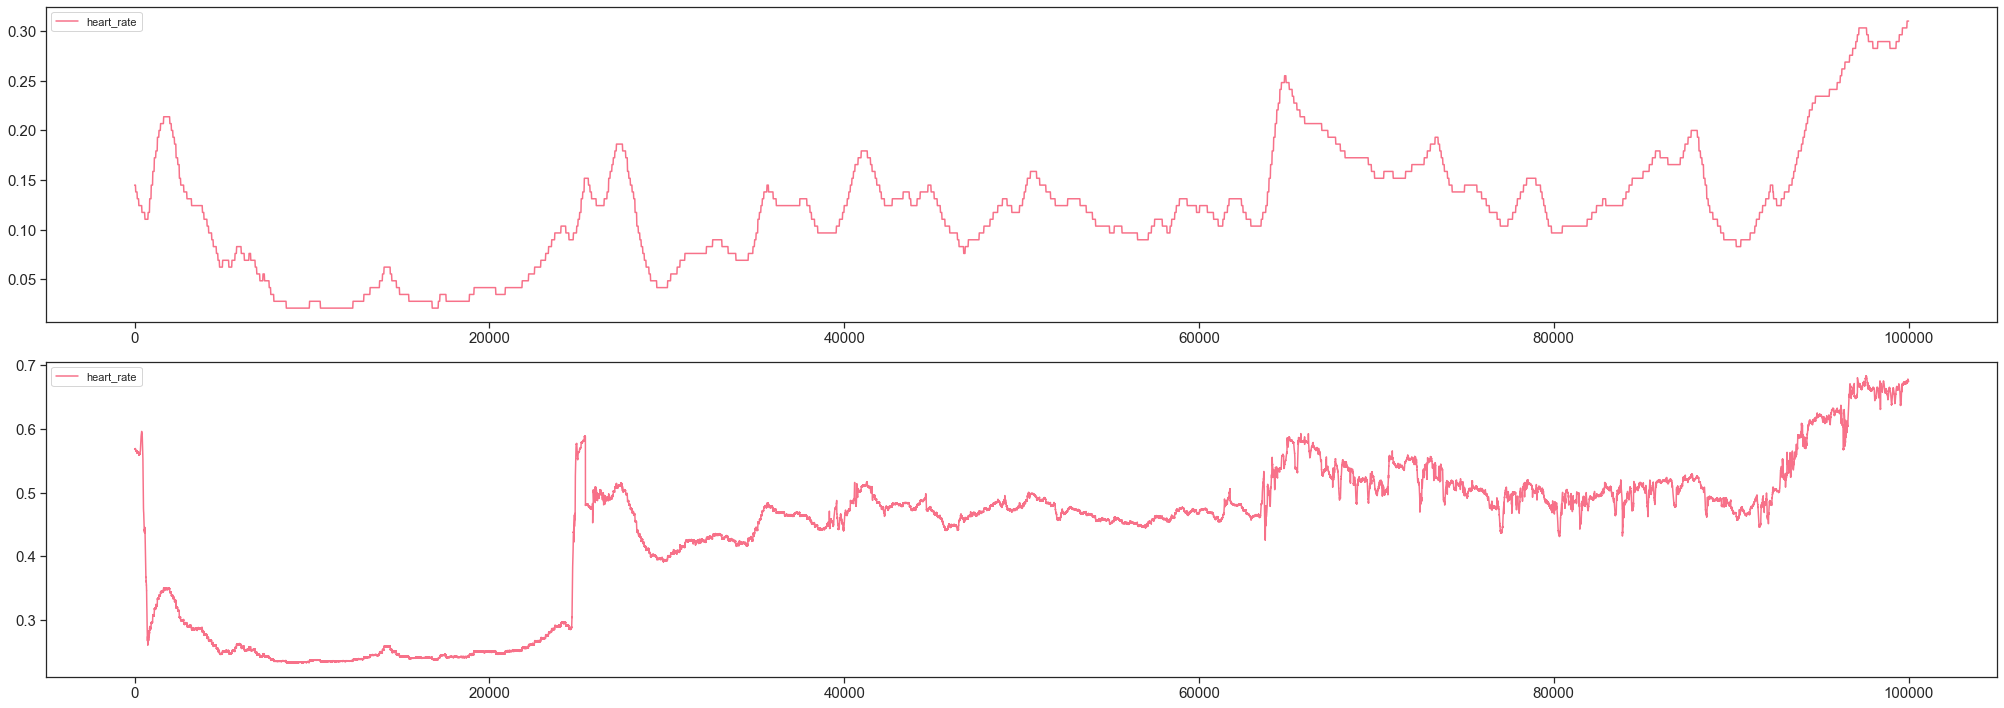

In [209]:
def plot_forecast_heart_rate(df1, df2):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(28,10))
    plot = df1[['heart_rate']]
    plot2 = df2[['heart_rate']]
    plot.plot( ax=axes[0], rot=0, fontsize=15)
    plot2.plot( ax=axes[1], rot=0, fontsize=15)


    fig.tight_layout()
    plt.show()
    
plot_forecast_heart_rate(y, y_preds)

<h4>Fine-tune the forecast model for our prediction task</h4>

In [210]:
from tensorflow.keras.layers import BatchNormalization

def create_forecast_classify_model(forecast_model):
    x = BatchNormalization()(forecast_model.layers[-2].output)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(activity_count, activation='softmax')(x)

    classify_forecast_model = Model(inputs=forecast_model.inputs, outputs=[x])
    classify_forecast_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return classify_forecast_model

forecast_model = create_forecast_lstm_model()
forecast_model.load_weights(join(model_save_dir, f'model_forecast_lstm.h5'))

for layer in forecast_model.layers:
    layer.trainable = False
    
print('\nAfter changing layers to non-trainable:')
forecast_model.summary()
    
classify_forecast_model = create_forecast_classify_model(forecast_model)

print('\n\nAfter changing last layer to classification:')
classify_forecast_model.summary()


After changing layers to non-trainable:
Model: "functional_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 200, 52)]         0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 6)                 1416      
_________________________________________________________________
dropout_33 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_80 (Dense)             (None, 32)                224       
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 33        
Total params: 1,673
Trainable params: 0
Non-trainable params: 1,673
_________________________________________________________________


After changing last layer to classification:
Model: "functional_97"
______

In [211]:
history = classify_forecast_model.fit(train_generator, validation_data=valid_generator, epochs=5, verbose=1, callbacks=get_callbacks(saved_model_name='forecast_classify_lstm'), shuffle=False)
save_history(history, model_name='forecast_classify_lstm')

Epoch 1/5
3218/3218 [==============================] - ETA: 0s - loss: 2.0866 - accuracy: 0.2901
Epoch 00001: val_loss improved from inf to 3.70828, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_forecast_classify_lstm.h5
3218/3218 [==============================] - 242s 75ms/step - loss: 2.0866 - accuracy: 0.2901 - val_loss: 3.7083 - val_accuracy: 0.1723
Epoch 2/5
3217/3218 [============================>.] - ETA: 0s - loss: 1.9530 - accuracy: 0.3206
Epoch 00002: val_loss did not improve from 3.70828
3218/3218 [==============================] - 237s 74ms/step - loss: 1.9530 - accuracy: 0.3206 - val_loss: 4.2870 - val_accuracy: 0.1867
Epoch 3/5
3217/3218 [============================>.] - ETA: 0s - loss: 1.9214 - accuracy: 0.3275
Epoch 00003: val_loss did not improve from 3.70828
3218/3218 [==============================] - 237s 74ms/step - loss: 1.9214 - accuracy: 0.3275 - val_loss: 4.5909 - val_accuracy: 0.1897
Epo

Evaluating on train data:
3218/3218 [==============================] - 192s 60ms/step - loss: 3.7101 - accuracy: 0.1723
Evaulate train loss: 3.7101 / Evaluate train accuracy: 17.225%


Evaluating on validation data:
805/805 [==============================] - 48s 60ms/step - loss: 3.7083 - accuracy: 0.1723
Evaulate validation loss: 3.7083 / Evaluate validation accuracy: 17.228%


Evaluating on test data:
1252/1252 [==============================] - 73s 58ms/step - loss: 4.2188 - accuracy: 0.1865

Accuracy: 18.65%
Evaulate test loss: 4.2188 / Evaluate Test accuracy: 18.654%


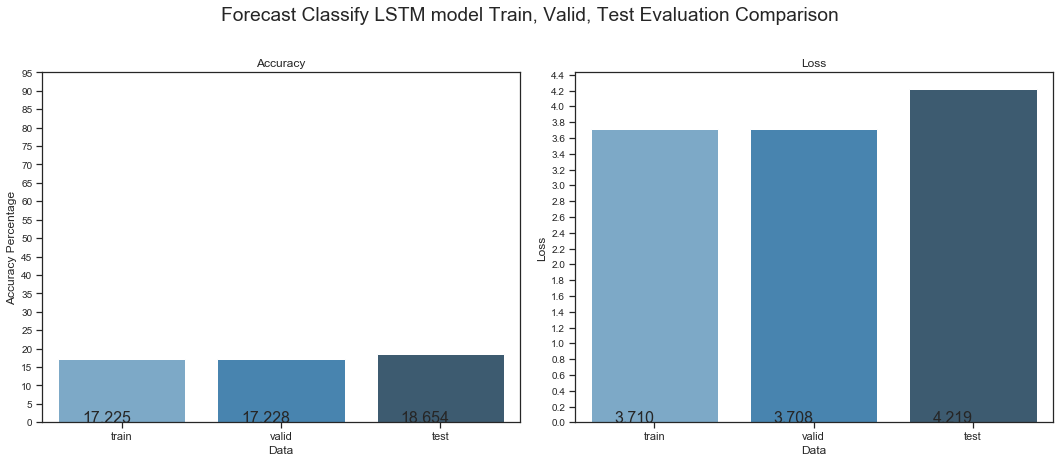

In [217]:
preds, y_true, y_pred, clf_report, scores = evaluate_lstm_model(model_create_func=lambda: create_forecast_classify_model(forecast_model), saved_model_name='forecast_classify_lstm')
plot_scores(scores, plot_title="Forecast Classify LSTM model Train, Valid, Test Evaluation Comparison")

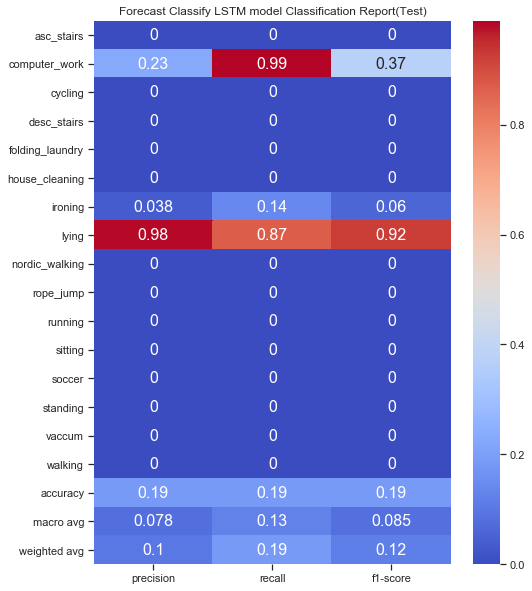

In [218]:
plot_classification_report(clf_report, plot_title="Forecast Classify LSTM model")

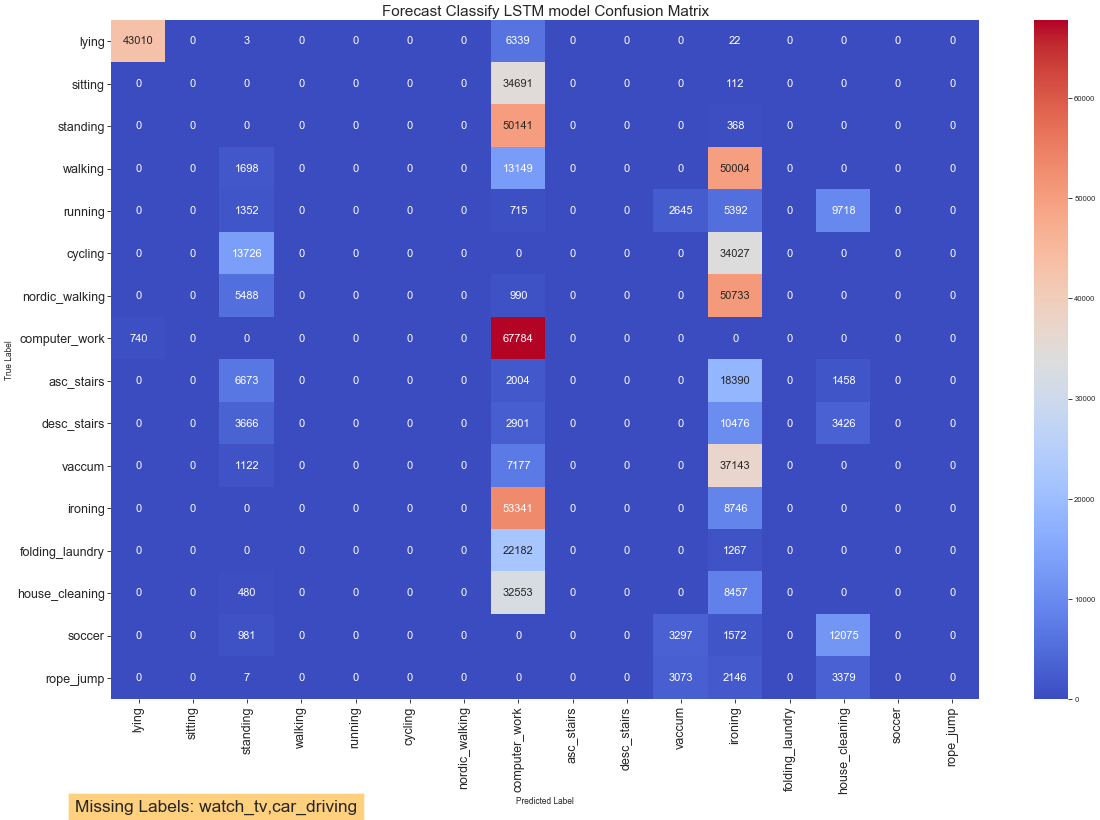

In [219]:
plot_confusion_matrix(y=y_true, y_pred=y_pred, title='Forecast Classify LSTM model Confusion Matrix')

In [220]:
display_best_worst_predictions(preds, y_pred, y_true)

Top Correct Predictions Samples from each label:


Predicted Label     True Label  Prediction Percentage
0           lying          lying              92.309529
1   computer_work  computer_work              69.439733
2         ironing        ironing              35.125613


Top Worst Prediction Samples from each label:


Predicted Label      True Label  Prediction Percentage
0   computer_work     desc_stairs              73.167610
1         ironing  nordic_walking              46.692520
2        standing         cycling              36.124146
3          vaccum       rope_jump              32.319388
4           lying   computer_work              31.848696
5  house_cleaning         running              30.252954

<h3>2.f. Improvement suggestions and first LSTM iteration summary</h3>
<h4>Why is the model fitting well on training and validation data but less for test data?</h4>
In our opinion the 4 main reasons for the good accuracy and loss ratings of the model on the validation data versus the accuracy and loss rating of the testing data are:
<ol>
    <li>The validation data and training data both contain timeframes from the same exact activities and were both taken from the same subset of subjects (101, 102, 103, 104, 105, 106, 109)</li>
    <li>The validation data and training data both contain samples from each class and since we use stratisfied train-test split to produce the validation data, the activity representation percentage in the training data and validation data is simillar.<br/>The testing data was taken from different subjects.</li>
    <li>The testing data does not contain any samples for two of the classes the model was trained on (No samples for watching TV and Car driving activities). <br/>The training/validation data contain samples from all classes available to us.</li>
    <li>The testing data is from a whole diffrent subject subset (107, 108) and therefore does not contain timeframes that intersect with the timeframes the model was trained on.</li>
</ol>

<h4>Improvements suggestions going forward</h4>
<ul>
    <li>Increasing node count for LSTM layer to increase look back memory</li>
    <li>Add stacked LSTM layers to increase depth of the model (First lstm output will be the second LSTM input, with return sequences flag for the first LSTM)</li>
    <li>Add 1D Time Distributed Convolutional layer before LSTM layers to increase the dominant and average features capturing for before passing to to the LSTM layers</li>
    <li>Add more dense layers after the LSTM layers with dropout to add model complexity and try better distinct simillar features</li>
</ul>

<h3>2.e. Improving the model</h3>
We will implement the following improvements:
<ol>
    <li>Increasing node count for LSTM layer to increase look back memory</li>
    <li>Add 1D Time Distributed Convolutional layer before LSTM layers to increase the dominant and average features capturing for before passing to to the LSTM layers</li>
</ol>
For both of those improvements we will additionally add more dense layer to try and capture more complex features.

<h4> Increase LSTM nodes and add dense layers</h4>

In [197]:
def create_improved_lstm_model():
    inp = Input(shape=(LOOK_BACK, FEATURES))
    x = LSTM(100)(inp)
    x = Dropout(0.5)(x)
    x = Dense(100 ,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(100 ,activation='relu')(x)
    x = Dense(activity_count, activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [198]:
improved_lstm_model = create_improved_lstm_model()
improved_lstm_model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 200, 52)]         0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               61200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 18)              

In [199]:
history = improved_lstm_model.fit(train_generator, validation_data=valid_generator, epochs=5, verbose=1, callbacks=get_callbacks(saved_model_name='improved_lstm'), shuffle=False)
save_history(history, model_name='improved_lstm')

Epoch 1/5
3218/3218 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.8350
Epoch 00001: val_loss improved from inf to 0.12015, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_improved_lstm.h5
3218/3218 [==============================] - 360s 112ms/step - loss: 0.4874 - accuracy: 0.8350 - val_loss: 0.1202 - val_accuracy: 0.9601
Epoch 2/5
3218/3218 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9492
Epoch 00002: val_loss did not improve from 0.12015
3218/3218 [==============================] - 416s 129ms/step - loss: 0.1689 - accuracy: 0.9492 - val_loss: 0.1578 - val_accuracy: 0.9552
Epoch 3/5
3218/3218 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9769
Epoch 00003: val_loss improved from 0.12015 to 0.06932, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_improved_lstm.h5
3218/3

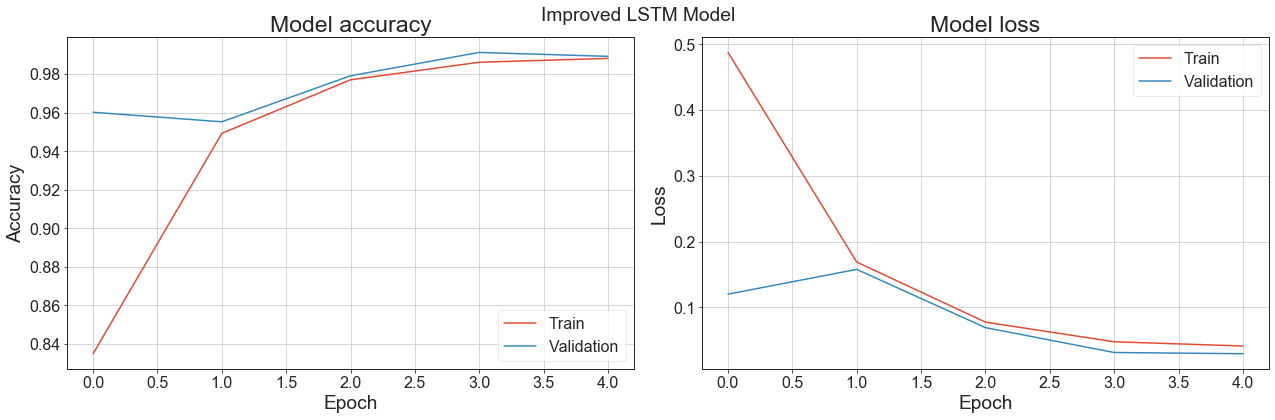

In [200]:
plot_model_history('improved_lstm')

Evaluating on train data:
12870/12870 [==============================] - 302s 23ms/step - loss: 0.0296 - accuracy: 0.9890
Evaulate train loss: 0.0296 / Evaluate train accuracy: 98.897%


Evaluating on validation data:
3218/3218 [==============================] - 79s 25ms/step - loss: 0.0296 - accuracy: 0.9891
Evaulate validation loss: 0.0296 / Evaluate validation accuracy: 98.910%


Evaluating on test data:
5007/5007 [==============================] - 146s 29ms/step - loss: 3.6519 - accuracy: 0.5213

Accuracy: 52.13%
Evaulate test loss: 3.6519 / Evaluate Test accuracy: 52.135%


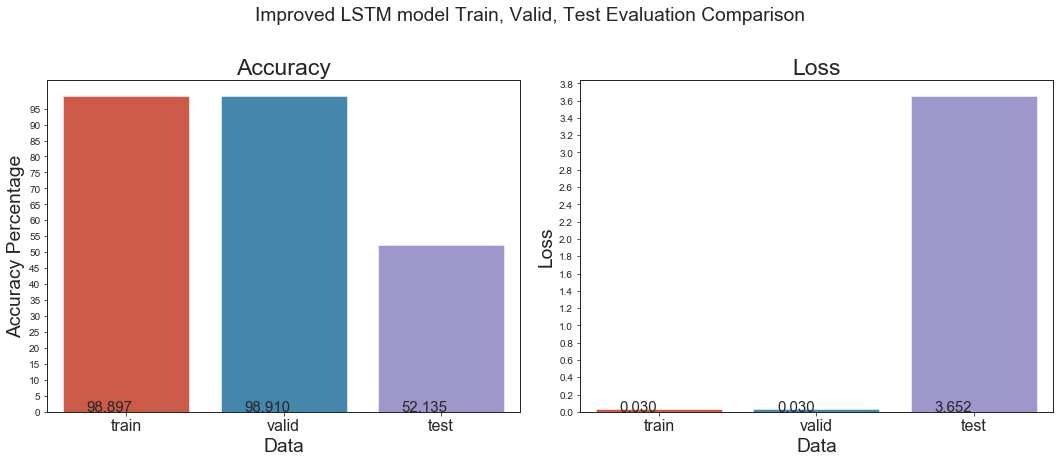

In [513]:
preds, y_true, y_pred, clf_report, scores = evaluate_lstm_model(model_create_func=create_improved_lstm_model, saved_model_name='improved_lstm')
plot_scores(scores, plot_title="Improved LSTM model Train, Valid, Test Evaluation Comparison")

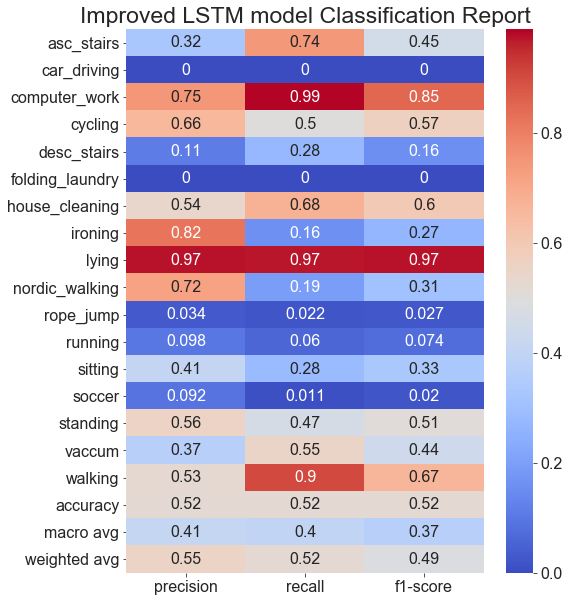

In [514]:
plot_classification_report(clf_report, plot_title="Improved LSTM model")

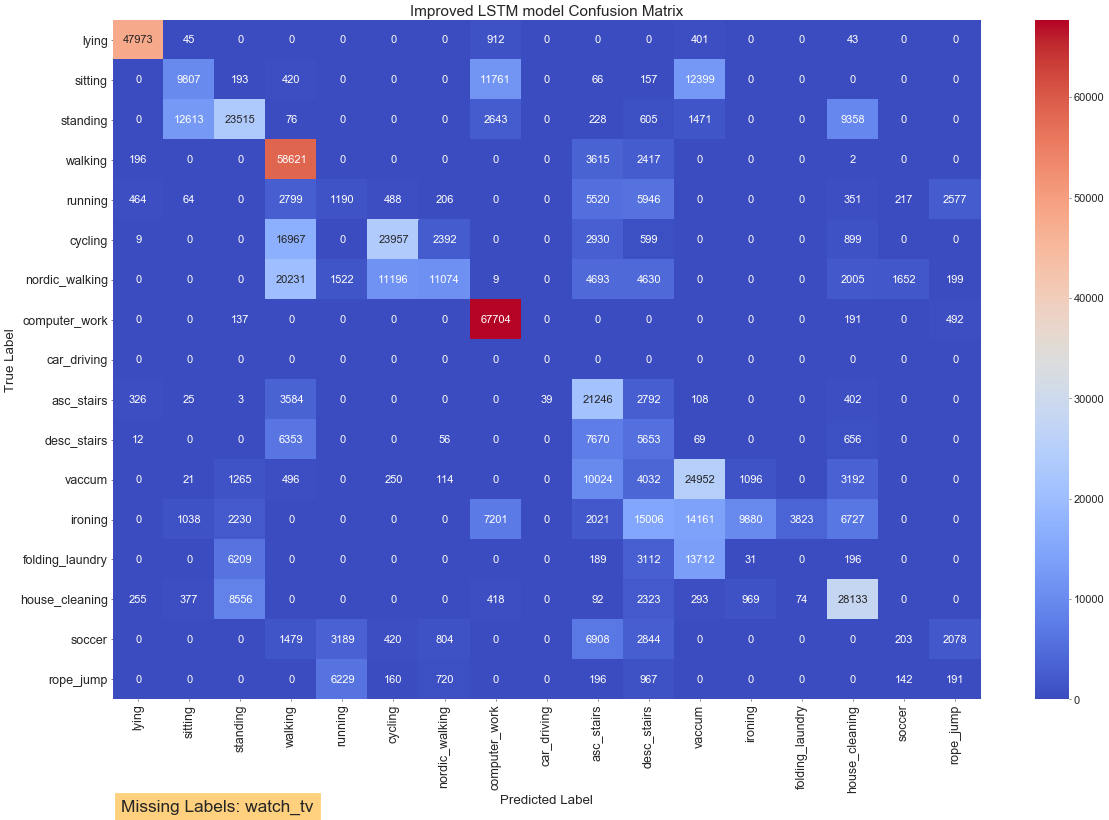

In [515]:
plot_confusion_matrix(y=y_true, y_pred=y_pred, title='Improved LSTM model Confusion Matrix')

In [516]:
display_best_worst_predictions(preds, y_pred, y_true)

Top Correct Predictions Samples from each label:


Predicted Label      True Label  Prediction Percentage
0    computer_work   computer_work             100.000000
1            lying           lying             100.000000
2   house_cleaning  house_cleaning              99.999976
3          cycling         cycling              99.999917
4          walking         walking              99.999821
5           vaccum          vaccum              99.998140
6       asc_stairs      asc_stairs              99.994457
7   nordic_walking  nordic_walking              99.975449
8         standing        standing              99.975091
9      desc_stairs     desc_stairs              99.931300
10         ironing         ironing              99.927312
11         running         running              99.260086
12         sitting         sitting              97.228575
13          soccer          soccer              96.992797
14       rope_jump       rope_jump              96.364003


Top Worst Prediction Samples from each label:


Predicted Label      True Label  Prediction Percentage
0     computer_work         sitting             100.000000
1             lying      asc_stairs             100.000000
2    house_cleaning          vaccum              99.999952
3           cycling  nordic_walking              99.999809
4           walking         cycling              99.999690
5       desc_stairs         running              99.984944
6        asc_stairs     desc_stairs              99.983215
7            vaccum         ironing              99.977535
8           running       rope_jump              99.977165
9          standing          vaccum              99.966455
10        rope_jump          soccer              99.955338
11  folding_laundry         ironing              99.783081
12          sitting        standing              99.752516
13   nordic_walking          soccer              99.738234
14           soccer  nordic_walking              97.129130
15          ironing          vaccum              96.703279
16      car_driving      asc_stairs              36.507136

<b>We can see that we got an improvement and surpassed our Random Forest benchmark, yet we can further improve by using a more complex model involving CNN</b>

<h4>Add Time Distributed 1D Convolutional layers</h4>
Added 2 1D Convolutional layers with concatenation of the max pooling and average pooling to be the input for the LSTM layer

In [232]:
from tensorflow.keras.layers import AveragePooling1D, Concatenate, BatchNormalization, Conv1D, MaxPooling1D, Flatten

train_generator = DataGenerator(X_train, y_train, batch_size=128, dim=(LOOK_BACK, FEATURES))
valid_generator = DataGenerator(X_valid, y_valid, batch_size=128, dim=(LOOK_BACK, FEATURES))
test_generator = DataGenerator(X_test, y_test, batch_size=128, dim=(LOOK_BACK, FEATURES))

def create_conv_time_dist_improved_lstm_model():
    inp = Input(shape=(LOOK_BACK, FEATURES, 1))
    x = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(inp)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Dropout(0.2))(x)
    mx = TimeDistributed(MaxPooling1D(pool_size=3))(x)
    avg = TimeDistributed(AveragePooling1D(pool_size=3))(x)
    x = Concatenate()([mx, avg])
    x = TimeDistributed(Flatten())(x)
    x = LSTM(100)(x)
    x = Dropout(0.5)(x)
    x = Dense(100 ,activation='relu')(x)
    x = Dense(activity_count, activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [465]:
conv_time_dist_improved_lstm_model = create_conv_time_dist_improved_lstm_model()
conv_time_dist_improved_lstm_model.summary()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 200, 52, 1)] 0                                            
__________________________________________________________________________________________________
time_distributed_40 (TimeDistri (None, 200, 50, 32)  128         input_20[0][0]                   
__________________________________________________________________________________________________
time_distributed_41 (TimeDistri (None, 200, 50, 32)  128         time_distributed_40[0][0]        
__________________________________________________________________________________________________
time_distributed_42 (TimeDistri (None, 200, 48, 32)  3104        time_distributed_41[0][0]        
______________________________________________________________________________________

In [466]:
history = conv_time_dist_improved_lstm_model.fit(train_generator, validation_data=valid_generator, epochs=5, verbose=1, callbacks=get_callbacks(saved_model_name='conv_time_dist_improved_lstm'), shuffle=False)
save_history(history, model_name='conv_time_dist_improved_lstm')

Epoch 1/5
12870/12870 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9716
Epoch 00001: val_loss improved from inf to 0.00974, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_conv_time_dist_improved_lstm.h5
12870/12870 [==============================] - 6534s 508ms/step - loss: 0.0928 - accuracy: 0.9716 - val_loss: 0.0097 - val_accuracy: 0.9970
Epoch 2/5
12870/12870 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9946
Epoch 00002: val_loss improved from 0.00974 to 0.00857, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_conv_time_dist_improved_lstm.h5
12870/12870 [==============================] - 6467s 503ms/step - loss: 0.0198 - accuracy: 0.9946 - val_loss: 0.0086 - val_accuracy: 0.9974
Epoch 3/5
12870/12870 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9970
Epoch 00003: va

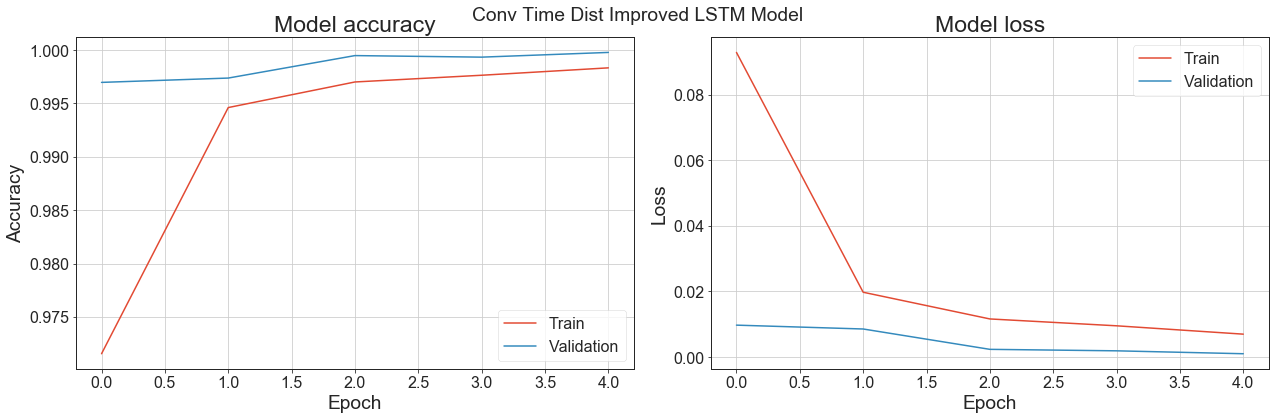

In [471]:
plot_model_history('conv_time_dist_improved_lstm')

Evaluating on train data:
12870/12870 [==============================] - 1730s 134ms/step - loss: 8.5802e-04 - accuracy: 0.9998
Evaulate train loss: 0.0009 / Evaluate train accuracy: 99.981%


Evaluating on validation data:
3218/3218 [==============================] - 468s 145ms/step - loss: 0.0010 - accuracy: 0.9998
Evaulate validation loss: 0.0010 / Evaluate validation accuracy: 99.978%


Evaluating on test data:
5007/5007 [==============================] - 691s 138ms/step - loss: 2.9604 - accuracy: 0.7044

Accuracy: 70.44%
Evaulate test loss: 2.9604 / Evaluate Test accuracy: 70.440%


C:\Users\Itay Bouganim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


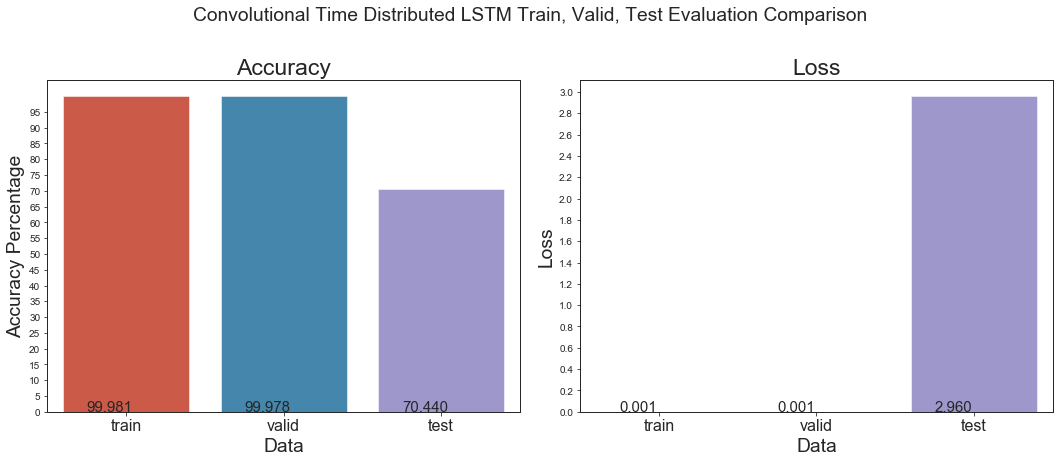

In [594]:
preds, y_true, y_pred, clf_report, scores = evaluate_lstm_model(model_create_func=create_conv_time_dist_improved_lstm_model, saved_model_name='conv_time_dist_improved_lstm')
plot_scores(scores, plot_title="Convolutional Time Distributed LSTM Train, Valid, Test Evaluation Comparison")

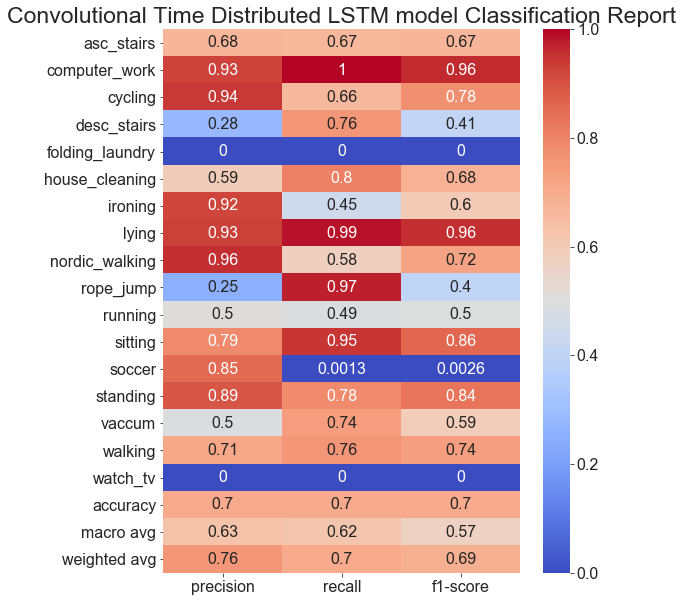

In [595]:
plot_classification_report(clf_report, plot_title="Convolutional Time Distributed LSTM model")

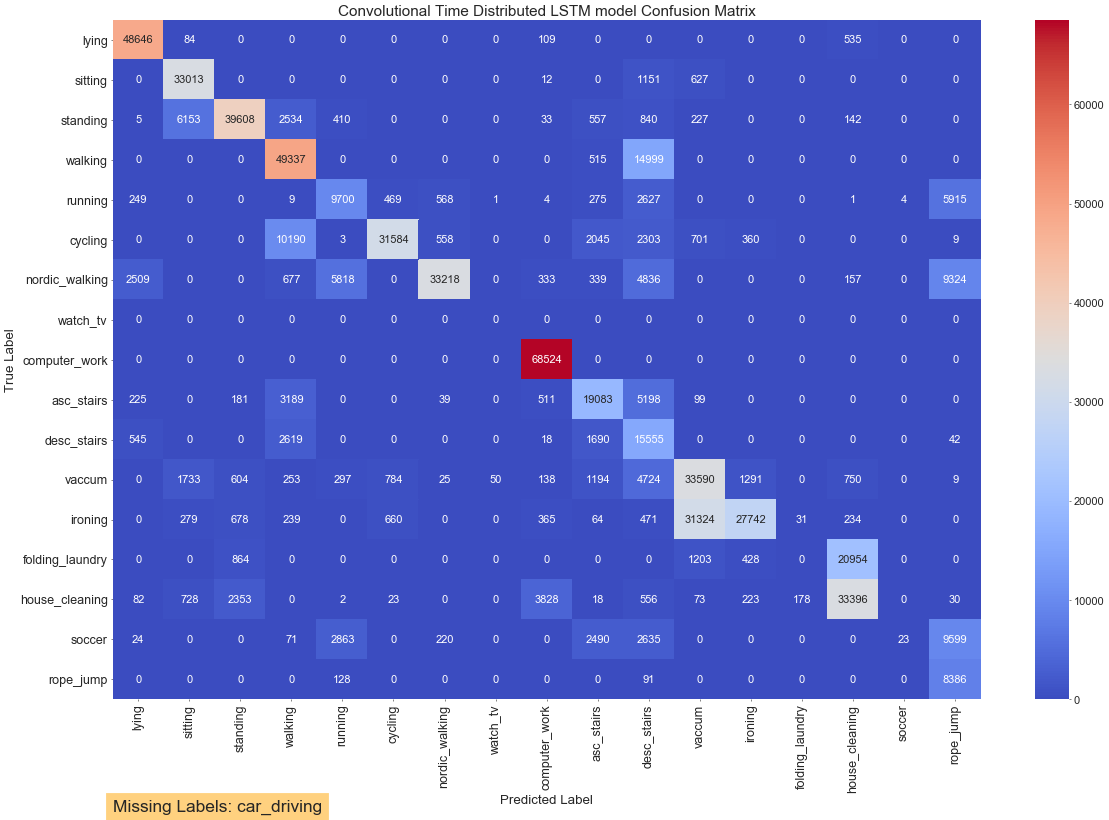

In [596]:
plot_confusion_matrix(y=y_true, y_pred=y_pred, title='Convolutional Time Distributed LSTM model Confusion Matrix')

In [597]:
display_best_worst_predictions(preds, y_pred, y_true)

Top Correct Predictions Samples from each label:


Predicted Label      True Label  Prediction Percentage
0    computer_work   computer_work             100.000000
1          running         running             100.000000
2   nordic_walking  nordic_walking             100.000000
3            lying           lying             100.000000
4          cycling         cycling             100.000000
5        rope_jump       rope_jump             100.000000
6          walking         walking             100.000000
7   house_cleaning  house_cleaning             100.000000
8          sitting         sitting              99.999988
9          ironing         ironing              99.999964
10     desc_stairs     desc_stairs              99.999952
11          vaccum          vaccum              99.999940
12      asc_stairs      asc_stairs              99.999821
13        standing        standing              99.996495
14          soccer          soccer              99.607545


Top Worst Prediction Samples from each label:


Predicted Label       True Label  Prediction Percentage
0     computer_work   house_cleaning             100.000000
1           running           soccer             100.000000
2    nordic_walking          running             100.000000
3    house_cleaning  folding_laundry             100.000000
4         rope_jump           soccer             100.000000
5           walking       asc_stairs              99.999988
6       desc_stairs          walking              99.999928
7            vaccum          ironing              99.999833
8           sitting           vaccum              99.999750
9           ironing           vaccum              99.999642
10          cycling           vaccum              99.999511
11            lying      desc_stairs              99.999154
12         standing   house_cleaning              99.998939
13       asc_stairs      desc_stairs              99.996495
14  folding_laundry   house_cleaning              96.980876
15         watch_tv           vaccum              95.239538
16           soccer          running              69.355273

<h4>Time Distibuted Convolutional Usage Concolusions</h4>
We can see that we achieved a big improvement by adding time distibuted 1D convolutional layers to our model (~52% - ~70.4%).<br/>
We can see that the fact that 2 of the activity types are not represented in out test set hurts affects out testing.<br/>
One of the big observations is that the training and validation set (that was taken from the same subset of subjects) almost firs perfectly (higher than 99%).<br/>
However our test data achieves only 70.4% approx and still have a big loss value.<br/>
The reason for it is probably the fact that we chose as our data all the protocaol and optional data, that caused inconssitency in the representation of the different activities for different subjects
(as not all subjects performed the optional activities).<br/>
If we would train the model only for the protocol activities we would not encounter that problem and probably could achieve higher accuracy and lower loss metrics for out test data.

<h4>We will try to train the same model again to achieve better results</h4>

In [233]:
def retrain_conv_lstm_model(saved_model_name):
    model = create_conv_time_dist_improved_lstm_model()
    model.load_weights(join(model_save_dir, f'model_{saved_model_name}.h5'))
    
    history = model.fit(train_generator, validation_data=valid_generator, epochs=5, verbose=1, callbacks=get_callbacks(saved_model_name=f'{saved_model_name}_retrain'), shuffle=False)
    save_history(history, model_name=f'{saved_model_name}_retrain')
    return history

retrain_conv_lstm_model(saved_model_name='conv_time_dist_improved_lstm')

Epoch 1/5
12870/12870 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9984
Epoch 00001: val_loss improved from inf to 0.00158, saving model to C:\My Files\School\Programming\Projects\Deep Learning\Assignments\Assignment2/data/saved_models\model_conv_time_dist_improved_lstm_retrain.h5
12870/12870 [==============================] - 6639s 516ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 2/5
12870/12870 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9986
Epoch 00002: val_loss did not improve from 0.00158
12870/12870 [==============================] - 6468s 503ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0.0029 - val_accuracy: 0.9992
Epoch 3/5
12870/12870 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9986
Epoch 00003: val_loss did not improve from 0.00158
12870/12870 [==============================] - 6419s 499ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0

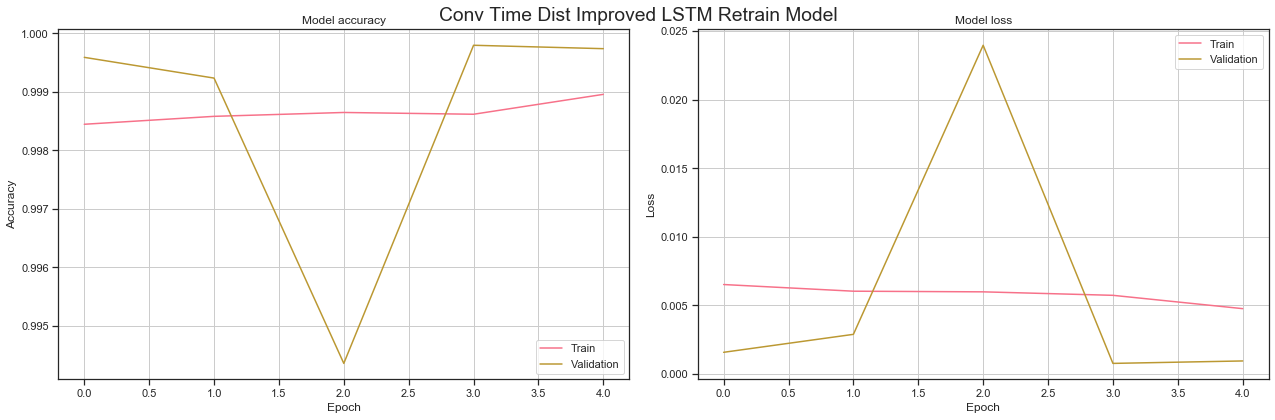

In [242]:
plot_model_history('conv_time_dist_improved_lstm_retrain')

Evaluating on train data:
12870/12870 [==============================] - 1867s 145ms/step - loss: 7.3040e-04 - accuracy: 0.9998
Evaulate train loss: 0.0007 / Evaluate train accuracy: 99.982%


Evaluating on validation data:
3218/3218 [==============================] - 463s 144ms/step - loss: 7.6932e-04 - accuracy: 0.9998
Evaulate validation loss: 0.0008 / Evaluate validation accuracy: 99.979%


Evaluating on test data:
5007/5007 [==============================] - 711s 142ms/step - loss: 3.7098 - accuracy: 0.6312

Accuracy: 63.12%
Evaulate test loss: 3.7098 / Evaluate Test accuracy: 63.116%


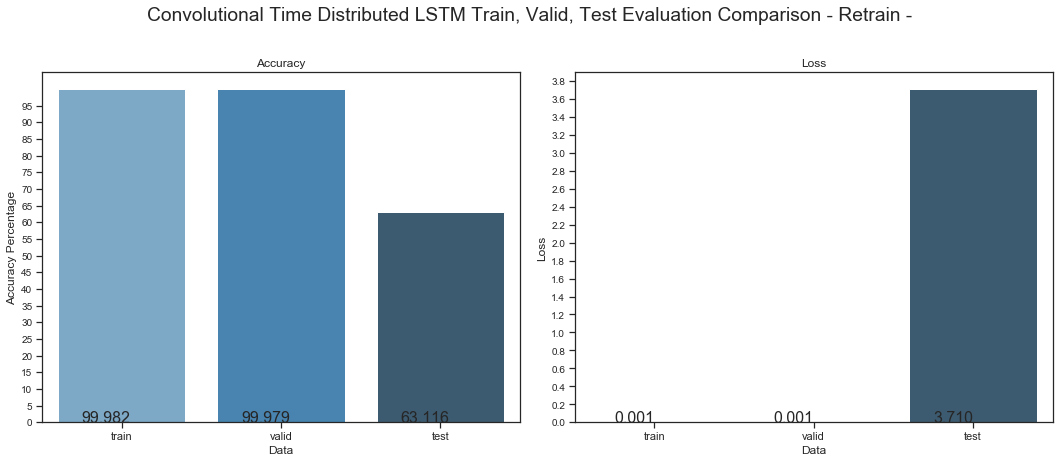

In [243]:
preds, y_true, y_pred, clf_report, scores = evaluate_lstm_model(model_create_func=create_conv_time_dist_improved_lstm_model, saved_model_name='conv_time_dist_improved_lstm_retrain')
plot_scores(scores, plot_title="Convolutional Time Distributed LSTM Train, Valid, Test Evaluation Comparison - Retrain -")

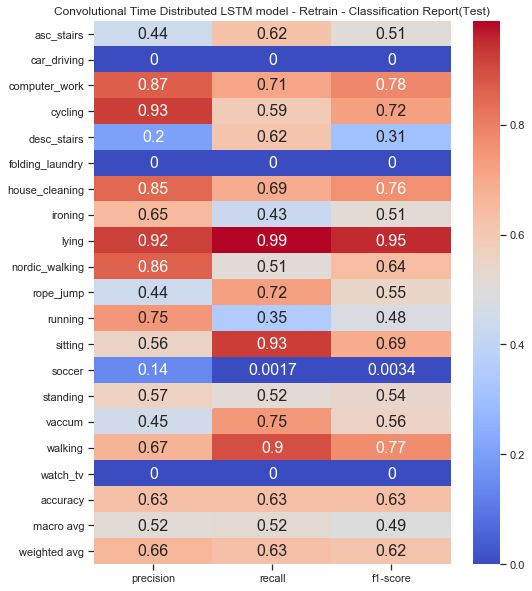

In [244]:
plot_classification_report(clf_report, plot_title="Convolutional Time Distributed LSTM model - Retrain -")

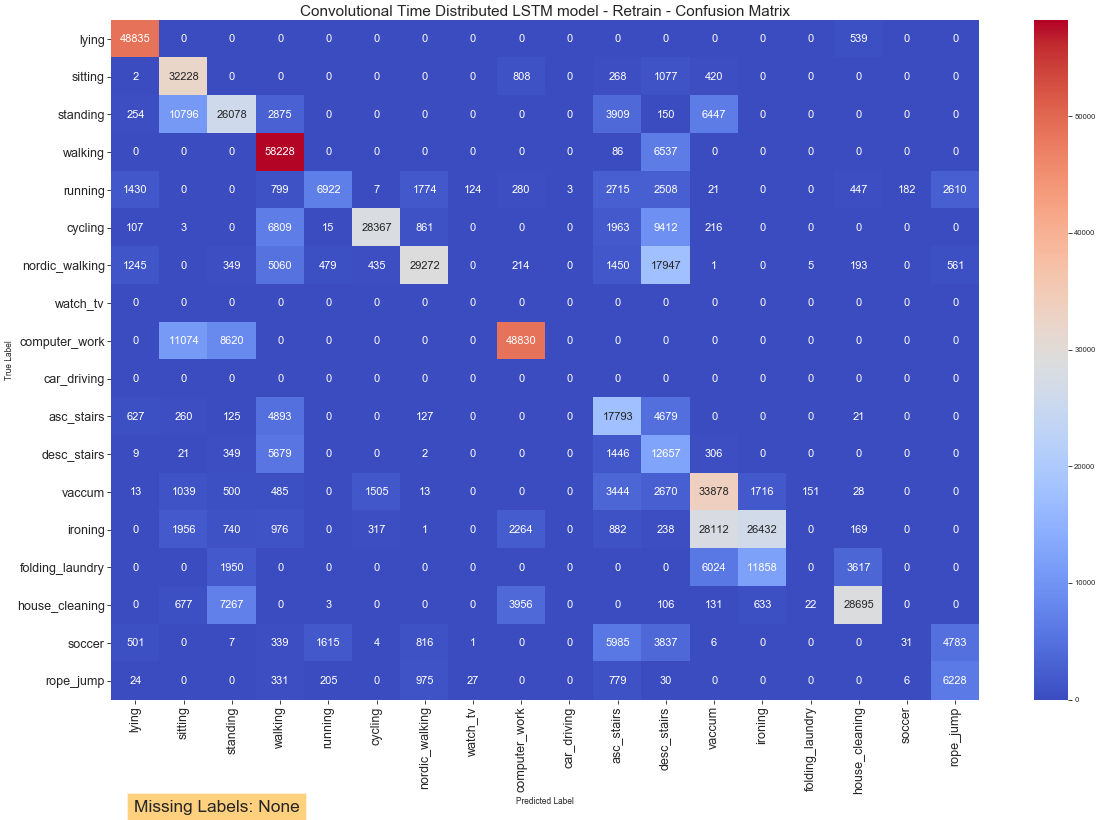

In [245]:
plot_confusion_matrix(y=y_true, y_pred=y_pred, title='Convolutional Time Distributed LSTM model - Retrain - Confusion Matrix')

In [246]:
display_best_worst_predictions(preds, y_pred, y_true)

Top Correct Predictions Samples from each label:


Predicted Label      True Label  Prediction Percentage
0            lying           lying             100.000000
1          cycling         cycling             100.000000
2    computer_work   computer_work             100.000000
3   nordic_walking  nordic_walking             100.000000
4   house_cleaning  house_cleaning             100.000000
5          running         running             100.000000
6        rope_jump       rope_jump             100.000000
7          walking         walking             100.000000
8          ironing         ironing              99.999988
9          sitting         sitting              99.999988
10          vaccum          vaccum              99.999988
11     desc_stairs     desc_stairs              99.999976
12      asc_stairs      asc_stairs              99.999893
13        standing        standing              99.995935
14          soccer          soccer              99.584299


Top Worst Prediction Samples from each label:


Predicted Label       True Label  Prediction Percentage
0    house_cleaning  folding_laundry             100.000000
1    nordic_walking           soccer             100.000000
2           sitting    computer_work             100.000000
3           running           soccer             100.000000
4     computer_work          ironing             100.000000
5         rope_jump           soccer             100.000000
6             lying          running             100.000000
7           walking      desc_stairs             100.000000
8            vaccum          ironing              99.999988
9           cycling   nordic_walking              99.999988
10          ironing           vaccum              99.999940
11      desc_stairs          walking              99.999940
12       asc_stairs           soccer              99.999392
13         standing    computer_work              99.999344
14           soccer          running              98.919791
15         watch_tv        rope_jump              97.576469
16  folding_laundry   house_cleaning              92.900145
17      car_driving          running              35.206848

<h4>Second train conclusions</h4>
We can see that the model increased very slightly when it comes to train/validation metrics.</br>
However we had a big drop in the test data metrics. We can conclude that the model started overfitting at this point and more training will lower our test metrics.<br/>
(We can't really notice the overfitting for the validation data since it was sampled from the same activity time frames as the training data and therfore our model accepts it well as opposed to the training data.

<h2>Model Performance Summary</h2>


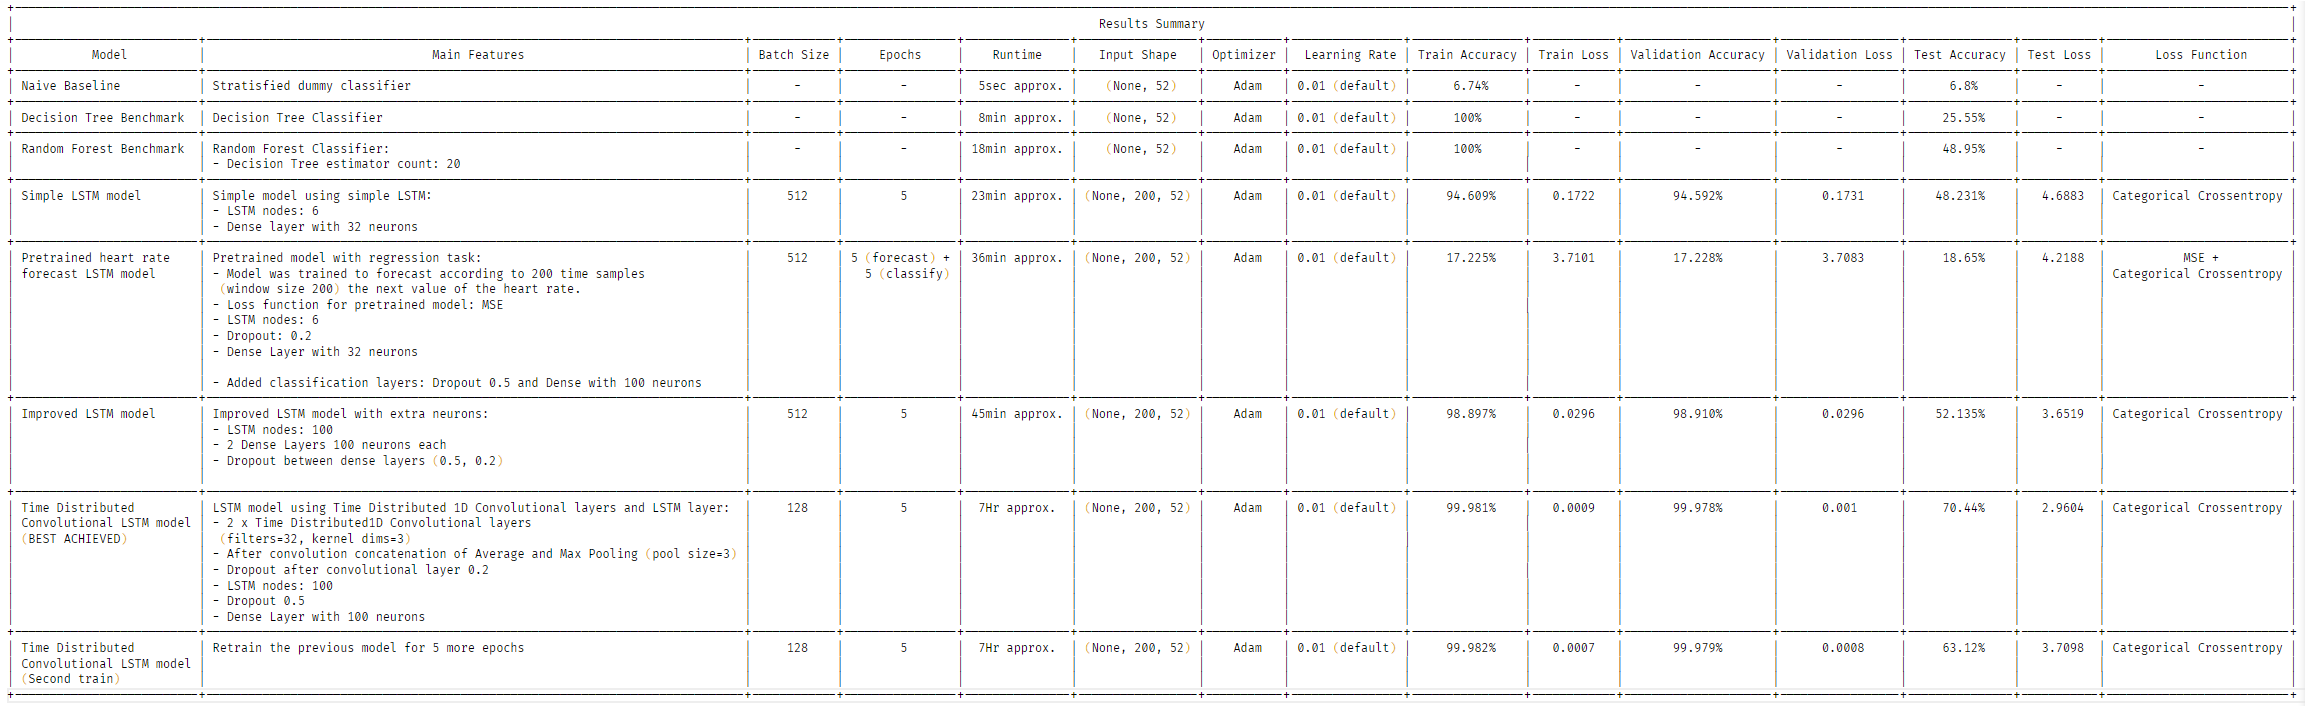

In [4]:
display_image('summary.png')